In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime
from datetime import timedelta
import time
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS
import concurrent.futures
from geopy.distance import geodesic
from uszipcode import SearchEngine
from pandarallel import pandarallel
import pgeocode

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [126]:
df = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240605.csv')
df_tn_reg = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_EV_Registrations.csv')
df_venue= pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\lat_long_charging_venue.csv')
df_GIS= pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\rechargingstationproject\GIS_distance.xlsx', sheet_name='Total')
df_tn_population = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\tennessee_counties_population.csv')
df_tn_AADT = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_AADT_TDOT.xlsx')
df_tn_MHHI_county = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Median_H_H_Income.xlsx')
df_tn_TEMP_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Average_Temperature.csv')
df_tn_Cooling_Degree_Days_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Cooling_Degree_Days.csv')


In [123]:
# Filter the DataFrame for the state of Tennessee
tennessee_df = df[df['State/Province'] == 'Tennessee']

# Get the number of unique EVSE IDs in Tennessee
unique_evse_ids_tennessee = tennessee_df['EVSE ID'].nunique()
print(f"Number of unique EVSE IDs in Tennessee: {unique_evse_ids_tennessee}")


num_nan_start_soc = df['End SOC'].isna().sum()
print(f"Number of NaN values in 'Start SOC' column: {num_nan_start_soc}")

num_nan_Driver_Zip_Postal_Code = df['Driver Zip/Postal Code'].isna().sum()
print(f"Number of NaN values in 'Driver zip code' column: {num_nan_Driver_Zip_Postal_Code}")

Number of unique EVSE IDs in Tennessee: 80
Number of NaN values in 'Start SOC' column: 30473
Number of NaN values in 'Driver zip code' column: 8889


In [124]:
df = df[df['Energy (kWh)'] != 0]   # remove rows with no Energy 
df['Driver Zip/Postal Code'] = df['Driver Zip/Postal Code'].fillna(df['Zip/Postal Code'])
missing_count_port_type = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Remove specified columns
columns_to_remove = ['Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude', 'Longitude']
df = df.drop(columns=columns_to_remove)

# Merge with venue information
df = pd.merge(df, df_venue[['EVSE ID', 'Charging Venue', 'Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude (y)', 'Longitude (x)']], on='EVSE ID', how='left')


In [125]:
#Calculate distance 
dist = pgeocode.GeoDistance('us')         
def calculate_distance_miles(zip1, zip2):
    try:
        distance_km = dist.query_postal_code(zip1, zip2)
        distance_miles = distance_km * 0.621371
        return distance_miles
    except ValueError:
        return None

df['Distance (miles)'] = df.apply(lambda row: calculate_distance_miles(row['Zip/Postal Code'], row['Driver Zip/Postal Code']), axis=1)  

KeyboardInterrupt: 

In [359]:
nan_count_driver_zipcode = df['Driver Zip/Postal Code'].isna().sum()
nan_count_distance = df['Distance (miles)'].isna().sum()
nan_count_station_zip = df['Zip/Postal Code'].isna().sum()

print(f"Number of NaN values in 'Driver Zip/Postal Code': {nan_count_driver_zipcode}")
print(f"Number of NaN values in 'Distance': {nan_count_distance}")
print(f"Number of NaN values in 'station zipcode': {nan_count_station_zip}")

Number of NaN values in 'Driver Zip/Postal Code': 0
Number of NaN values in 'Distance': 885
Number of NaN values in 'station zipcode': 0


In [360]:
df = df.dropna(subset=['Distance (miles)'])

In [7]:
df.to_csv('Session-Details-Summary-20240605_with_distances.csv', index=False)

In [238]:
df=pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240605_with_distances.csv')

In [239]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])


#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
#df['Charging Time (dayTime)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]
#df['End_Charging_Time_EST_2']= df['Start_Time_EST'] +df['Charging Time (dayTime)']

# Data cleaning 
# sessions with delivered energy > 140 kWh, since these are incompatible with the usable battery capacities of the Rivian 
# R1T and extended-range Ford F-150 Lighting, the two mass-market EVs with the largest batteries available through March 2022;
# (2) sessions with a charge duration of 0 h or where no energy was delivered; 

df = df[(df['Energy (kWh)'] != 0) & (df['Energy (kWh)'] <= 140) & (df['Charging Time']!=0)]

In [240]:


# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Peak hour 
# Add a new column 'peak_hour'
df['Start_Time_EST_Day'] = pd.to_datetime(df['Start_Time_EST']).dt.hour
df['peak_hour'] = ((df['Start_Time_EST_Day'] >= 6) & (df['Start_Time_EST_Day'] <= 20)).astype(int)


# Extract the month from 'Start Date'
df['month'] = pd.to_datetime(df['Start_Time_EST']).dt.month

def month_to_season(month):
    if month in [12, 1, 2]:
        return 4  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(month_to_season)



# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)


# If location of CS and driver are the same 

df['same_location'] = (df['Zip/Postal Code'] == df['Driver Zip/Postal Code']).astype(int)



# Add VENUE features


df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Edu') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_HWY'] = (df['Charging Venue'] == 'HWY').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Shopping').astype(int)
df['ven_Hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()




#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']


###### Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']
port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].mean().reset_index()
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')
df = df.drop(columns=['Power_Delivered_x'])
df = df.drop(columns=['Power_Delivered_y'])
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')




#---------------------------------------------------------------------------------------------------------------------
###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
####   DC and L2 df  ####
df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]

# TN State
#df_TN=df[df['State/Province']=='Tennessee']



In [241]:
df = df[(df['State/Province'] == 'Tennessee')]

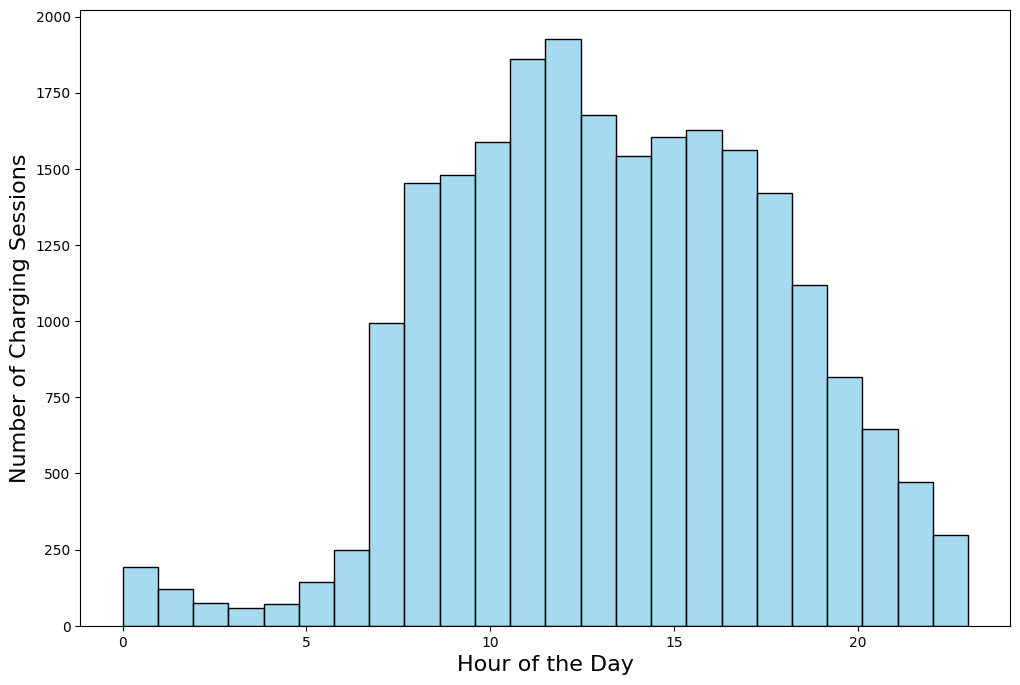

In [135]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Hour'] = df['Start_Tim_EST'].dt.hour

plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Hour', bins=24, kde=False, color='skyblue')
#plt.title('Distribution of Charging Sessions at Each Hour of the Day')
plt.xlabel('Hour of the Day', fontsize=16)  # Increase the font size here
plt.ylabel('Number of Charging Sessions', fontsize=16)  # Increase the font size here
plt.show()


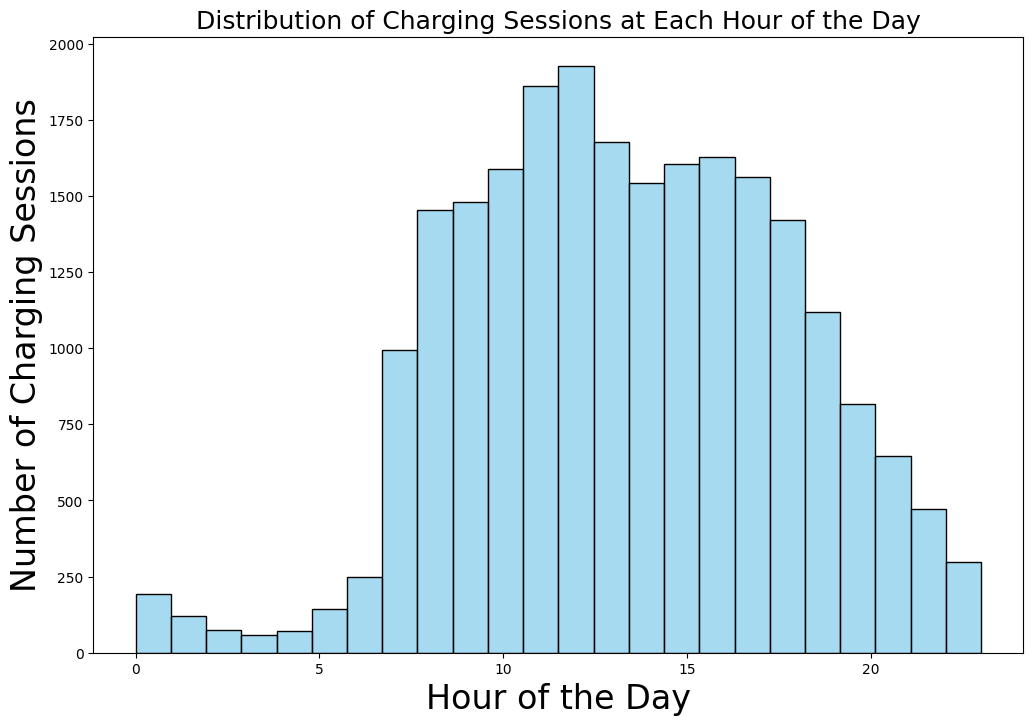

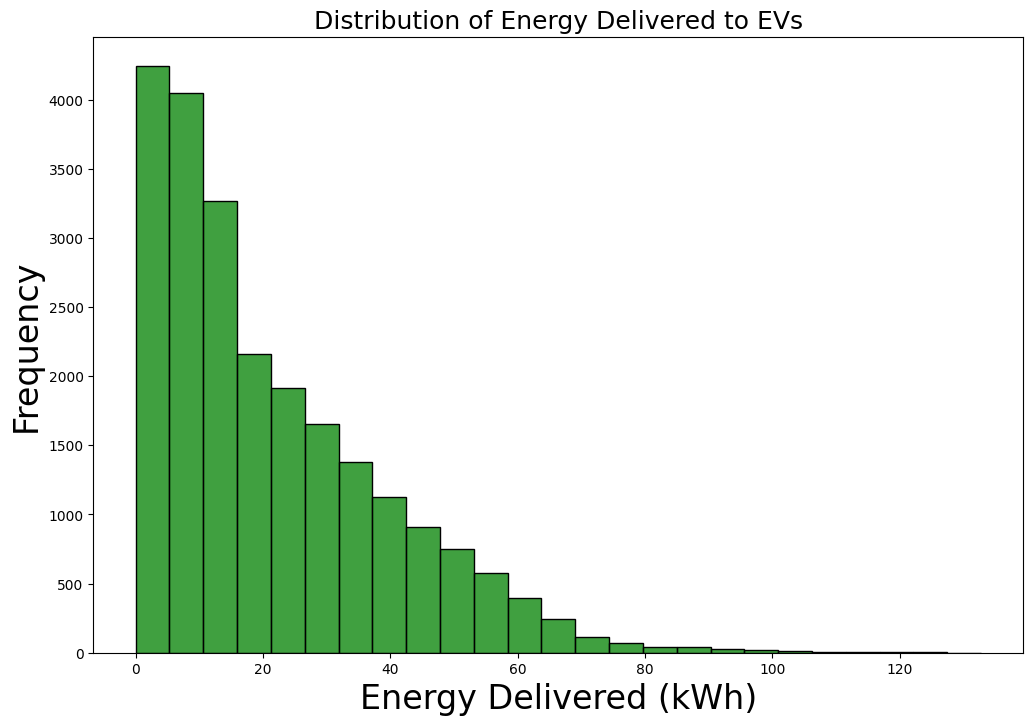

In [108]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Hour'] = df['Start_Tim_EST'].dt.hour

# Create the first histogram for the 'Hour' column
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Hour', bins=24, kde=False, color='skyblue')
plt.xlabel('Hour of the Day', fontsize=24)  # Increase the font size here
plt.ylabel('Number of Charging Sessions', fontsize=24)  # Increase the font size here
plt.title('Distribution of Charging Sessions at Each Hour of the Day', fontsize=18)
plt.show()

# Create the second histogram for the 'Energy (kWh)' column
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='Energy (kWh)', bins=25, kde=False, color='green')
plt.xlabel('Energy Delivered (kWh)', fontsize=24)  # Increase the font size here
plt.ylabel('Frequency', fontsize=24)  # Increase the font size here
plt.title('Distribution of Energy Delivered to EVs', fontsize=18)
plt.show()


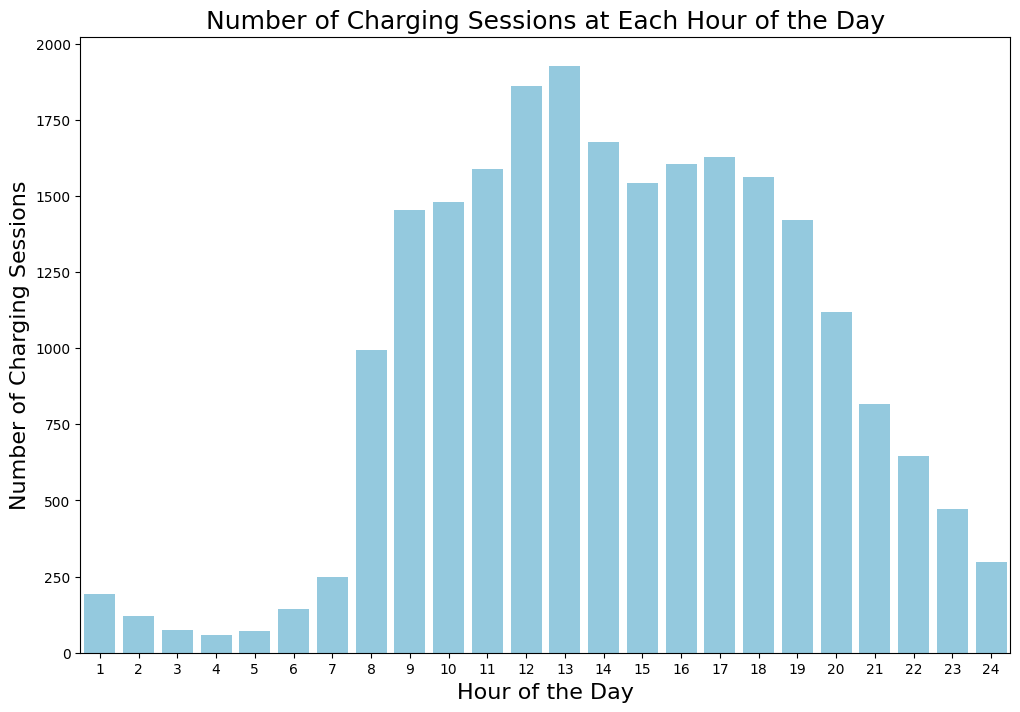

In [27]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  

# Group by the hour and count the number of sessions
hourly_sessions = df.groupby('Hour').size().reset_index(name='Number of Sessions')

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=hourly_sessions, x='Hour', y='Number of Sessions', color='skyblue')
plt.xlabel('Hour of the Day', fontsize=16)  # Increase the font size here
plt.ylabel('Number of Charging Sessions', fontsize=16)  # Increase the font size here
plt.title('Number of Charging Sessions at Each Hour of the Day', fontsize=18)
plt.xticks(rotation=0)  # No need to rotate labels
plt.show()


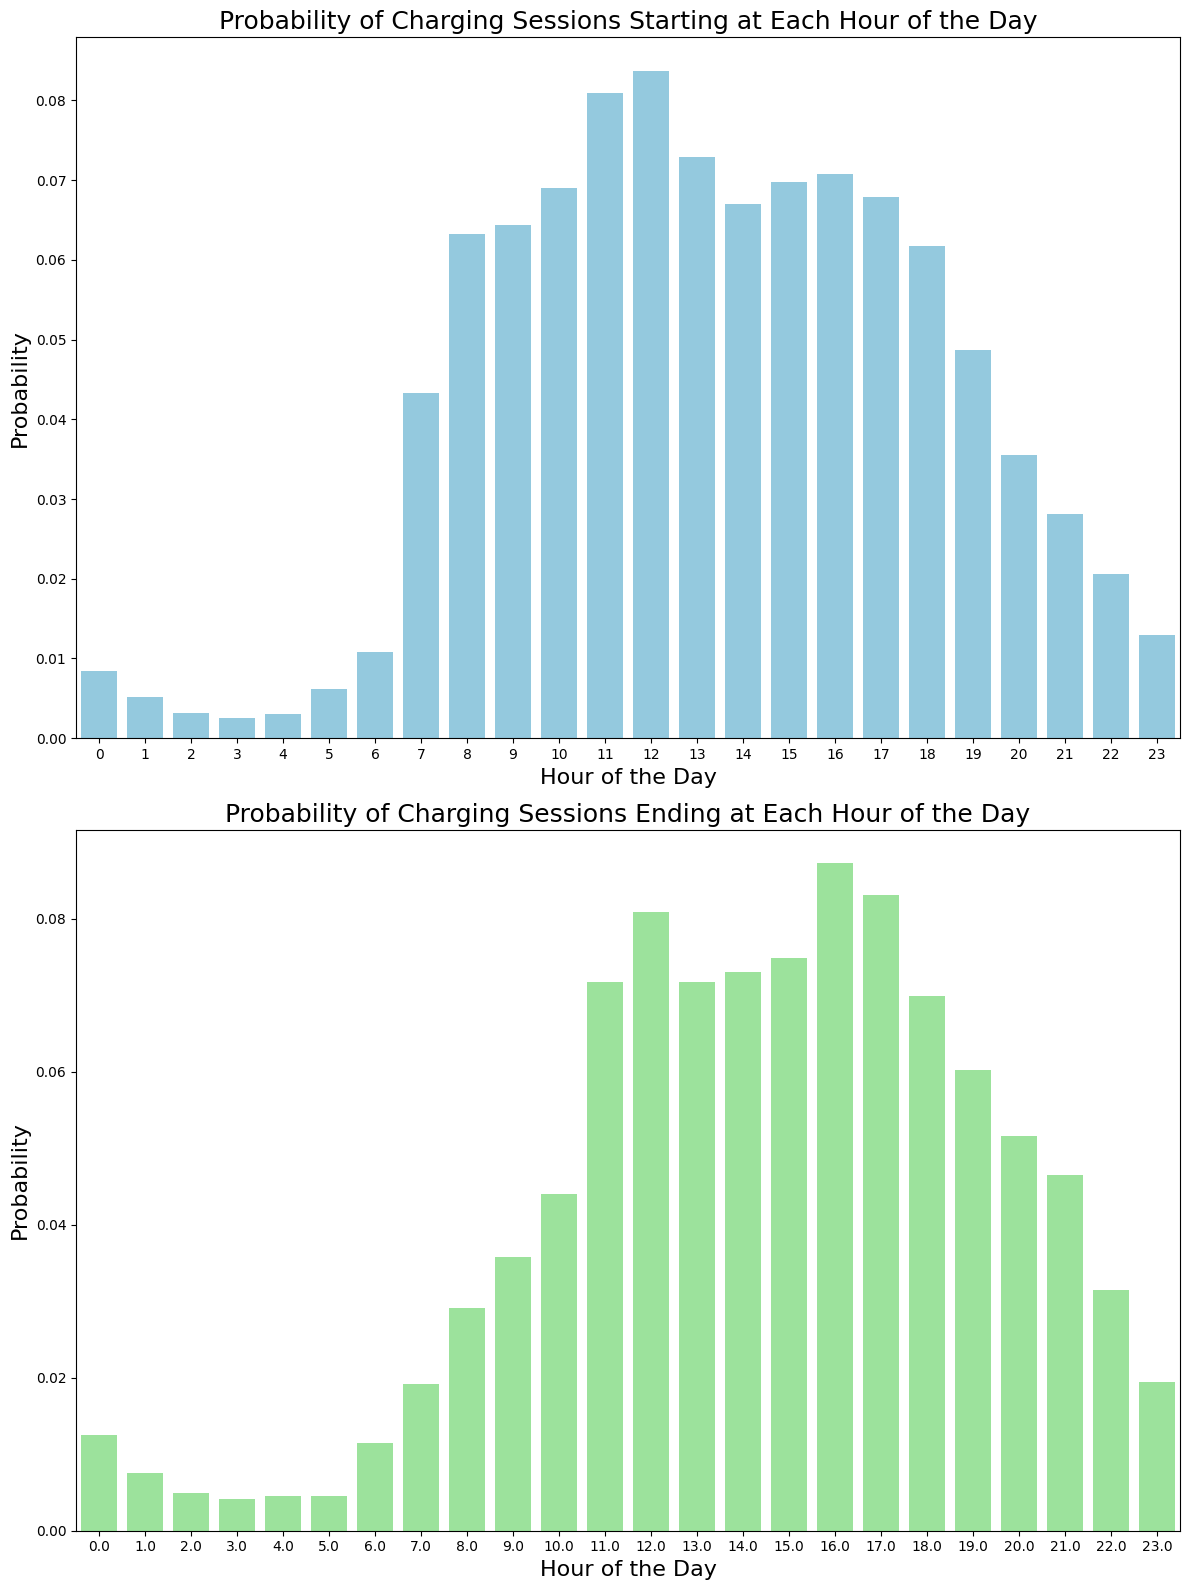

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Process Start Time
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Start_Hour'] = df['Start_Time_EST'].dt.hour

# Process End Time
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'])
df['End_Hour'] = df['End_Time_EST'].dt.hour

# Calculate probabilities for Start Time
start_hourly_prob = df.groupby('Start_Hour').size() / len(df)
start_hourly_prob = start_hourly_prob.reset_index(name='Probability')

# Calculate probabilities for End Time
end_hourly_prob = df.groupby('End_Hour').size() / len(df)
end_hourly_prob = end_hourly_prob.reset_index(name='Probability')

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Plot for Start Time
sns.barplot(data=start_hourly_prob, x='Start_Hour', y='Probability', color='skyblue', ax=ax1)
ax1.set_xlabel('Hour of the Day', fontsize=16)
ax1.set_ylabel('Probability', fontsize=16)
ax1.set_title('Probability of Charging Sessions Starting at Each Hour of the Day', fontsize=18)
ax1.tick_params(axis='x', rotation=0)

# Plot for End Time
sns.barplot(data=end_hourly_prob, x='End_Hour', y='Probability', color='lightgreen', ax=ax2)
ax2.set_xlabel('Hour of the Day', fontsize=16)
ax2.set_ylabel('Probability', fontsize=16)
ax2.set_title('Probability of Charging Sessions Ending at Each Hour of the Day', fontsize=18)
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

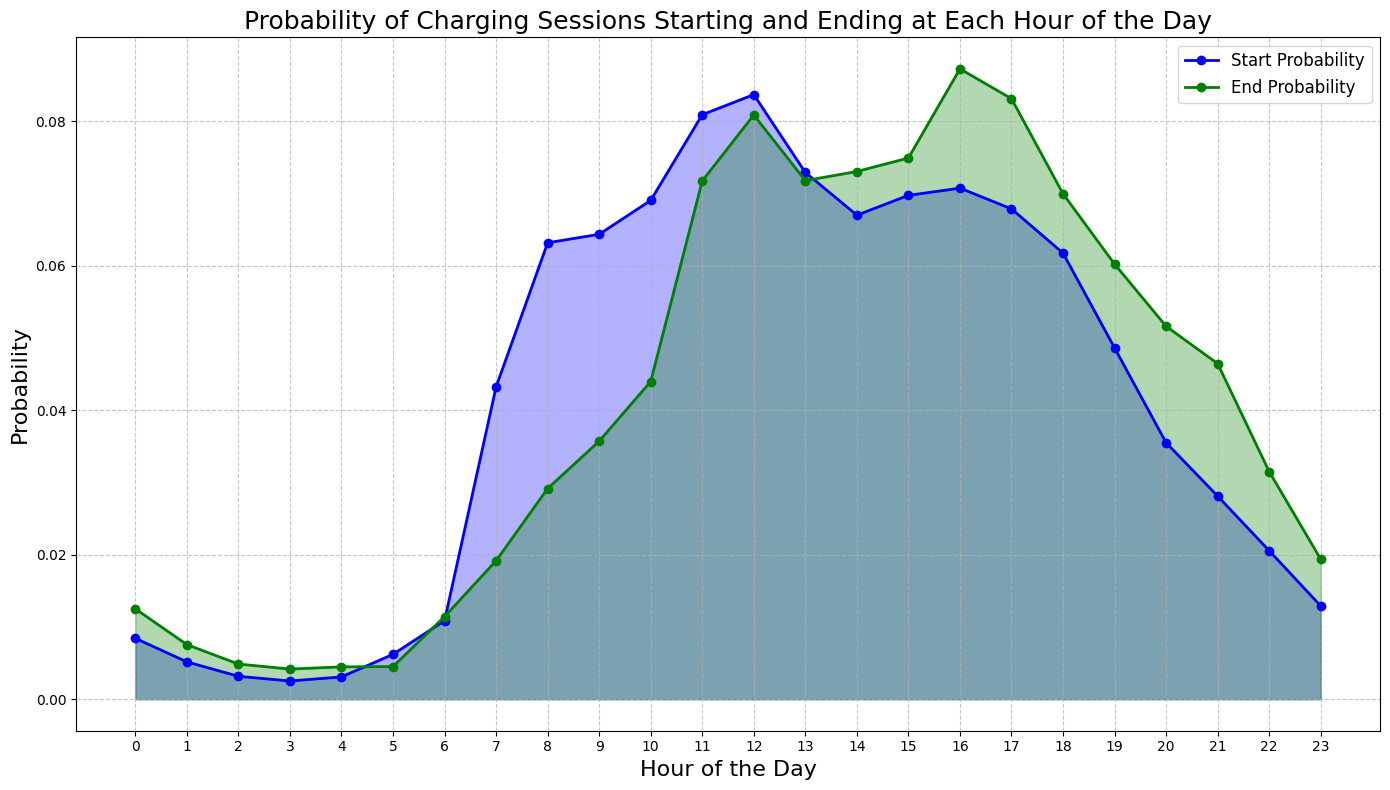

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Process Start Time
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Start_Hour'] = df['Start_Time_EST'].dt.hour

# Process End Time
df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'])
df['End_Hour'] = df['End_Time_EST'].dt.hour

# Calculate probabilities for Start Time
start_hourly_prob = df.groupby('Start_Hour').size() / len(df)
start_hourly_prob = start_hourly_prob.reset_index(name='Start_Probability')

# Calculate probabilities for End Time
end_hourly_prob = df.groupby('End_Hour').size() / len(df)
end_hourly_prob = end_hourly_prob.reset_index(name='End_Probability')

# Merge the two dataframes
hourly_prob = pd.merge(start_hourly_prob, end_hourly_prob, left_on='Start_Hour', right_on='End_Hour', how='outer')
hourly_prob = hourly_prob.fillna(0)
hourly_prob = hourly_prob.rename(columns={'Start_Hour': 'Hour'})

# Create the plot
plt.figure(figsize=(14, 8))

# Plot Start Probability
plt.plot(hourly_prob['Hour'], hourly_prob['Start_Probability'], color='blue', linewidth=2, marker='o', label='Start Probability')

# Plot End Probability
plt.plot(hourly_prob['Hour'], hourly_prob['End_Probability'], color='green', linewidth=2, marker='o', label='End Probability')

plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.title('Probability of Charging Sessions Starting and Ending at Each Hour of the Day', fontsize=18)
plt.legend(fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)

# Fill the area under the curves
plt.fill_between(hourly_prob['Hour'], hourly_prob['Start_Probability'], alpha=0.3, color='blue')
plt.fill_between(hourly_prob['Hour'], hourly_prob['End_Probability'], alpha=0.3, color='green')

plt.tight_layout()
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3786499991.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Start_Time_EST'] = pd.to_datetime(data['Start_Time_EST'])
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3786499991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Start_Hour'] = data['Start_Time_EST'].dt.hour
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3786499991.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

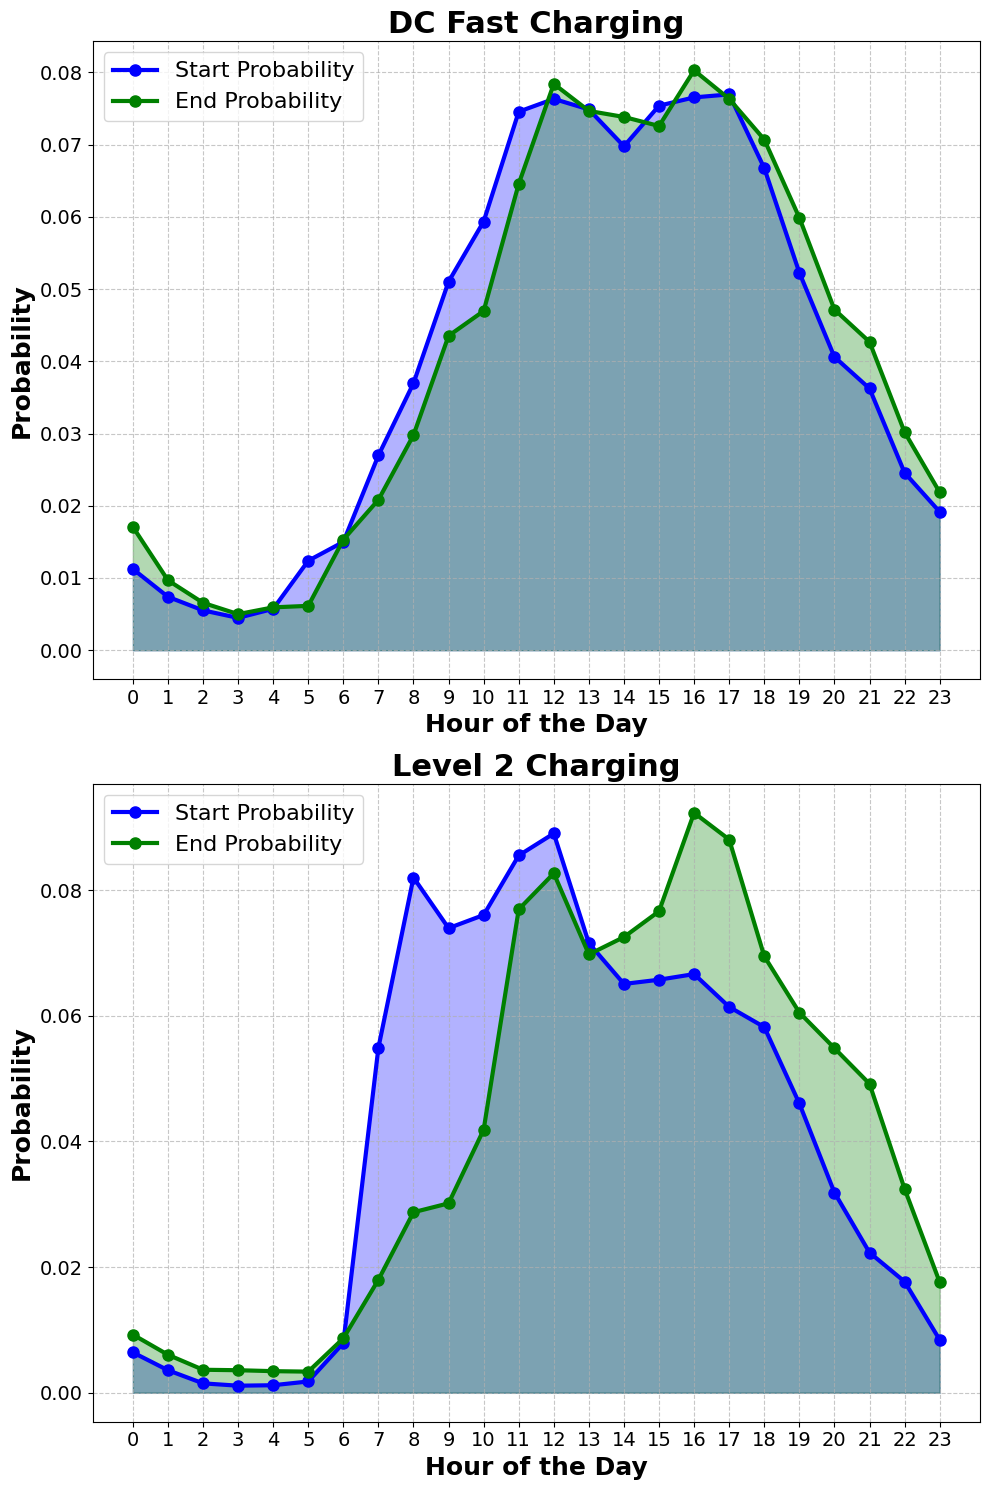

In [171]:

dc_fast = df[df['Port Type'] == 'DC Fast']
level_2 = df[df['Port Type'] == 'Level 2']

def process_and_plot(data, ax, title):
    # Process Start Time
    data['Start_Time_EST'] = pd.to_datetime(data['Start_Time_EST'])
    data['Start_Hour'] = data['Start_Time_EST'].dt.hour

    # Process End Time
    data['End_Time_EST'] = pd.to_datetime(data['End_Time_EST'])
    data['End_Hour'] = data['End_Time_EST'].dt.hour

    # Calculate probabilities for Start Time
    start_hourly_prob = data.groupby('Start_Hour').size() / len(data)
    start_hourly_prob = start_hourly_prob.reset_index(name='Start_Probability')

    # Calculate probabilities for End Time
    end_hourly_prob = data.groupby('End_Hour').size() / len(data)
    end_hourly_prob = end_hourly_prob.reset_index(name='End_Probability')

    # Merge the two dataframes
    hourly_prob = pd.merge(start_hourly_prob, end_hourly_prob, left_on='Start_Hour', right_on='End_Hour', how='outer')
    hourly_prob = hourly_prob.fillna(0)
    hourly_prob = hourly_prob.rename(columns={'Start_Hour': 'Hour'})

    # Plot Start Probability
    ax.plot(hourly_prob['Hour'], hourly_prob['Start_Probability'], color='blue', linewidth=3, marker='o', markersize=8, label='Start Probability')
    ax.fill_between(hourly_prob['Hour'], hourly_prob['Start_Probability'], alpha=0.3, color='blue')

    # Plot End Probability
    ax.plot(hourly_prob['Hour'], hourly_prob['End_Probability'], color='green', linewidth=3, marker='o', markersize=8, label='End Probability')
    ax.fill_between(hourly_prob['Hour'], hourly_prob['End_Probability'], alpha=0.3, color='green')

    ax.set_xlabel('Hour of the Day', fontsize=18, fontweight='bold')
    ax.set_ylabel('Probability', fontsize=18, fontweight='bold')
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.legend(fontsize=16)
    ax.set_xticks(range(0, 24))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True, linestyle='--', alpha=0.7)

# Create the plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# Plot for DC Fast charging stations
process_and_plot(dc_fast, ax1, 'DC Fast Charging')  #Probability of Sessions Starting and Ending by Hour

# Plot for Level 2 charging stations
process_and_plot(level_2, ax2, 'Level 2 Charging')

plt.tight_layout()
plt.show()


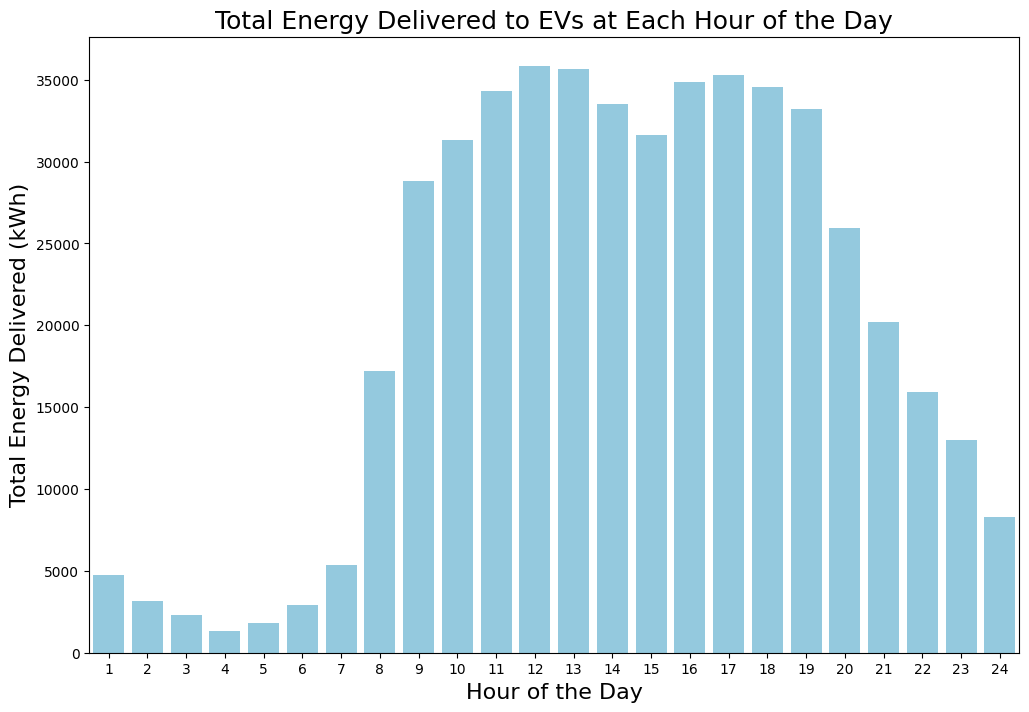

In [28]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  # Extract the hour and shift from 0-23 to 1-24

# Group by the hour and sum the energy delivered
hourly_energy = df.groupby('Hour')['Energy (kWh)'].sum().reset_index()

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=hourly_energy, x='Hour', y='Energy (kWh)', color='skyblue')
plt.xlabel('Hour of the Day', fontsize=16)  # Increase the font size here
plt.ylabel('Total Energy Delivered (kWh)', fontsize=16)  # Increase the font size here
plt.title('Total Energy Delivered to EVs at Each Hour of the Day', fontsize=18)
plt.xticks(rotation=0)  # No need to rotate labels
plt.show()


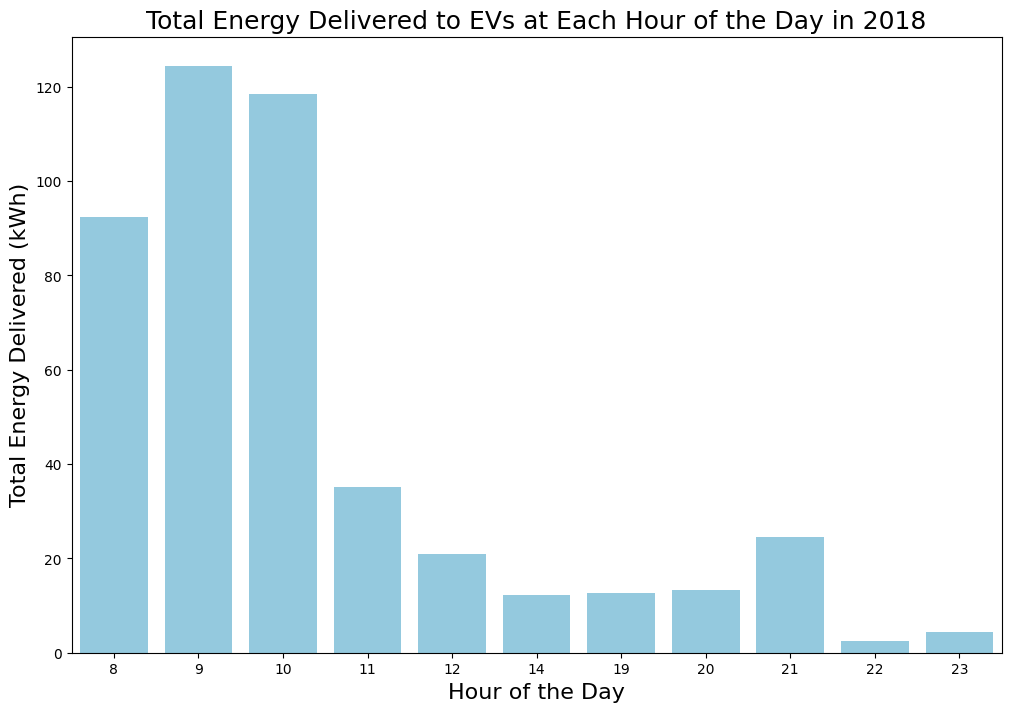

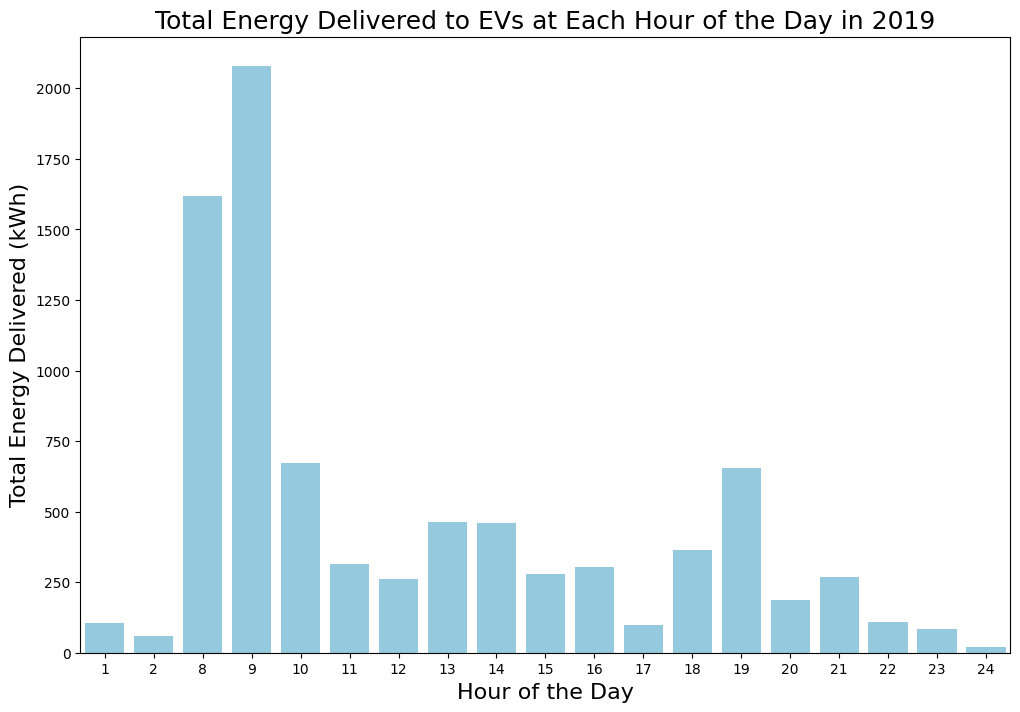

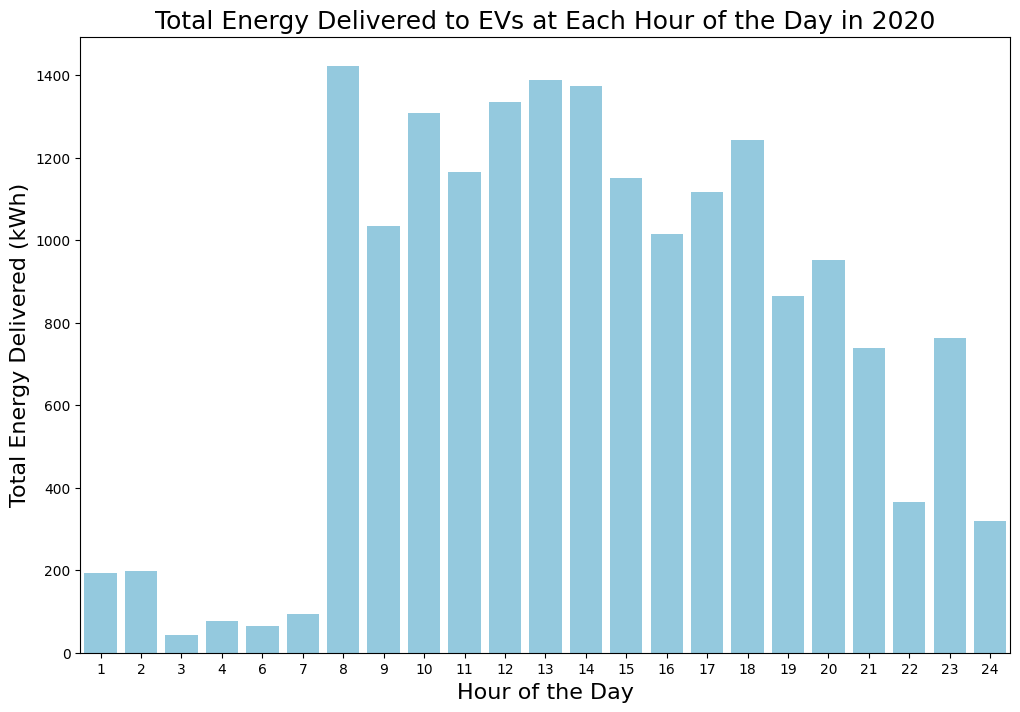

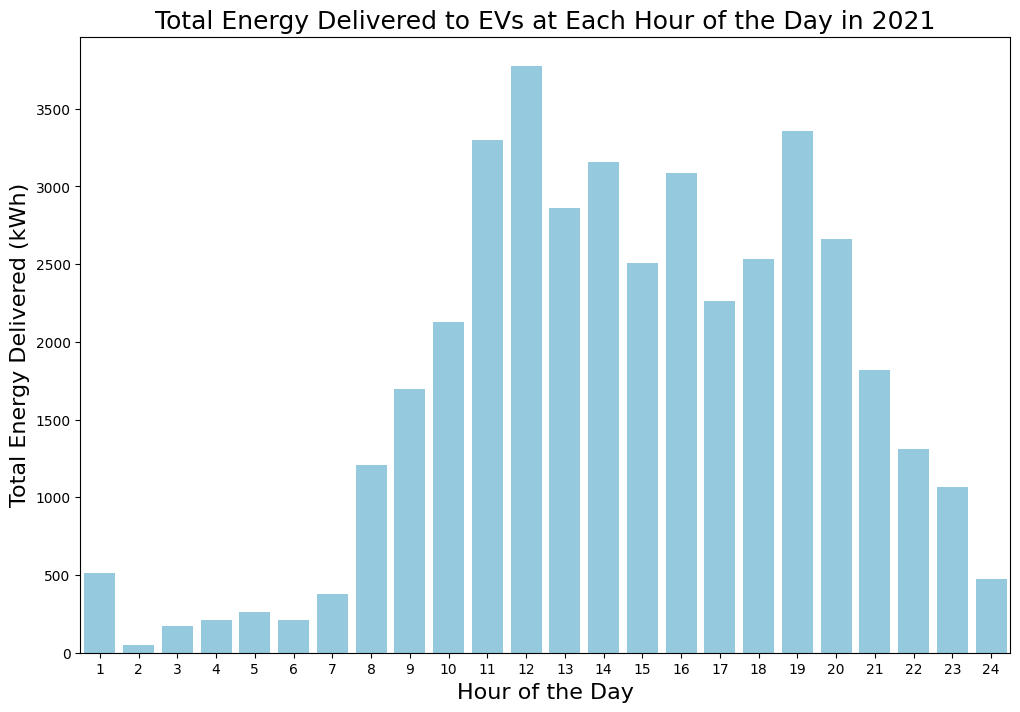

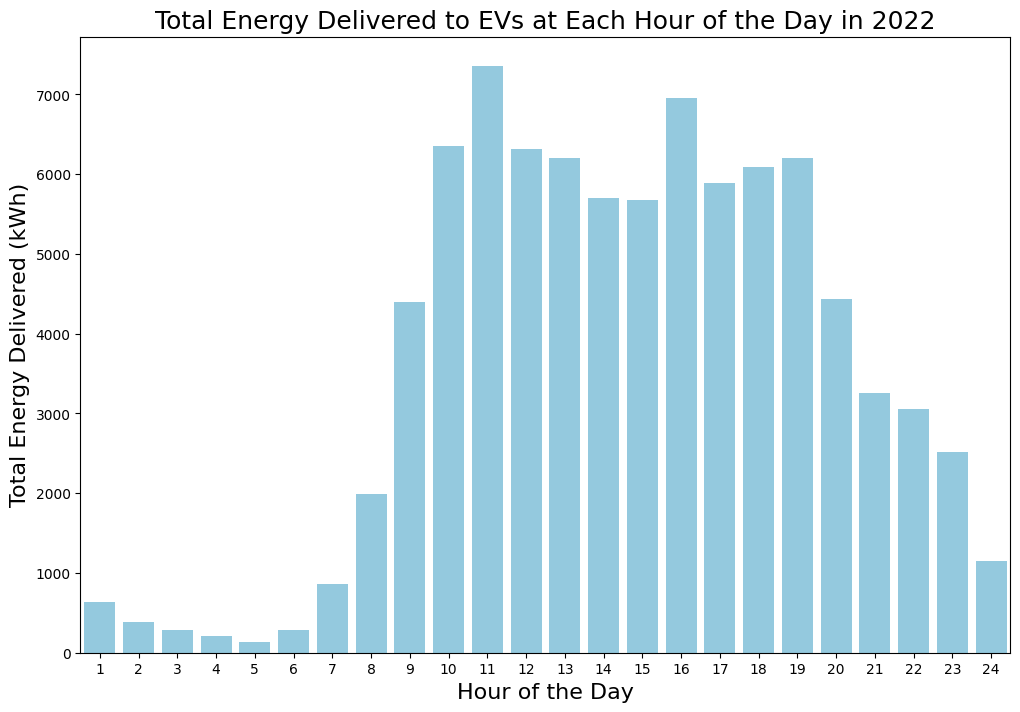

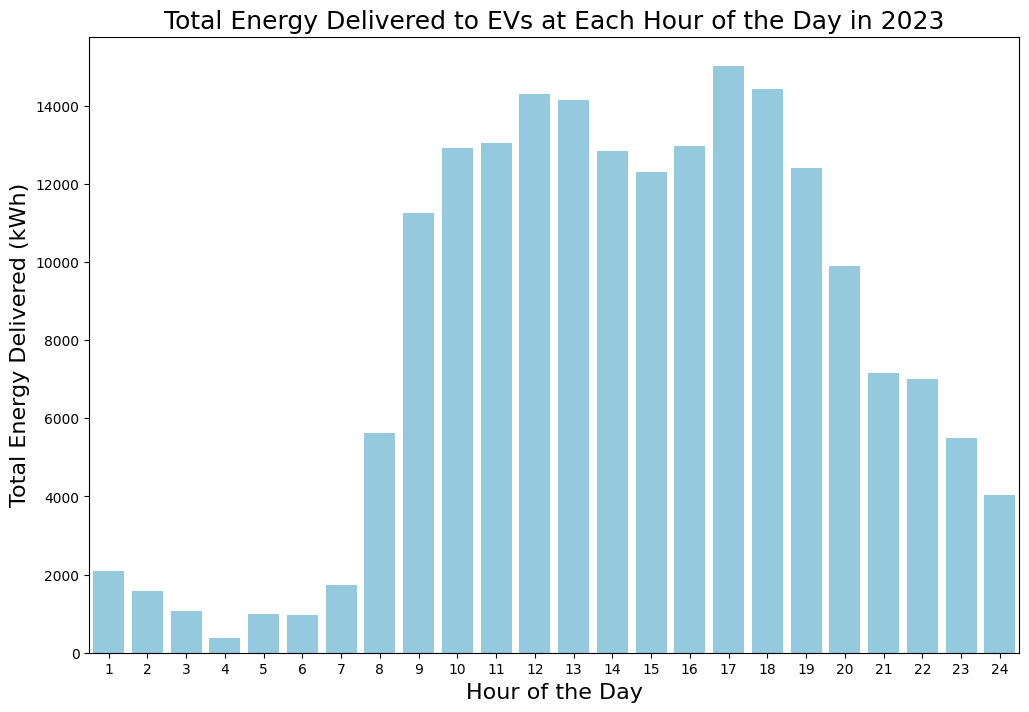

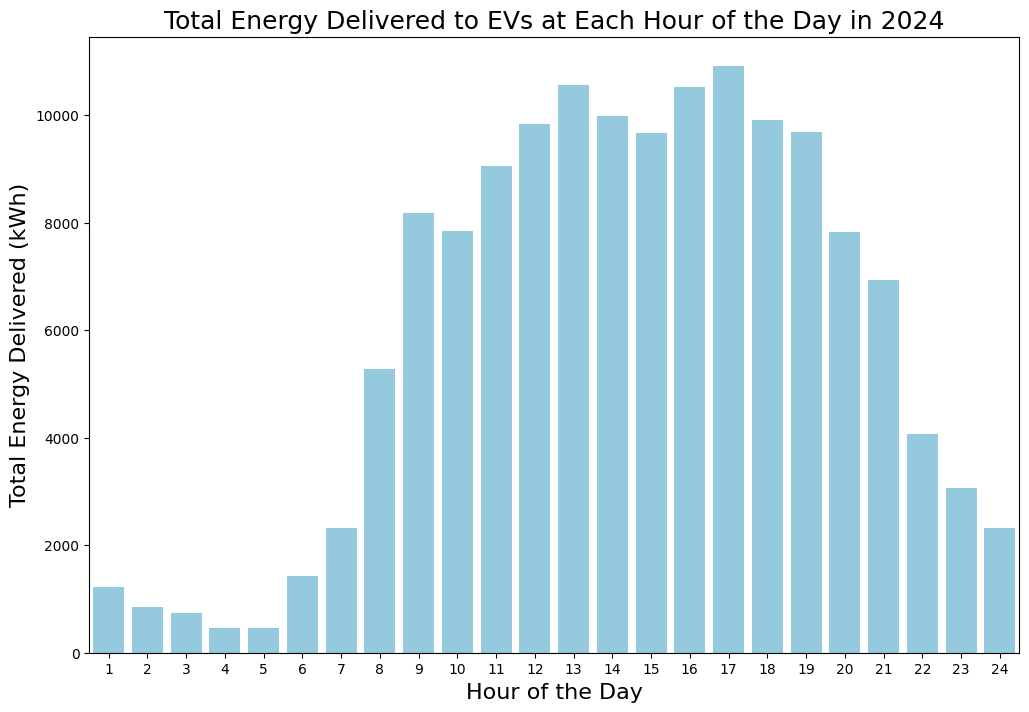

In [29]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  

# Get the unique years in the dataset
years = df['Year'].unique()

# Loop through each year and create a plot
for year in years:
    yearly_data = df[df['Year'] == year]
    hourly_energy = yearly_data.groupby('Hour')['Energy (kWh)'].sum().reset_index()

    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.barplot(data=hourly_energy, x='Hour', y='Energy (kWh)', color='skyblue')
    plt.xlabel('Hour of the Day', fontsize=16)  # Increase the font size here
    plt.ylabel('Total Energy Delivered (kWh)', fontsize=16)  # Increase the font size here
    plt.title(f'Total Energy Delivered to EVs at Each Hour of the Day in {year}', fontsize=18)
    plt.xticks(rotation=0)  # No need to rotate labels
    plt.show()


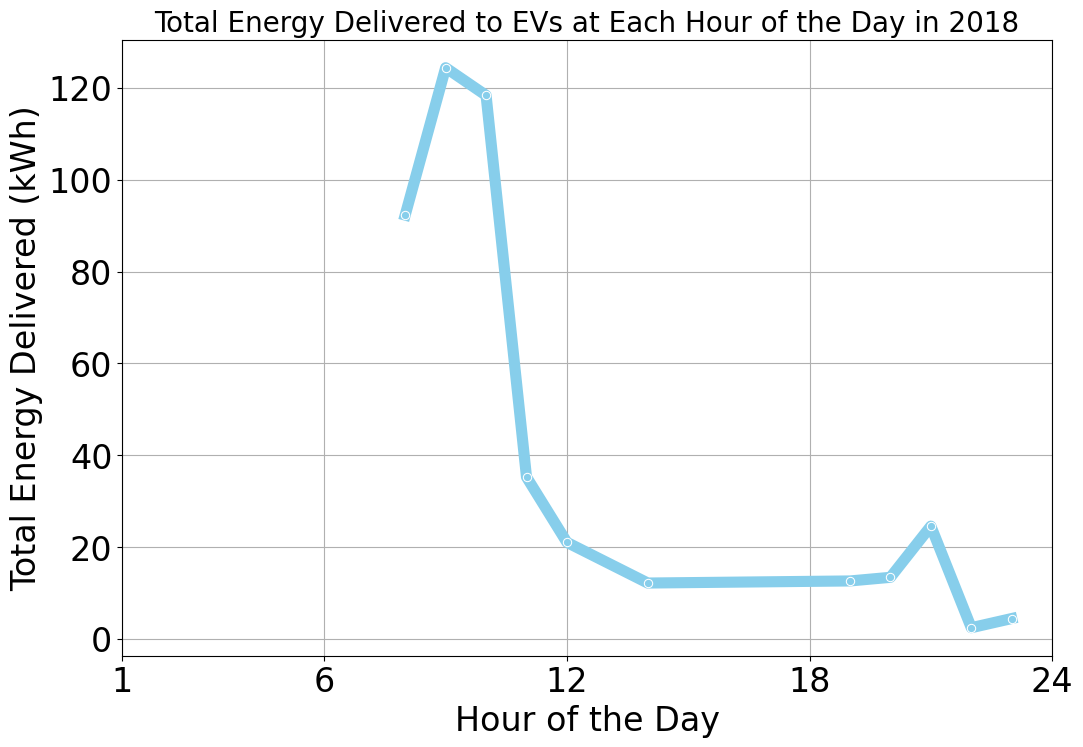

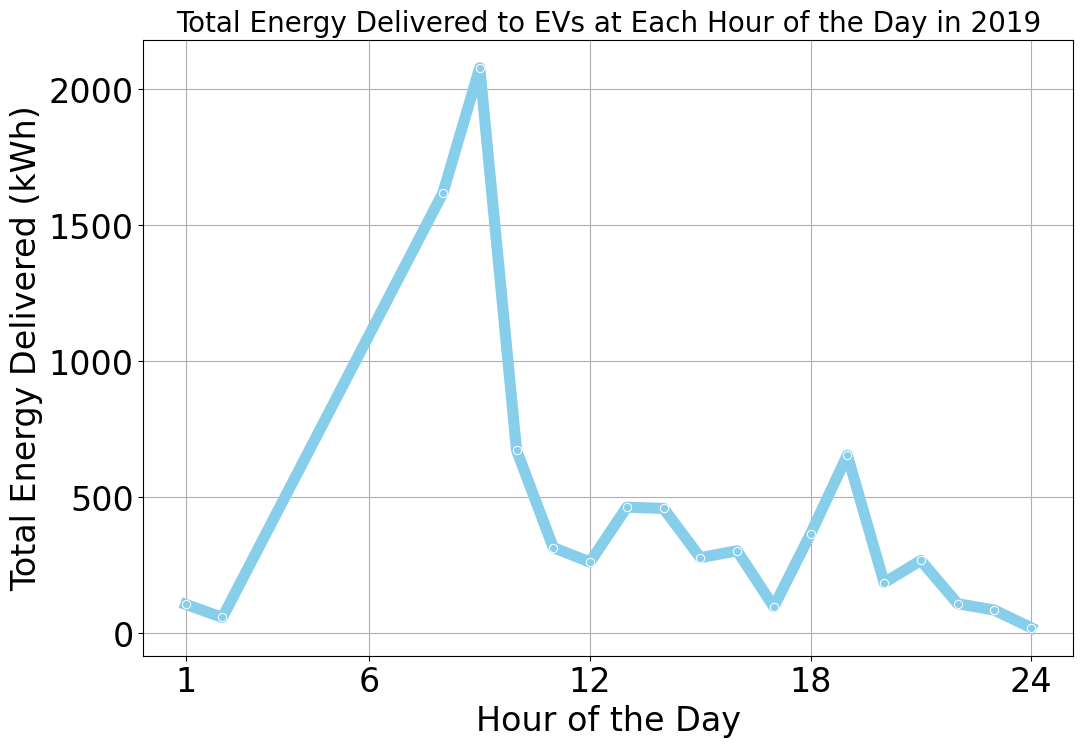

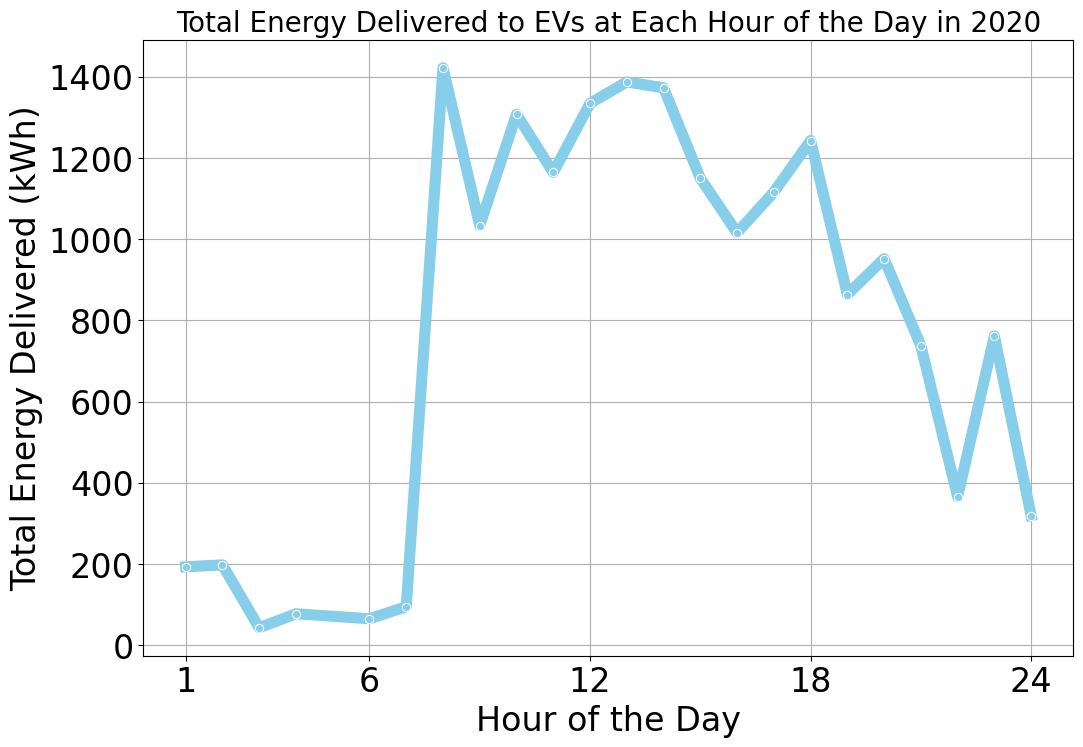

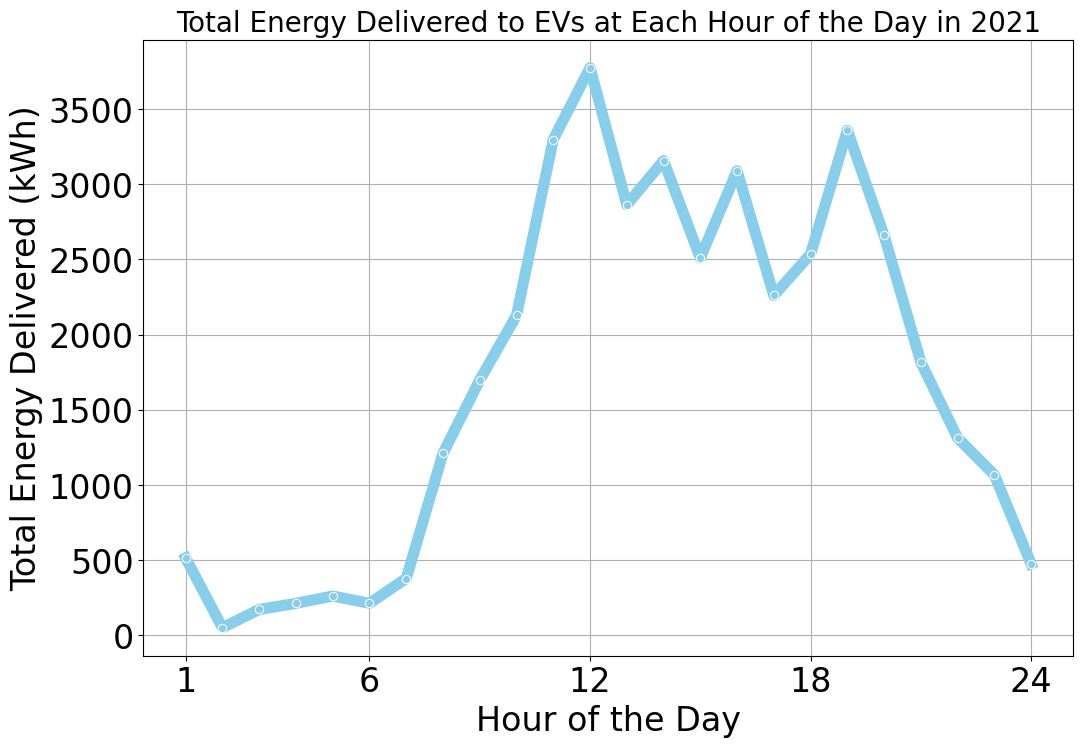

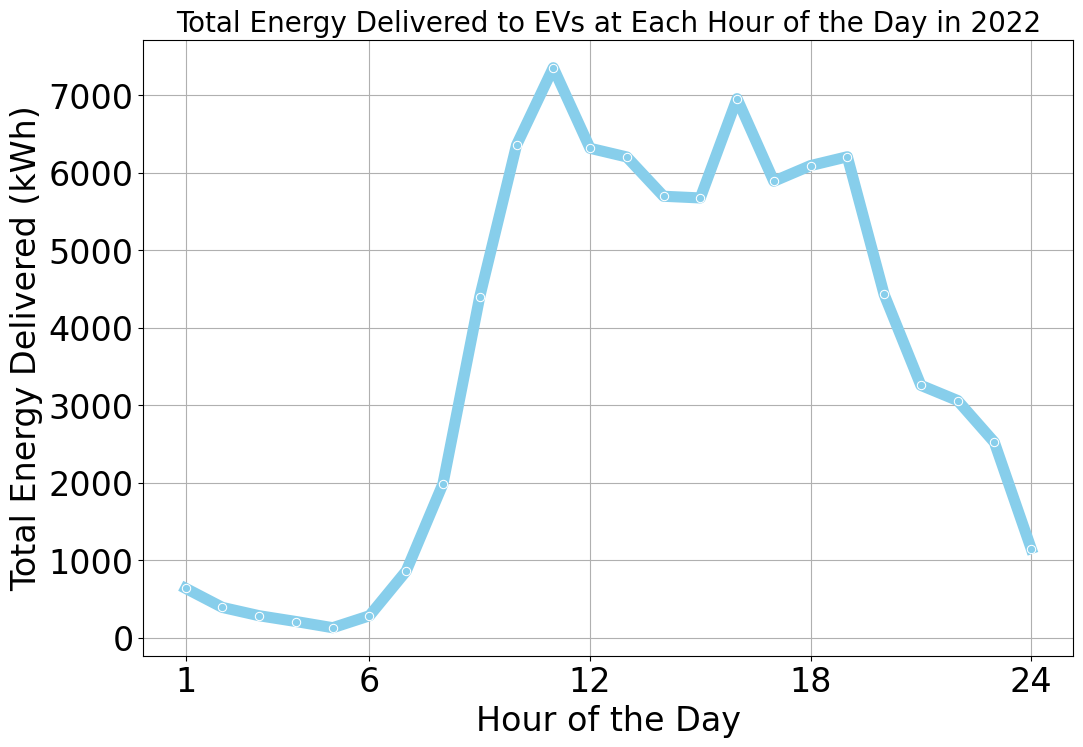

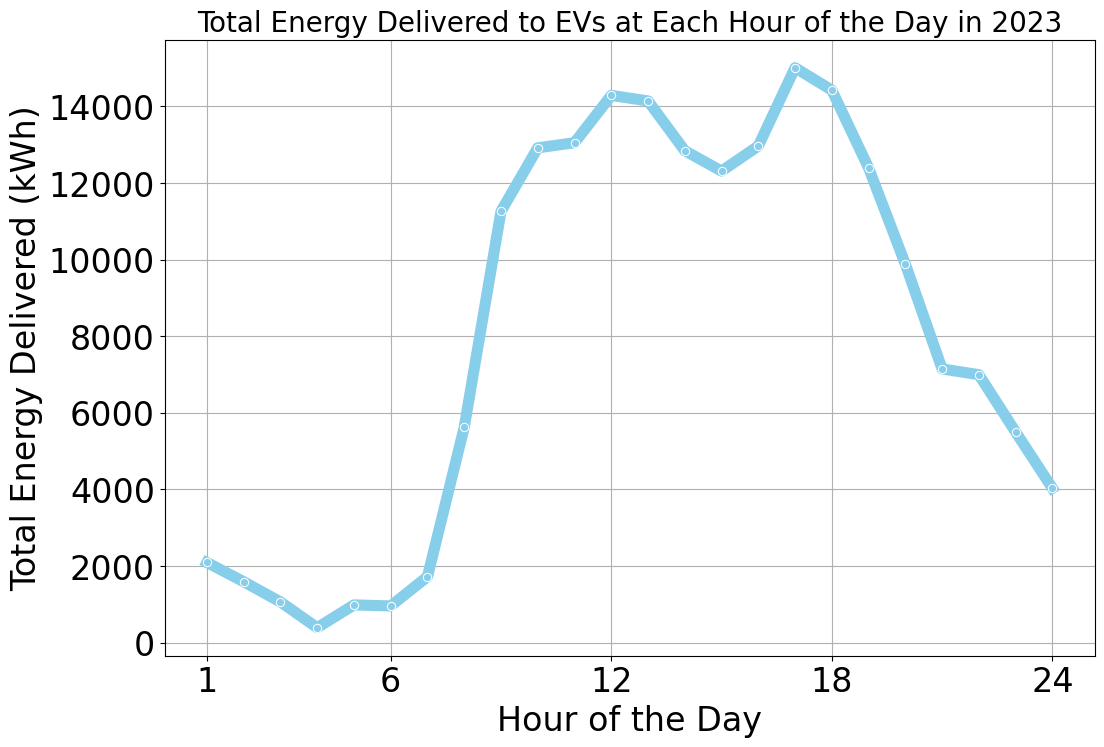

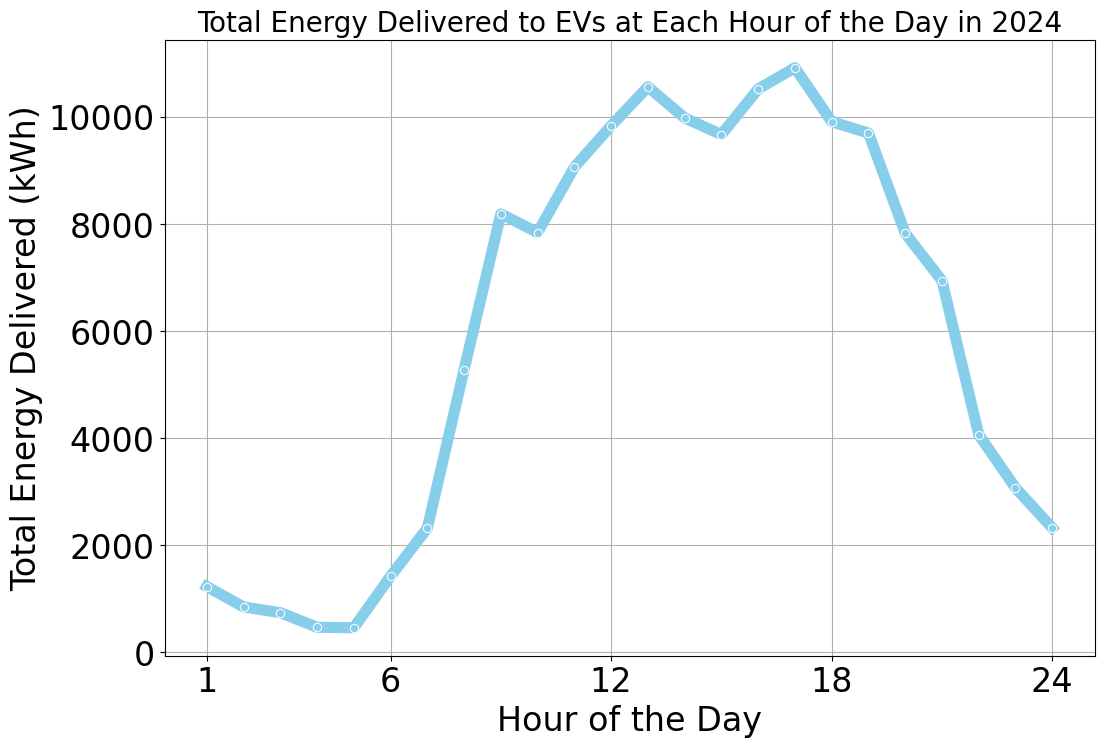

In [39]:


df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  # Extract the year
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  # Extract the hour and shift from 0-23 to 1-24

# Get the unique years in the dataset
years = df['Year'].unique()

# Loop through each year and create a plot
for year in years:
    yearly_data = df[df['Year'] == year]
    hourly_energy = yearly_data.groupby('Hour')['Energy (kWh)'].sum().reset_index()

    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=hourly_energy, x='Hour', y='Energy (kWh)', marker='o', color='skyblue', linewidth=8)  # Adjust linewidth here
    plt.xlabel('Hour of the Day', fontsize=24)  # Increase the font size here
    plt.ylabel('Total Energy Delivered (kWh)', fontsize=24)  # Increase the font size here
    plt.title(f'Total Energy Delivered to EVs at Each Hour of the Day in {year}', fontsize=20)
    plt.xticks([1, 6, 12, 18, 24], fontsize=24)  # Show only specific x-axis labels
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.show()


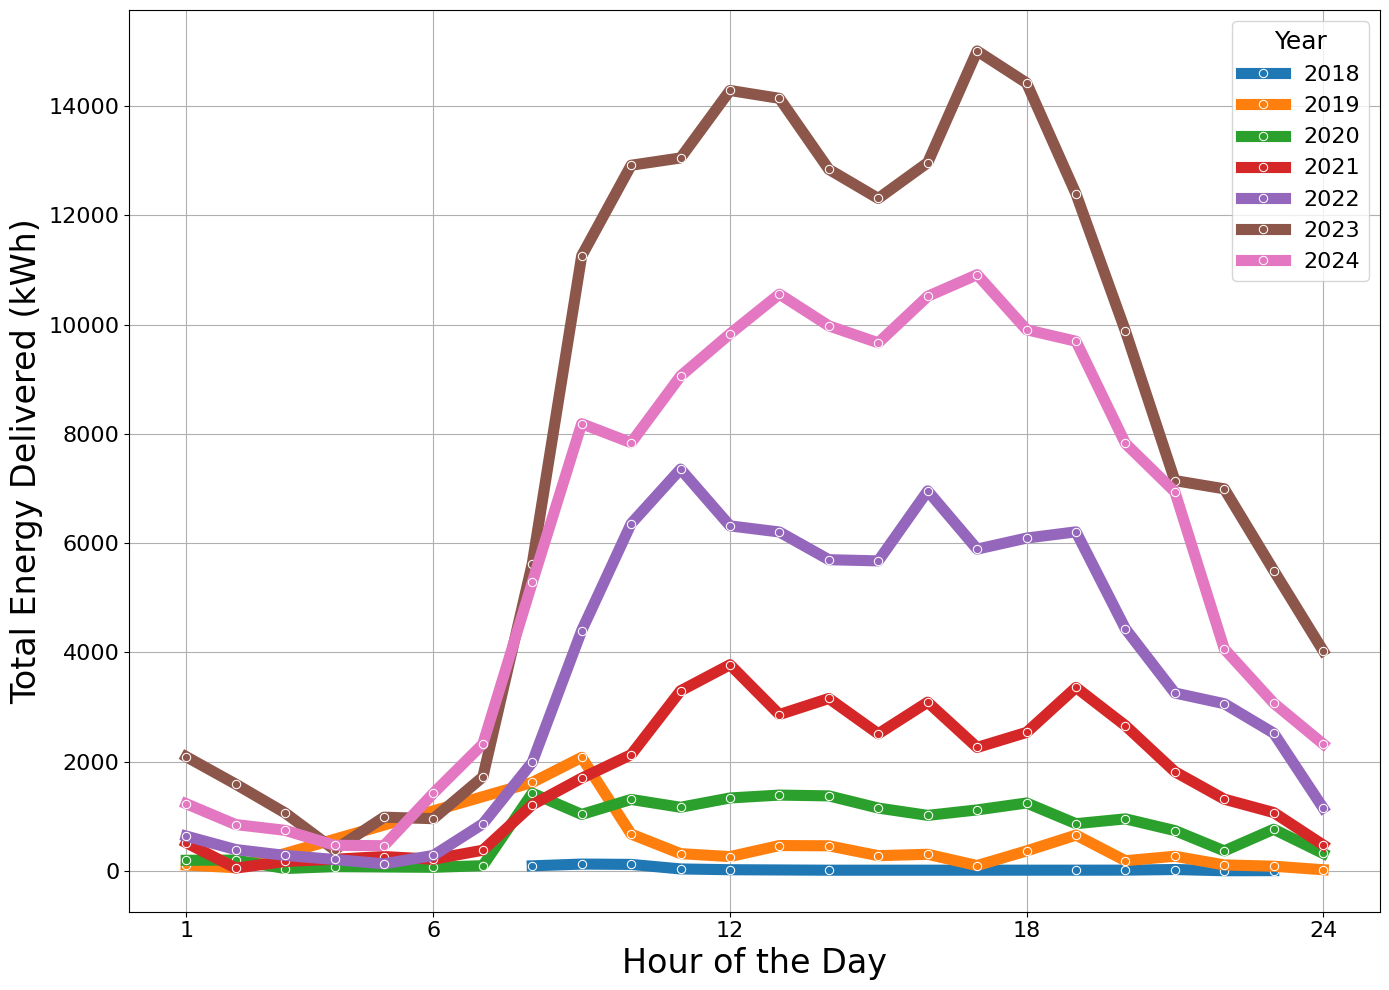

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and loaded with data
df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  # Extract the year
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  # Extract the hour and shift from 0-23 to 1-24

# Get the unique years in the dataset
years = df['Year'].unique()

# Create the plot
plt.figure(figsize=(14, 10))

# Define a color palette
colors = sns.color_palette('tab10', len(years))

# Loop through each year and plot on the same figure
for i, year in enumerate(years):
    yearly_data = df[df['Year'] == year]
    hourly_energy = yearly_data.groupby('Hour')['Energy (kWh)'].sum().reset_index()
    
    sns.lineplot(data=hourly_energy, x='Hour', y='Energy (kWh)', marker='o', color=colors[i], linewidth=8, label=str(year))

# Customize the plot
plt.xlabel('Hour of the Day', fontsize=24)  # Increase the font size here
plt.ylabel('Total Energy Delivered (kWh)', fontsize=24)  # Increase the font size here
#plt.title('Total Energy Delivered to EVs at Each Hour of the Day by Year', fontsize=24)
plt.xticks([1, 6, 12, 18, 24], fontsize=16)  # Show only specific x-axis labels
plt.yticks(fontsize=16)
plt.grid(True)
plt.legend(title='Year', fontsize=16, title_fontsize=18)  # Add legend
plt.tight_layout()

# Show the plot
plt.show()


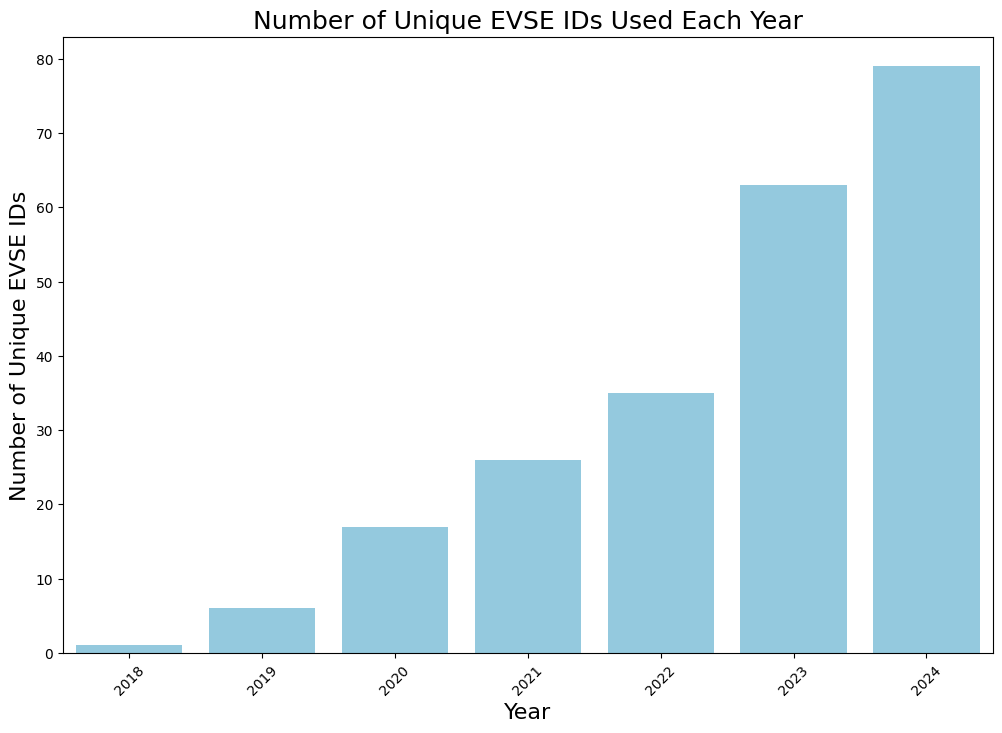

In [40]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])

# Get the number of unique EVSE IDs per year
unique_evse_per_year = df.groupby('Year')['EVSE ID'].nunique().reset_index(name='Unique EVSE Count')

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=unique_evse_per_year, x='Year', y='Unique EVSE Count', color='skyblue')
plt.xlabel('Year', fontsize=16)  # Increase the font size here
plt.ylabel('Number of Unique EVSE IDs', fontsize=16)  # Increase the font size here
plt.title('Number of Unique EVSE IDs Used Each Year', fontsize=18)
plt.xticks(rotation=45)
plt.show()


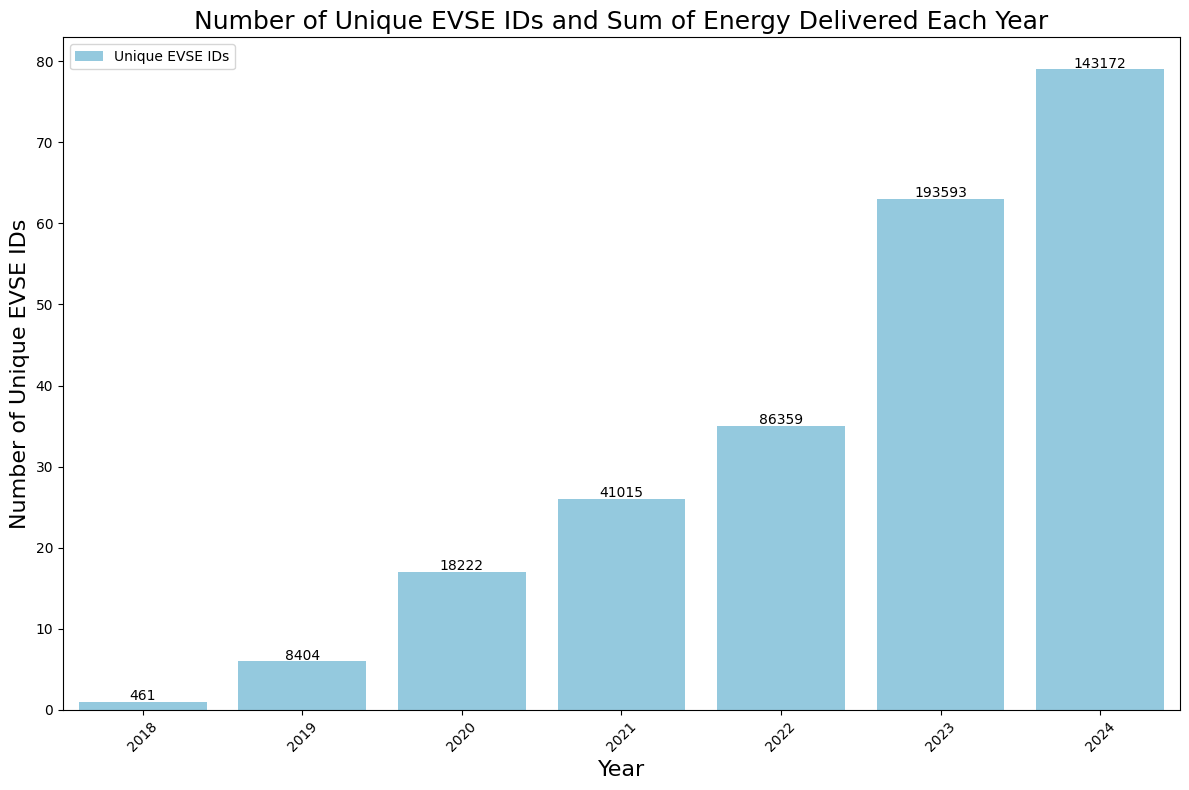

In [41]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  

yearly_stats = df.groupby('Year').agg({'EVSE ID': 'nunique', 'Energy (kWh)': 'sum'}).reset_index()

# Create the plot
plt.figure(figsize=(12, 8))

# Plotting the number of unique EVSE IDs
sns.barplot(data=yearly_stats, x='Year', y='EVSE ID', color='skyblue', label='Unique EVSE IDs')

# Plotting the sum of energy delivered on top of the bars
ax = plt.gca()
for index, row in yearly_stats.iterrows():
    ax.text(row.name, row['EVSE ID'] + 0.2, f'{row["Energy (kWh)"]:.0f}', color='black', ha="center")

# Adding labels and title
plt.xlabel('Year', fontsize=16)
plt.ylabel('Number of Unique EVSE IDs', fontsize=16)
plt.title('Number of Unique EVSE IDs and Sum of Energy Delivered Each Year', fontsize=18)

# Show plot
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1260706599.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=16)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1260706599.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=16)


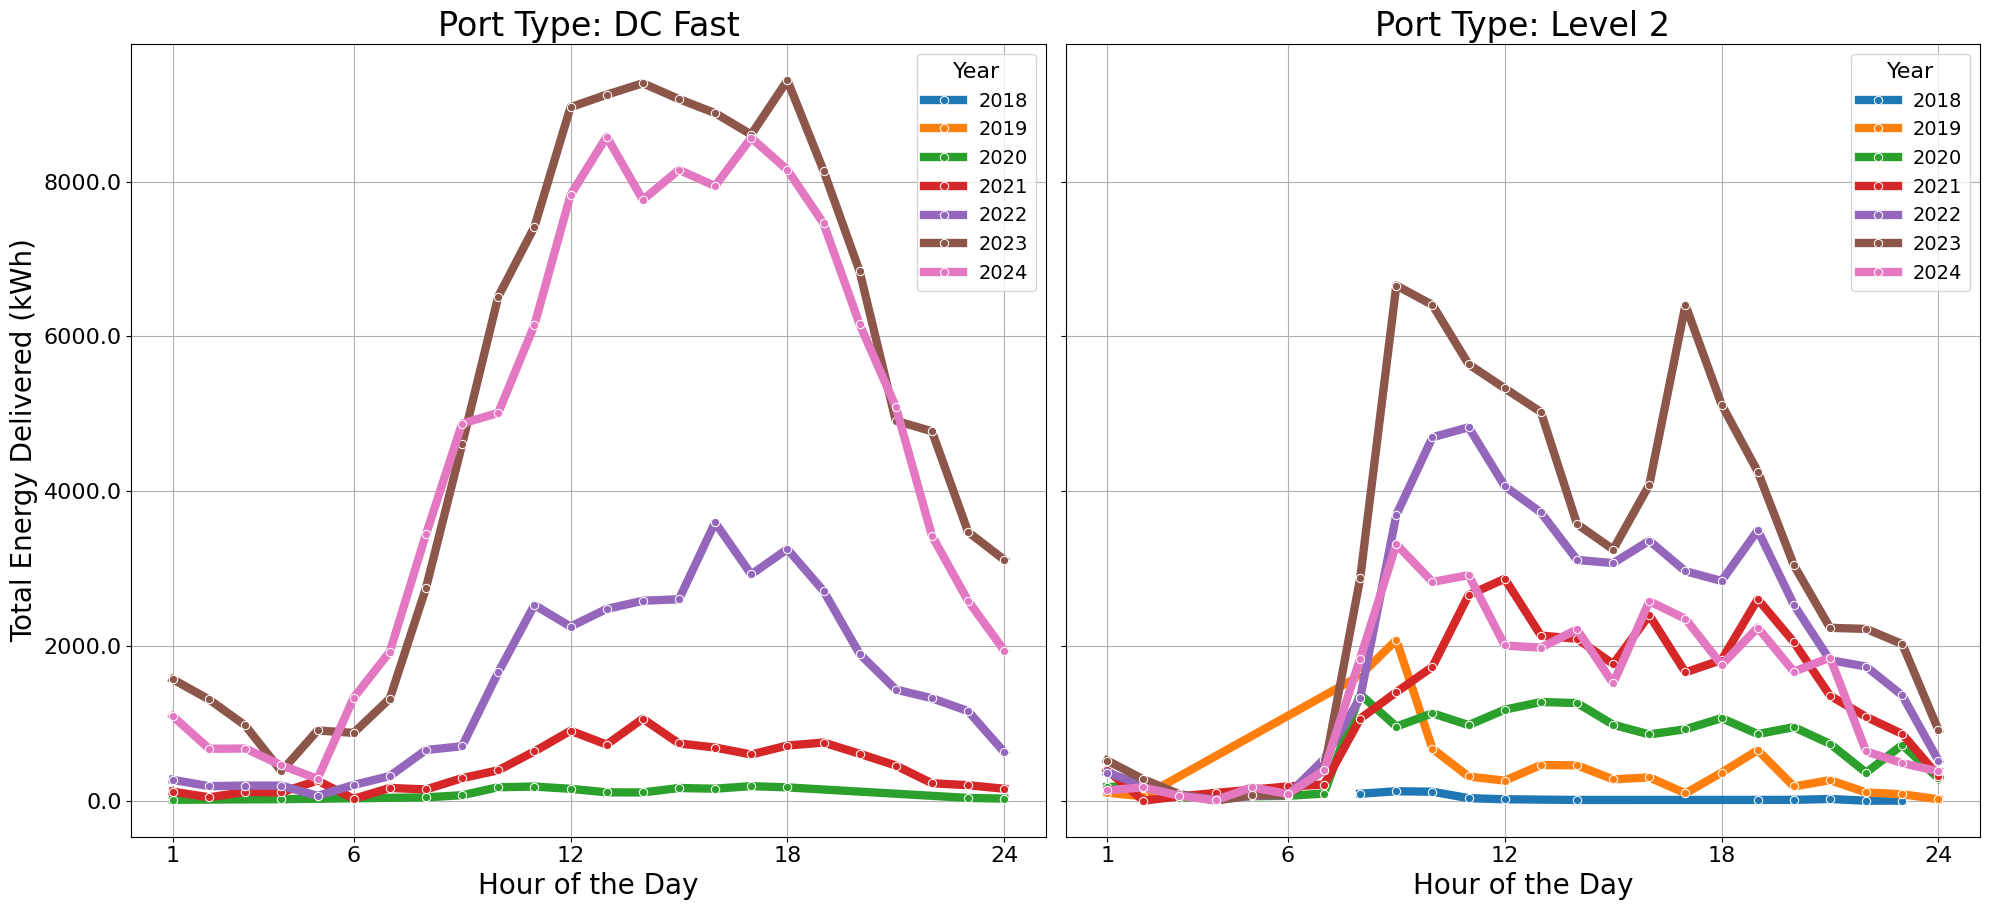

In [72]:

df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  # Extract the year
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  # Extract the hour and shift from 0-23 to 1-24


port_types = ['DC Fast', 'Level 2']

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

colors = sns.color_palette('tab10', len(df['Year'].unique()))

for idx, port_type in enumerate(port_types):
    ax = axes[idx]
    for i, year in enumerate(df['Year'].unique()):
        yearly_data = df[(df['Year'] == year) & (df['Port Type'] == port_type)]
        hourly_energy = yearly_data.groupby('Hour')['Energy (kWh)'].sum().reset_index()
        
        sns.lineplot(data=hourly_energy, x='Hour', y='Energy (kWh)', marker='o', color=colors[i], linewidth=6, label=str(year), ax=ax)
    
    ax.set_title(f'Port Type: {port_type}', fontsize=24)
    ax.set_xlabel('Hour of the Day', fontsize=20)
    if idx == 0:
        ax.set_ylabel('Total Energy Delivered (kWh)', fontsize=20)
    else:
        ax.set_ylabel('')
    ax.set_xticks([1, 6, 12, 18, 24])
    ax.set_xticklabels([1, 6, 12, 18, 24], fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.grid(True)
    ax.legend(title='Year', fontsize=14, title_fontsize=16)


#fig.suptitle('Total Energy Delivered to EVs at Each Hour of the Day by Year and Port Type', fontsize=28)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


TypeError: 'float' object cannot be interpreted as an integer

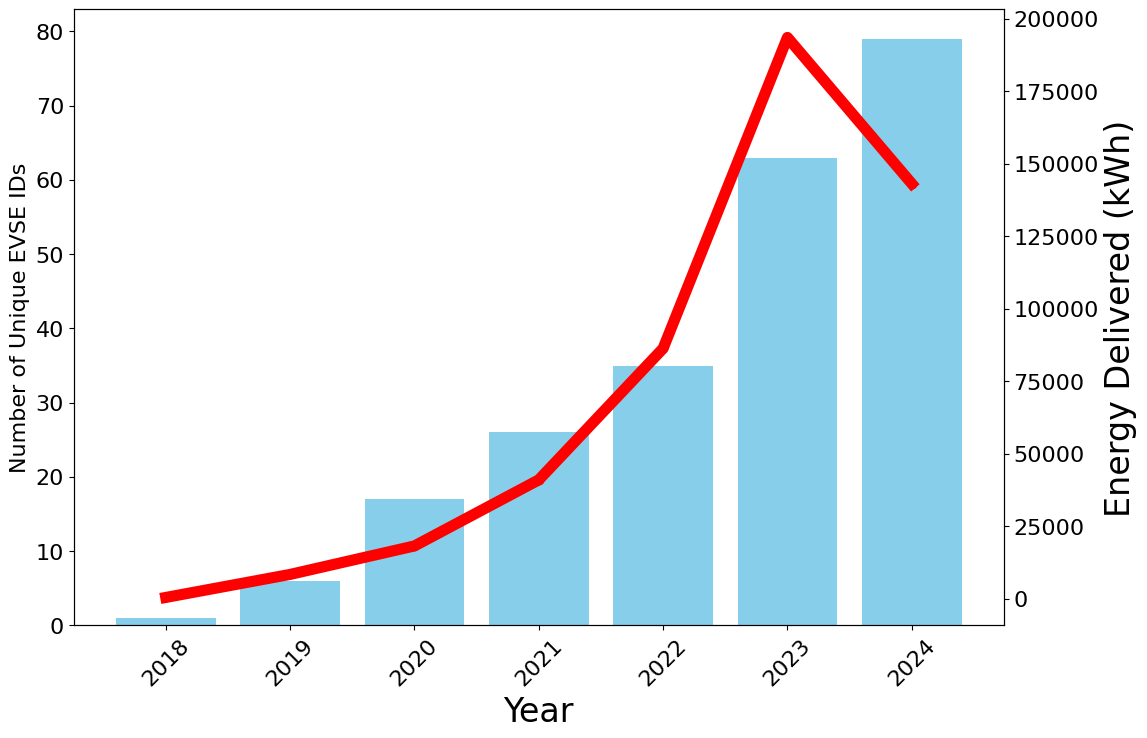

In [66]:

import matplotlib.pyplot as plt

# Create a figure and axis objects using subplots()
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the number of unique EVSE IDs on the primary y-axis
ax1.bar(yearly_stats['Year'], yearly_stats['EVSE ID'], color='skyblue', label='Unique EVSE IDs')
ax1.set_xlabel('Year', fontsize=24)
ax1.set_ylabel('Number of Unique EVSE IDs', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=16)  # Adjust x-axis label size
ax1.tick_params(axis='y', labelsize=16)  # Adjust y-axis tick label size
ax1.set_yticks(range(0, max(yearly_stats['EVSE ID']) + 10, 10))  # Set y-axis ticks for ax1

# Create a secondary y-axis for the sum of energy delivered
ax2 = ax1.twinx()
ax2.plot(yearly_stats['Year'], yearly_stats['Energy (kWh)'], color='red', marker='o', linewidth=8, label='Energy Delivered (kWh)')
ax2.set_ylabel('Energy Delivered (kWh)', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)  # Adjust y-axis tick label size
ax2.set_yticks(range(0, max(yearly_stats['Energy (kWh)']) + 1000, 1000))  # Set y-axis ticks for ax2

# Add labels and title
plt.title('Number of Unique EVSE IDs and Sum of Energy Delivered Each Year', fontsize=24)

# Add legends for both axes
ax1.legend(loc='upper left', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()


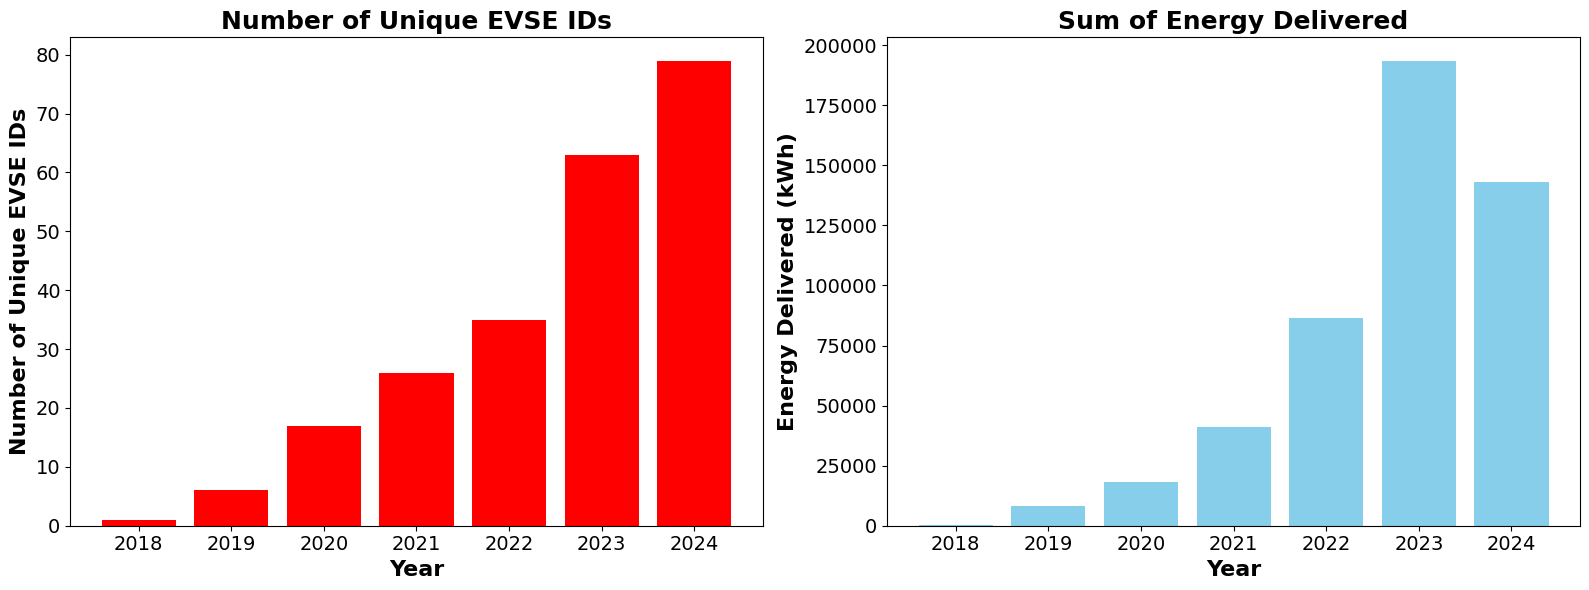

In [61]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the number of unique EVSE IDs
ax1.bar(yearly_stats['Year'], yearly_stats['EVSE ID'], color='red')
ax1.set_xlabel('Year', fontsize=16, fontweight='bold')
ax1.set_ylabel('Number of Unique EVSE IDs', fontsize=16, fontweight='bold')
ax1.tick_params(axis='both', labelsize=14)
ax1.set_title('Number of Unique EVSE IDs', fontsize=18, fontweight='bold')

# Plot the sum of energy delivered
ax2.bar(yearly_stats['Year'], yearly_stats['Energy (kWh)'], color='skyblue')
ax2.set_xlabel('Year', fontsize=16, fontweight='bold')
ax2.set_ylabel('Energy Delivered (kWh)', fontsize=16, fontweight='bold')
ax2.tick_params(axis='both', labelsize=14)
ax2.set_title('Sum of Energy Delivered', fontsize=18, fontweight='bold')

#plt.suptitle('Yearly Statistics', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

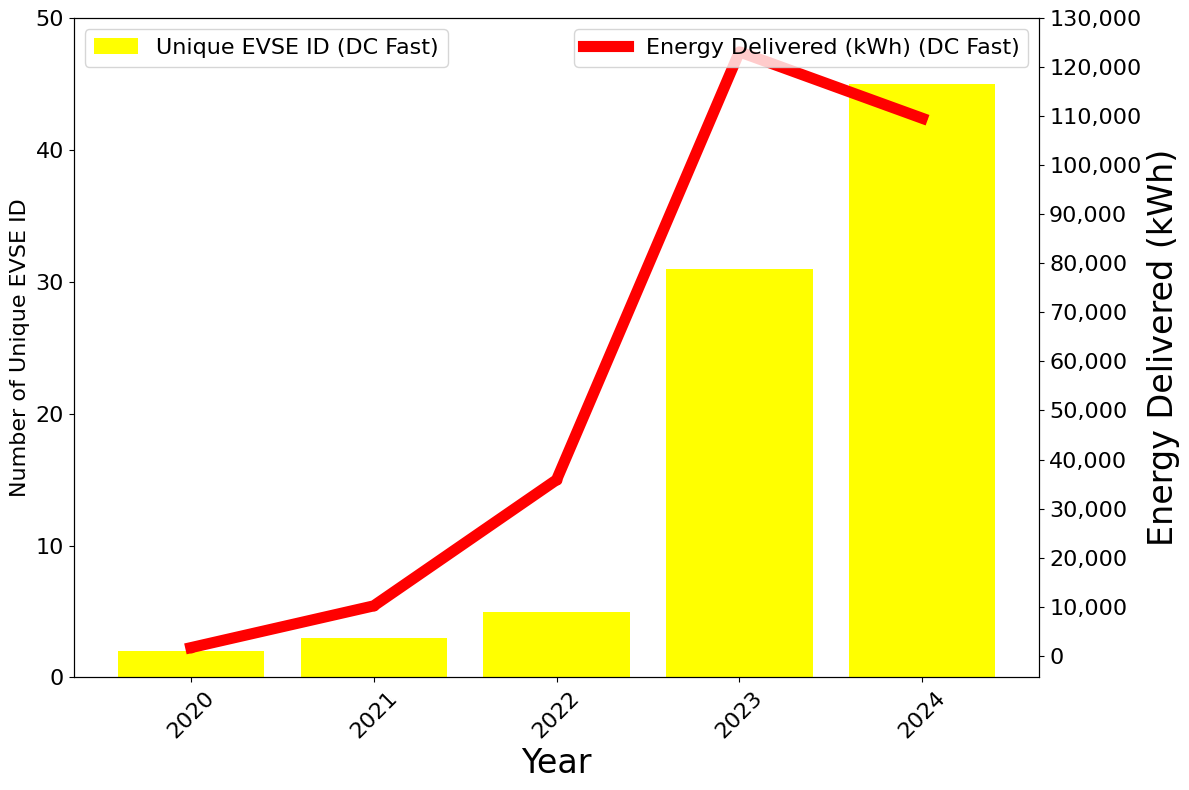

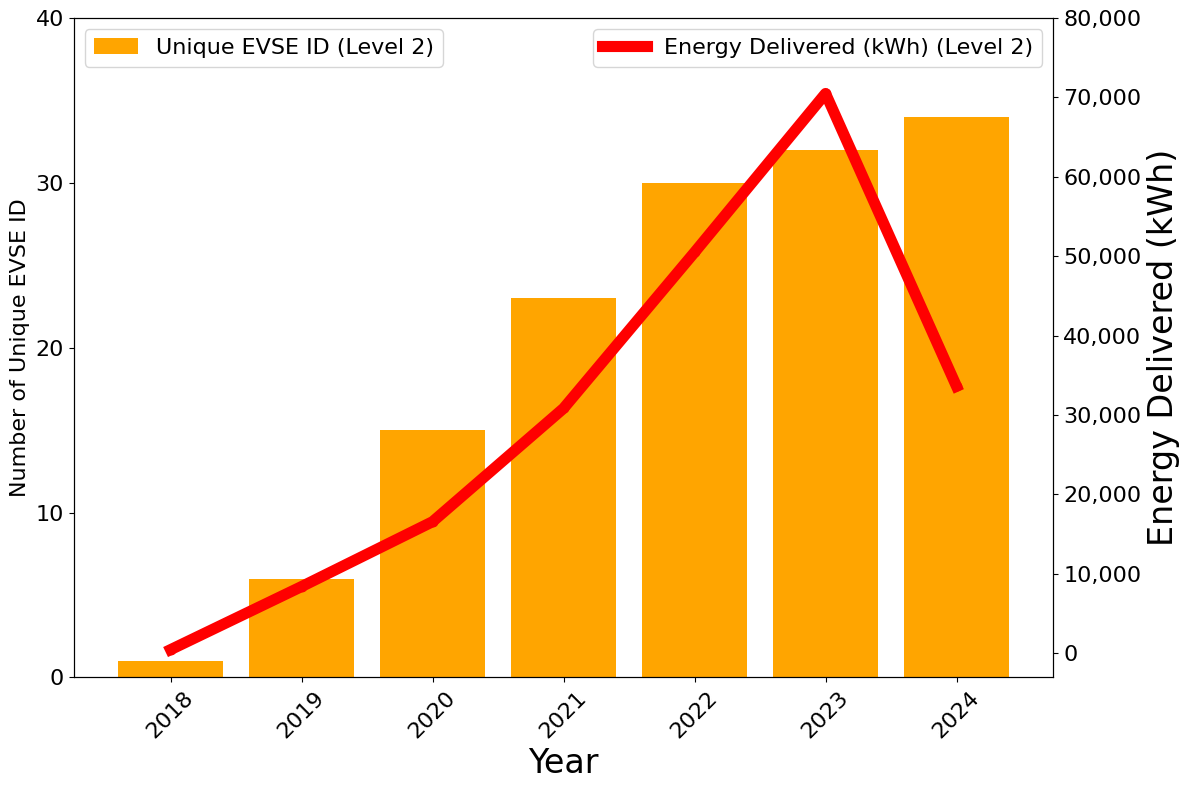

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame setup (Replace this with your actual DataFrame loading)
# df = pd.read_csv('your_data.csv')

# Ensure datetime conversion and feature extraction
df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  # Extract the year
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  # Extract the hour and shift from 0-23 to 1-24

# Verify the existence of the 'Port Type' column
if 'Port Type' not in df.columns:
    raise KeyError("The column 'Port Type' does not exist in the DataFrame.")

# Filter for 'DC Fast'
dc_fast = df[df['Port Type'] == 'DC Fast']
dc_fast_yearly_stats = dc_fast.groupby('Year').agg({'EVSE ID': pd.Series.nunique, 'Energy (kWh)': 'sum'}).reset_index()

# Filter for 'Level 2'
level_2 = df[df['Port Type'] == 'Level 2']
level_2_yearly_stats = level_2.groupby('Year').agg({'EVSE ID': pd.Series.nunique, 'Energy (kWh)': 'sum'}).reset_index()

# Function to calculate suitable y-ticks for energy
def calculate_yticks(max_value, step):
    max_int = int(max_value) + (step - int(max_value) % step)
    return range(0, max_int + step, step)

# Plot for 'DC Fast'
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(dc_fast_yearly_stats['Year'], dc_fast_yearly_stats['EVSE ID'], color='yellow', label='Unique EVSE ID (DC Fast)')
ax1.set_xlabel('Year', fontsize=24)
ax1.set_ylabel('Number of Unique EVSE ID', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_yticks(range(0, max(dc_fast_yearly_stats['EVSE ID']) + 10, 10))

# Create a secondary y-axis for energy delivered
ax2 = ax1.twinx()
ax2.plot(dc_fast_yearly_stats['Year'], dc_fast_yearly_stats['Energy (kWh)'], color='red', marker='o', linewidth=8, label='Energy Delivered (kWh) (DC Fast)')
ax2.set_ylabel('Energy Delivered (kWh)', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)

# Set limited y-ticks for better readability on the energy axis
yticks = calculate_yticks(max(dc_fast_yearly_stats['Energy (kWh)']), 10000)
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{y:,}' for y in yticks])

#plt.title('DC Fast: Number of Unique EVSE IDs and Sum of Energy Delivered Each Year', fontsize=24)
ax1.legend(loc='upper left', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

# Plot for 'Level 2'
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(level_2_yearly_stats['Year'], level_2_yearly_stats['EVSE ID'], color='orange', label='Unique EVSE ID (Level 2)')
ax1.set_xlabel('Year', fontsize=24)
ax1.set_ylabel('Number of Unique EVSE ID', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_yticks(range(0, max(level_2_yearly_stats['EVSE ID']) + 10, 10))

# Create a secondary y-axis for energy delivered
ax2 = ax1.twinx()
ax2.plot(level_2_yearly_stats['Year'], level_2_yearly_stats['Energy (kWh)'], color='red', marker='o', linewidth=8, label='Energy Delivered (kWh) (Level 2)')
ax2.set_ylabel('Energy Delivered (kWh)', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)

# Set limited y-ticks for better readability on the energy axis
yticks = calculate_yticks(max(level_2_yearly_stats['Energy (kWh)']), 10000)
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{y:,}' for y in yticks])

#plt.title('Level 2: Number of Unique EVSE IDs and Sum of Energy Delivered Each Year', fontsize=24)
ax1.legend(loc='upper left', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()


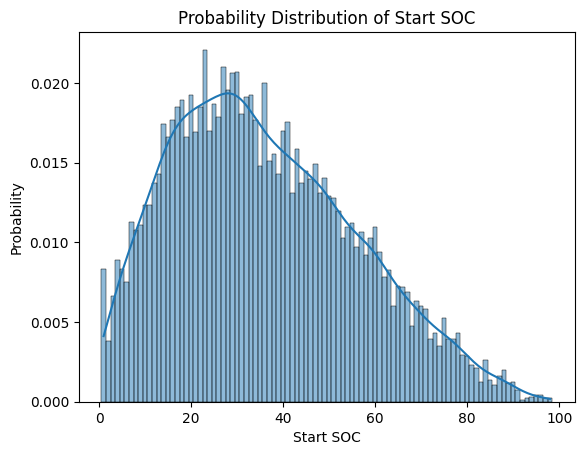

In [136]:


soc_diff_without_zeros = df[df['Start SOC'] != 0]
sns.histplot(data=soc_diff_without_zeros, x='Start SOC', kde=True, stat='probability', discrete=True)
plt.xlabel('Start SOC')
plt.ylabel('Probability')
plt.title('Probability Distribution of Start SOC')
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1577089667.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soc_diff_without_zeros['Start SOC Bin'] = pd.cut(soc_diff_without_zeros['Start SOC'], bins=bins, labels=labels, include_lowest=True)


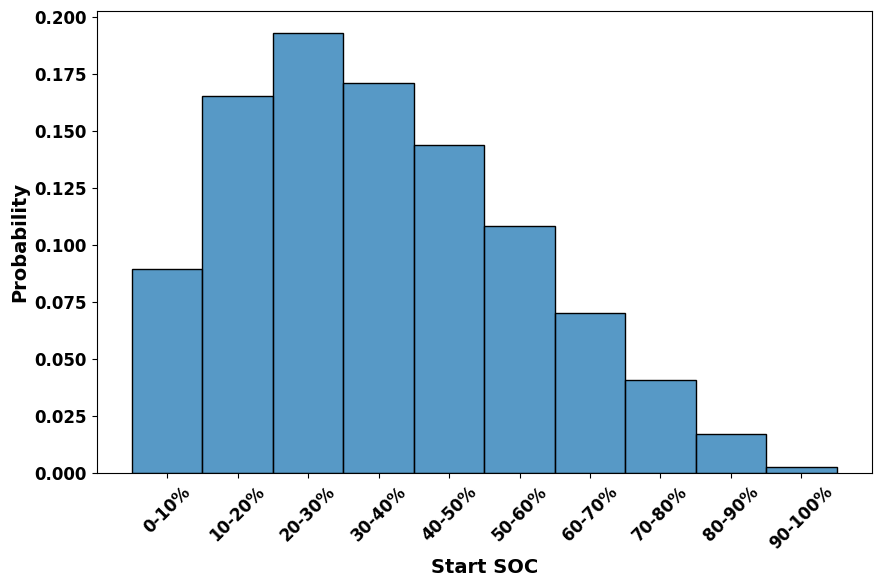

In [157]:


bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

soc_diff_without_zeros['Start SOC Bin'] = pd.cut(soc_diff_without_zeros['Start SOC'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 6))
sns.histplot(data=soc_diff_without_zeros, x='Start SOC Bin', stat='probability', discrete=True)

# Customizing the font properties
plt.xlabel('Start SOC', fontsize=14, fontweight='bold')
plt.ylabel('Probability', fontsize=14, fontweight='bold')
#plt.title('Probability Distribution of Start SOC (DCFC)', fontsize=16, fontweight='bold')

# Rotate the x-axis labels
plt.xticks(fontsize=12, fontweight='bold', rotation=45)
plt.yticks(fontsize=12, fontweight='bold')

plt.show()


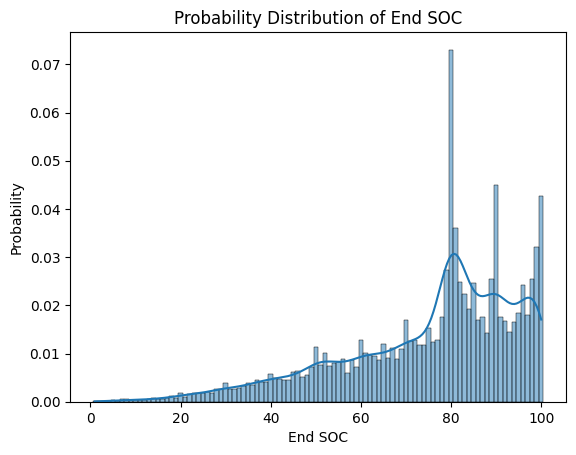

In [403]:
end_soc_diff_without_zeros = df[df['End SOC'] != 0]
sns.histplot(data=end_soc_diff_without_zeros, x='End SOC', kde=True, stat='probability', discrete=True)
plt.xlabel('End SOC')
plt.ylabel('Probability')
plt.title('Probability Distribution of End SOC')
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\988502448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soc_diff_without_zeros['End SOC Bin'] = pd.cut(soc_diff_without_zeros['End SOC'], bins=bins, labels=labels, include_lowest=True)


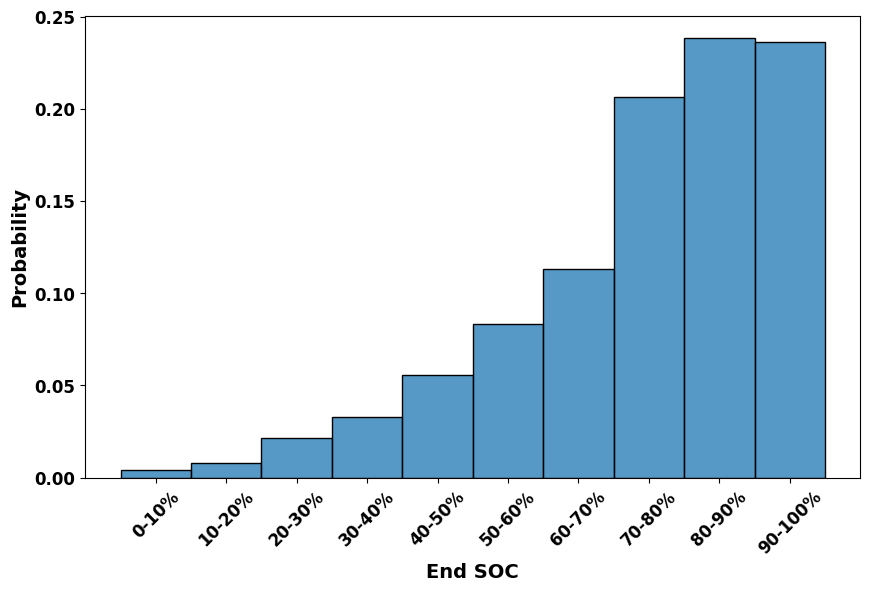

In [155]:

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

soc_diff_without_zeros['End SOC Bin'] = pd.cut(soc_diff_without_zeros['End SOC'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 6))
sns.histplot(data=soc_diff_without_zeros, x='End SOC Bin', stat='probability', discrete=True)

# Customizing the font properties
plt.xlabel('End SOC', fontsize=14, fontweight='bold')
plt.ylabel('Probability', fontsize=14, fontweight='bold')
#plt.title('Probability Distribution of End SOC (DCFC)', fontsize=16, fontweight='bold')

# Rotate the x-axis labels
plt.xticks(fontsize=12, fontweight='bold', rotation=45)
plt.yticks(fontsize=12, fontweight='bold')

plt.show()


C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\4270614562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soc_diff_without_zeros['Start SOC Bin'] = pd.cut(soc_diff_without_zeros['Start SOC'], bins=bins, labels=labels, include_lowest=True)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\4270614562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soc_diff_without_zeros['End SOC Bin'] = pd.cut(soc_diff_without_zeros['End SOC'], bins=bins, labels=labels, include_lowest=True)


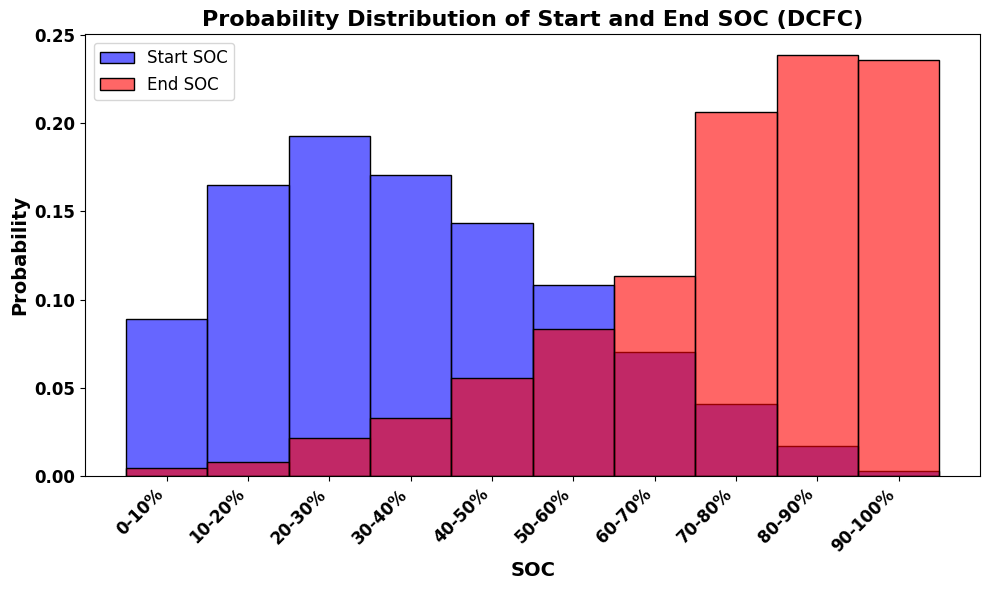

In [159]:

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Create bins for Start SOC and End SOC
soc_diff_without_zeros['Start SOC Bin'] = pd.cut(soc_diff_without_zeros['Start SOC'], bins=bins, labels=labels, include_lowest=True)
soc_diff_without_zeros['End SOC Bin'] = pd.cut(soc_diff_without_zeros['End SOC'], bins=bins, labels=labels, include_lowest=True)

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot Start SOC
sns.histplot(data=soc_diff_without_zeros, x='Start SOC Bin', stat='probability', discrete=True, 
             color='blue', alpha=0.6, label='Start SOC')

# Plot End SOC
sns.histplot(data=soc_diff_without_zeros, x='End SOC Bin', stat='probability', discrete=True, 
             color='red', alpha=0.6, label='End SOC')

# Customizing the font properties
plt.xlabel('SOC', fontsize=14, fontweight='bold')
plt.ylabel('Probability', fontsize=14, fontweight='bold')
plt.title('Probability Distribution of Start and End SOC (DCFC)', fontsize=16, fontweight='bold')

# Rotate the x-axis labels
plt.xticks(fontsize=12, fontweight='bold', rotation=45, ha='right')
plt.yticks(fontsize=12, fontweight='bold')

# Add legend
plt.legend(fontsize=12)

# Adjust layout to prevent cut-off labels
plt.tight_layout()

plt.show()

In [160]:
# Count the number of rows where 'Energy (kWh)' is less than 1
count = df[df['Energy (kWh)'] < 1].shape[0]
print(f"Number of rows where 'Energy (kWh)' is less than 1: {count}")


# Delete these rows
#df = df[df['Energy (kWh)'] >= 1]

Number of rows where 'Energy (kWh)' is less than 1: 918


In [36]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from scipy.stats import beta, multivariate_normal

# Prepare the data
continuous_vars = ['Start SOC', 'End SOC', 'Total Duration', 'Charging Time', 'parking_time', 'Energy (kWh)', 'Fee']
discrete_vars = ['User ID', 'Day_of_Week']  
datetime_vars = ['Start_Time_EST', 'End_Time_EST', 'End_Charging_Time_EST']

# Handle missing values
df = df.dropna(subset=continuous_vars + discrete_vars + datetime_vars)

# Convert datetime variables to numeric representations
for var in datetime_vars:
    df[var + '_hour'] = df[var].dt.hour
    df[var + '_day'] = df[var].dt.day
    df[var + '_month'] = df[var].dt.month

# Update the discrete_vars list with the new numeric features
discrete_vars.extend([var + '_hour' for var in datetime_vars])
discrete_vars.extend([var + '_day' for var in datetime_vars])
discrete_vars.extend([var + '_month' for var in datetime_vars])

# Convert categorical variables to numeric using one-hot encoding
df = pd.get_dummies(df, columns=discrete_vars)

# Update the discrete_vars list with the one-hot encoded column names
discrete_vars = [col for col in df.columns if col.startswith(tuple(discrete_vars))]

# Normalize continuous variables
df[continuous_vars] = (df[continuous_vars] - df[continuous_vars].min()) / (df[continuous_vars].max() - df[continuous_vars].min())

# Create input layers for each variable
input_layers = []
for var in continuous_vars + discrete_vars:
    input_layer = Input(shape=(1,), name=var)
    input_layers.append(input_layer)

# Concatenate input layers
concat_layer = Concatenate()(input_layers)

# Define hidden layers
hidden_layer1 = Dense(64, activation='relu')(concat_layer)
hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)

# Define output layers for each continuous variable
output_layers = []
for i, var in enumerate(continuous_vars):
    if var in ['Start SOC', 'End SOC']:
        # Use Beta distribution for SOC variables
        alpha_layer = Dense(1, activation='softplus')(hidden_layer2)
        beta_layer = Dense(1, activation='softplus')(hidden_layer2)
        output_layer = Concatenate(name=f"{var}_output_{i}")([alpha_layer, beta_layer])
    else:
        # Use Gaussian Mixture Model for other continuous variables
        mu_layer = Dense(3)(hidden_layer2)  # 3 components in the mixture
        sigma_layer = Dense(3, activation='softplus')(hidden_layer2)
        mixing_layer = Dense(3, activation='softmax')(hidden_layer2)
        output_layer = Concatenate(name=f"{var}_output_{i}")([mu_layer, sigma_layer, mixing_layer])
    output_layers.append(output_layer)

# Define the model
model = Model(inputs=input_layers, outputs=output_layers)

# Compile the model with different loss functions for each output
loss_functions = []
for var in continuous_vars:
    if var in ['Start SOC', 'End SOC']:
        loss_functions.append('mse')  # Mean Squared Error for Beta distribution variables
    else:
        loss_functions.append('mse')  # Mean Squared Error for Gaussian Mixture Model variables

model.compile(optimizer=Adam(learning_rate=0.001), loss=loss_functions)

# Define learning rate decay
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr *= 0.1
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Prepare the input data for training
input_data = [df[var].values.reshape(-1, 1) for var in continuous_vars + discrete_vars]
output_data = [df[var].values.reshape(-1, 1) for var in continuous_vars]

# Train the model
model.fit(input_data, output_data, epochs=100, batch_size=32, callbacks=[lr_callback])

# Generate synthetic data using Gibbs sampling
num_samples = 1000
generated_data = np.zeros((num_samples, len(continuous_vars) + len(discrete_vars)))

# Initialize the generated data with random values
for i, var in enumerate(continuous_vars + discrete_vars):
    generated_data[:, i] = np.random.rand(num_samples, 1)

# Perform Gibbs sampling
for _ in range(100):  # Number of Gibbs sampling iterations
    for i, var in enumerate(continuous_vars):
        # Get the current values of other variables
        other_vars = [generated_data[:, j].reshape(-1, 1) for j in range(len(continuous_vars) + len(discrete_vars)) if j != i]
        
        # Predict the parameters of the probability distribution for the current variable
        params = model.predict(other_vars + [generated_data[:, i].reshape(-1, 1)])
        
        if var in ['Start SOC', 'End SOC']:
            # Sample from Beta distribution
            alpha, beta = params[0].flatten(), params[1].flatten()
            generated_data[:, i] = beta.rvs(alpha, beta, size=(num_samples, 1))
        else:
            # Sample from Gaussian Mixture Model
            mu, sigma, mixing = params[0], params[1], params[2]
            components = np.random.choice(3, size=num_samples, p=mixing[0])
            generated_data[:, i] = multivariate_normal.rvs(mu[components], sigma[components], size=(num_samples, 1))

# Convert the generated data back to the original scale
generated_df = pd.DataFrame(columns=continuous_vars + discrete_vars)
for var in continuous_vars:
    generated_df[var] = generated_data[:, continuous_vars.index(var)] * (df[var].max() - df[var].min()) + df[var].min()
for var in discrete_vars:
    generated_df[var] = generated_data[:, len(continuous_vars) + discrete_vars.index(var)]

# Print the generated data
print(generated_df.head())

Epoch 1/100


ValueError: Exception encountered when calling Functional.call().

[1m'Energy (kWh)_output_5' is not a valid scope name. A scope name has to match the following pattern: ^[A-Za-z0-9_.\\/>-]*$[0m

Arguments received by Functional.call():
  • inputs=('tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)', 'tf.Tensor(shape=(None, 1), dtype=bool)')
  • training=True
  • mask=('None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None')

In [232]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from scipy.stats import beta as beta_dist, multivariate_normal

# Example of loading a DataFrame (assuming df is loaded from a CSV or other source)
# df = pd.read_csv('your_dataset.csv')

# Prepare the data
continuous_vars = ['Start SOC', 'End SOC', 'Total Duration', 'Charging Time', 'parking_time', 'Energy (kWh)', 'Fee']
discrete_vars = ['Day_of_Week']  
datetime_vars = ['Start_Time_EST', 'End_Time_EST', 'End_Charging_Time_EST']

# Handle missing values
df = df.dropna(subset=continuous_vars + discrete_vars + datetime_vars)

# Convert datetime variables to numeric representations
for var in datetime_vars:
    df[var + '_hour'] = df[var].dt.hour
    df[var + '_day'] = df[var].dt.day
    df[var + '_month'] = df[var].dt.month

# Update the discrete_vars list with the new numeric features
discrete_vars.extend([var + '_hour' for var in datetime_vars])
discrete_vars.extend([var + '_day' for var in datetime_vars])
discrete_vars.extend([var + '_month' for var in datetime_vars])

# Convert categorical variables to numeric using one-hot encoding
df = pd.get_dummies(df, columns=discrete_vars)

# Update the discrete_vars list with the one-hot encoded column names
discrete_vars = [col for col in df.columns if col.startswith(tuple(discrete_vars))]

# Normalize continuous variables
df[continuous_vars] = (df[continuous_vars] - df[continuous_vars].min()) / (df[continuous_vars].max() - df[continuous_vars].min())

# Create input layers for each variable
input_layers = []
input_dict = {}
for var in continuous_vars + discrete_vars:
    input_layer = Input(shape=(1,), name=var)
    input_layers.append(input_layer)
    input_dict[var] = input_layer

# Concatenate input layers
concat_layer = Concatenate()(input_layers)

# Define hidden layers
hidden_layer1 = Dense(64, activation='relu')(concat_layer)
hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)

# Define output layers for each continuous variable
output_layers = []
for var in continuous_vars:
    if var in ['Start SOC', 'End SOC']:
        # Use Beta distribution for SOC variables
        alpha_layer = Dense(1, activation='softplus')(hidden_layer2)
        beta_layer = Dense(1, activation='softplus')(hidden_layer2)
        output_layer = Concatenate(name=f"{var}_output")([alpha_layer, beta_layer])
        output_layers.append(output_layer)
    else:
        # Use Gaussian Mixture Model for other continuous variables
        mu_layer = Dense(3)(hidden_layer2)  # 3 components in the mixture
        sigma_layer = Dense(3, activation='softplus')(hidden_layer2)
        mixing_layer = Dense(3, activation='softmax')(hidden_layer2)
        output_layer = Concatenate(name=f"{var}_output")([mu_layer, sigma_layer, mixing_layer])
        output_layers.append(output_layer)

# Define the model
model = Model(inputs=input_layers, outputs=output_layers)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Define learning rate decay
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr *= 0.1
    return lr

lr_callback = LearningRateScheduler(lr_scheduler)

# Prepare the input data for training
input_data = [df[var].values.reshape(-1, 1) for var in continuous_vars + discrete_vars]
output_data = []
for var in continuous_vars:
    if var in ['Start SOC', 'End SOC']:
        # Dummy values for output; replace with actual target values if available
        output_data.append(np.zeros((df.shape[0], 2)))  # Alpha and Beta
    else:
        output_data.append(np.zeros((df.shape[0], 9)))  # Mu, Sigma, Mixing

# Debugging: Ensure input_data and output_data have correct shapes
for i, data in enumerate(input_data):
    print(f"input_data[{i}] shape: {data.shape}")

for i, data in enumerate(output_data):
    print(f"output_data[{i}] shape: {data.shape}")

# Train the model
model.fit(input_data, output_data, epochs=100, batch_size=32, callbacks=[lr_callback])


# Generate synthetic data using Gibbs sampling
num_samples = 1000
generated_data = np.zeros((num_samples, len(continuous_vars) + len(discrete_vars)))

# Initialize the generated data with random values
for i, var in enumerate(continuous_vars + discrete_vars):
    generated_data[:, i] = np.random.rand(num_samples)

# Perform Gibbs sampling
for _ in range(100):  # Number of Gibbs sampling iterations
    for i, var in enumerate(continuous_vars):
        # Get the current values of other variables
        other_vars = [generated_data[:, j] for j in range(len(continuous_vars) + len(discrete_vars)) if j != i]
        
        # Predict the parameters of the probability distribution for the current variable
        params = model.predict([np.reshape(var, (-1, 1)) for var in other_vars + [generated_data[:, i]]])
        
        if var in ['Start SOC', 'End SOC']:
            # Sample from Beta distribution
            alpha, beta = params[0].flatten(), params[1].flatten()
            generated_data[:, i] = beta_dist.rvs(alpha, beta, size=num_samples)
        else:
            # Sample from Gaussian Mixture Model
            mu, sigma, mixing = params[0], params[1], params[2]
            components = np.random.choice(3, size=num_samples, p=mixing[0])
            generated_data[:, i] = multivariate_normal.rvs(mu[components], sigma[components])

# Convert the generated data back to the original scale
generated_df = pd.DataFrame(columns=continuous_vars + discrete_vars)
for var in continuous_vars:
    generated_df[var] = generated_data[:, continuous_vars.index(var)] * (df[var].max() - df[var].min()) + df[var].min()
for var in discrete_vars:
    generated_df[var] = generated_data[:, len(continuous_vars) + discrete_vars.index(var)]

# Print the generated data
print(generated_df.head())


KeyboardInterrupt: 

In [90]:
# Debugging: Ensure input_data and output_data have correct shapes
for i, data in enumerate(input_data):
    print(f"input_data[{i}] shape: {data.shape}")

for i, data in enumerate(output_data):
    print(f"output_data[{i}] shape: {data.shape}")

# Train the model
try:
    model.fit(input_data, output_data, epochs=100, batch_size=32, callbacks=[lr_callback])
except ValueError as e:
    print("ValueError occurred during model training:", e)
    # Print complete model summary
    print("Model summary:")
    model.summary()



input_data[0] shape: (32177, 1)
input_data[1] shape: (32177, 1)
input_data[2] shape: (32177, 1)
input_data[3] shape: (32177, 1)
input_data[4] shape: (32177, 1)
input_data[5] shape: (32177, 1)
input_data[6] shape: (32177, 1)
input_data[7] shape: (32177, 1)
input_data[8] shape: (32177, 1)
input_data[9] shape: (32177, 1)
input_data[10] shape: (32177, 1)
input_data[11] shape: (32177, 1)
input_data[12] shape: (32177, 1)
input_data[13] shape: (32177, 1)
input_data[14] shape: (32177, 1)
input_data[15] shape: (32177, 1)
input_data[16] shape: (32177, 1)
input_data[17] shape: (32177, 1)
input_data[18] shape: (32177, 1)
input_data[19] shape: (32177, 1)
input_data[20] shape: (32177, 1)
input_data[21] shape: (32177, 1)
input_data[22] shape: (32177, 1)
input_data[23] shape: (32177, 1)
input_data[24] shape: (32177, 1)
input_data[25] shape: (32177, 1)
input_data[26] shape: (32177, 1)
input_data[27] shape: (32177, 1)
input_data[28] shape: (32177, 1)
input_data[29] shape: (32177, 1)
input_data[30] shape

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Start SOC           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ End SOC             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Total Duration      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Charging Time       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parking_time        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Energy (kWh)        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Fee (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_0       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_4       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_5       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Day_of_Week_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Start_Time_EST_hou… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Start_Time_EST_hou… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Start_Time_EST_hou… │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                 

 Total params: 17,521 (68.44 KB)

 Trainable params: 17,521 (68.44 KB)

 Non-trainable params: 0 (0.00 B)

#   **Daily Usage**

In [242]:
df = df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date

# 2023 and TN State 
df_tennessee_2023 = df[(df['State/Province'] == 'Tennessee')]
#df_tennessee_2023 = df[df['Start_Time_EST'].dt.year == 2023]
#df_tennessee_2023 = df[(df['Start_Time_EST'].dt.year == 2023) | (df['Start_Time_EST'].dt.year == 2024)]




unique_ports_per_evse = df_tennessee_2023.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()
daily_charging_time_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_fee_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()
daily_port_rated=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['port_kw'].mean().reset_index()
zip_code_estimate = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Distance (miles)'].mean().reset_index()
season_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['season'].mean().reset_index()
peak_hour_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['peak_hour'].sum().reset_index()
GHG_saving = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['GHG Savings (kg)'].sum().reset_index()
gasoline_saving = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Gasoline Savings (gallons)'].sum().reset_index()


# Calculate the number of charging events per day per EVSE ID 
daily_events = df_tennessee_2023.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   Average daily basis in kilowatt-hours per port per day   
#   Create utilization_station_data DataFrame
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_port_rated, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, zip_code_estimate, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, season_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, peak_hour_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, GHG_saving, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, gasoline_saving, on=['EVSE ID', 'Date'], how='left')


# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)




merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province', 'County',
                     'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

merged_df_GIS = df_GIS[['County', 'County_population_2021']].drop_duplicates()
                         #'Grocery_Label', 'HighwayInterstate_Dis', 'HighwayInterstate_Name', 'HWY_Label', 'Hotels_Dis', 'Hotels_Name', 
                        # 'Hotel_Label', 'Parks_Dis', 'Parks_Name', 'Park_Label',
                        # 'Comprehensive_Dis', 'Comprehencive_Name', 'Comp_Label', 'Weight']].drop_duplicates()

utilization_station_data = pd.merge(utilization_station_data, merged_df_GIS, on='County', how='left')


# Add EV for TN 
tn_ev_county= df_tn_reg.groupby(['County'])['Vehicle Count'].sum().reset_index()
utilization_station_data = pd.merge(utilization_station_data, tn_ev_county, on='County', how='left')
utilization_station_data['percentage of poulation']=(utilization_station_data['Vehicle Count']*100)/utilization_station_data['County_population_2021']
utilization_station_data.dropna(subset=['percentage of poulation'], inplace=True)


# Normalized Event count 
merged_df_normalized =  df_tennessee_2023[['EVSE ID', 'Normalized Event Count']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df_normalized, on='EVSE ID', how='left')



#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
merged_df_utilization_rate = utilization_data[['EVSE ID', 'Number of Ports', 'Utilization Rate']].drop_duplicates().reset_index(drop=True)
utilization_station_data = pd.merge(utilization_station_data, merged_df_utilization_rate, on='EVSE ID', how='left')


# Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']

port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].max().reset_index()

# Rename the column to 'port_kw'
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})

# Merge the estimated port_kw back into the original DataFrame
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')



# Traffic data aggregation
traffic_data = df_tn_AADT.groupby('County').agg({
    'Vehicle_Miles_traveled_Passenger': 'sum', 
    'Vehicle_Passenger_Number': 'sum'
})

utilization_station_data = pd.merge(utilization_station_data, traffic_data, on='County', how='inner')

# Median household income data aggregation
df_MHHI = df_tn_MHHI_county.groupby('County').agg({
    'MED_HH_INCOME': 'mean'
})

utilization_station_data = pd.merge(utilization_station_data, df_MHHI, on='County', how='inner')


#Weather 
df_tn_TEMP_county = df_tn_TEMP_county[['County', 'Temp']]
utilization_station_data = pd.merge(utilization_station_data, df_tn_TEMP_county, on='County', how='inner')
utilization_station_data = pd.merge(utilization_station_data, df_tn_Cooling_Degree_Days_county, on='County', how='inner')


# Station utilization  (kWh/port/day)
# station utilization as the average energy delivered by a station during a time period divided by the number of ports.

utilization_station_data['Util_station (kWh/port/day)'] = utilization_station_data['Energy (kWh)']/ utilization_station_data['Port Number']
utilization_station_data['Fee_station (Dollar/port/day)'] = utilization_station_data['Fee']/ utilization_station_data['Port Number']
utilization_station_data['Unit_price'] = utilization_station_data['Fee_station (Dollar/port/day)']*100/ utilization_station_data['Util_station (kWh/port/day)']

#Venue
utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Edu' )).astype(int)
utilization_station_data['ven_HWY'] = (utilization_station_data['Charging Venue'] == 'HWY').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Shopping').astype(int)


# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)




# Unit price 
utilization_station_data['Energy_Unit_Price']=utilization_station_data['Fee']/utilization_station_data['Util_station (kWh/port/day)']


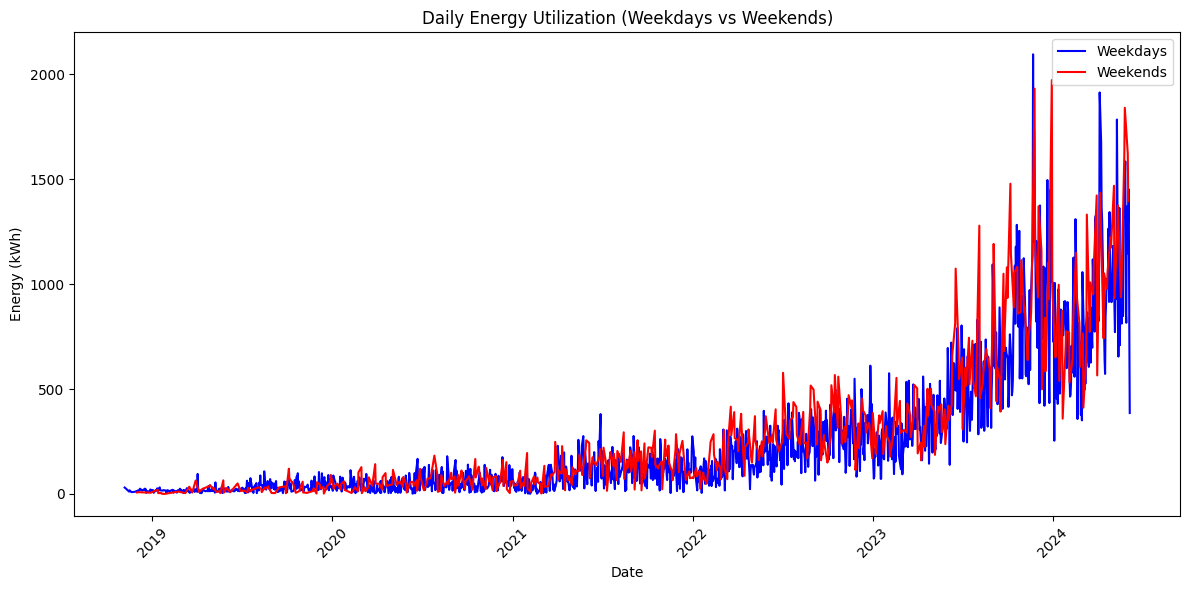

In [184]:


daily_energy = utilization_station_data.groupby('Date')['Energy (kWh)'].sum().reset_index()


daily_energy['Date'] = pd.to_datetime(daily_energy['Date'])

# Create a new column for day of the week (0 = Monday, 6 = Sunday)
daily_energy['Day_of_Week'] = daily_energy['Date'].dt.dayofweek

# Create the plot
plt.figure(figsize=(12, 6))

# Plot weekdays
weekdays = daily_energy[daily_energy['Day_of_Week'].isin([0, 1, 2, 3, 4])]
plt.plot(weekdays['Date'], weekdays['Energy (kWh)'], label='Weekdays', color='blue')

# Plot weekends
weekends = daily_energy[daily_energy['Day_of_Week'].isin([5, 6])]
plt.plot(weekends['Date'], weekends['Energy (kWh)'], label='Weekends', color='red')

plt.title('Daily Energy Utilization (Weekdays vs Weekends)')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\377015032.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekdays['30_Day_Avg'] = weekdays['Energy (kWh)'].rolling(window=30, center=True).mean()
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\377015032.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekends['30_Day_Avg'] = weekends['Energy (kWh)'].rolling(window=30, center=True).mean()


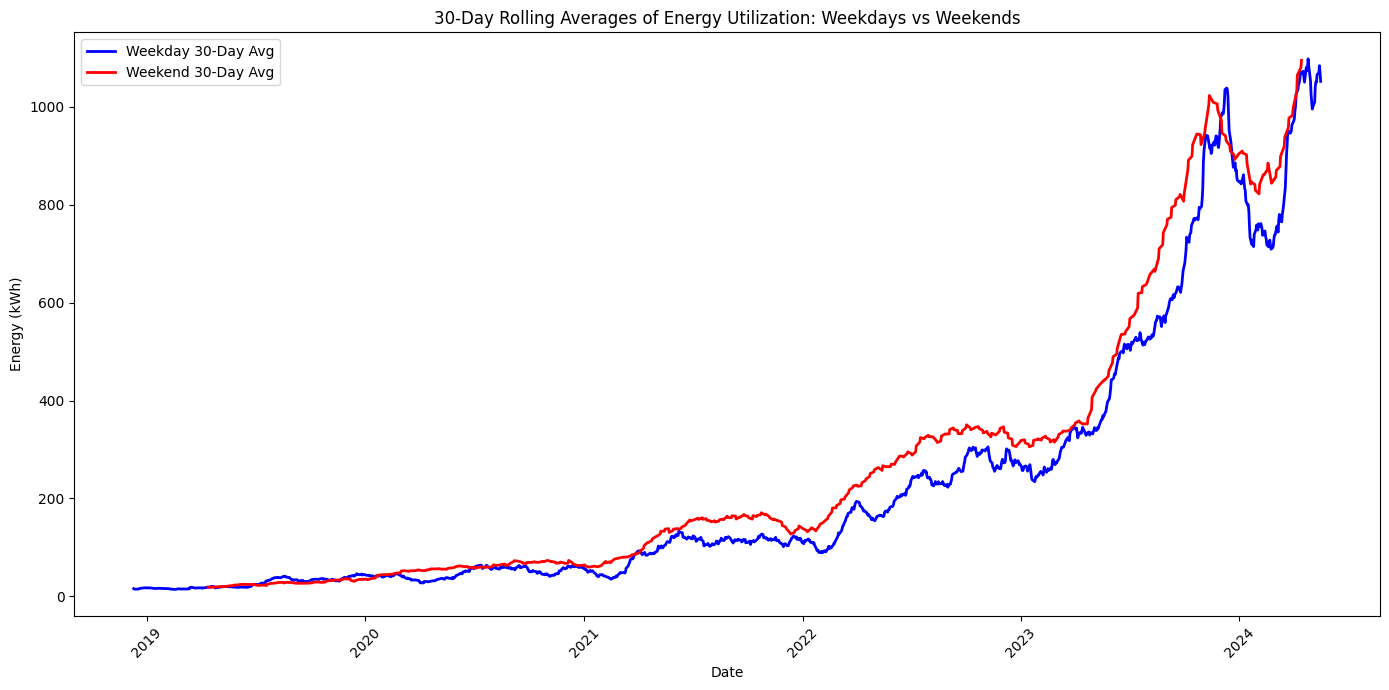

In [188]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming utilization_station_data is already created as in your original code

# Group by date and calculate total energy
daily_energy = utilization_station_data.groupby('Date')['Energy (kWh)'].sum().reset_index()

# Convert Date to datetime if it's not already
daily_energy['Date'] = pd.to_datetime(daily_energy['Date'])

# Sort by date
daily_energy = daily_energy.sort_values('Date')

# Create a new column for day of the week (0 = Monday, 6 = Sunday)
daily_energy['Day_of_Week'] = daily_energy['Date'].dt.dayofweek

# Separate weekdays and weekends
weekdays = daily_energy[daily_energy['Day_of_Week'].isin([0, 1, 2, 3, 4])]
weekends = daily_energy[daily_energy['Day_of_Week'].isin([5, 6])]

# Calculate 30-day rolling averages for weekdays and weekends
weekdays['30_Day_Avg'] = weekdays['Energy (kWh)'].rolling(window=30, center=True).mean()
weekends['30_Day_Avg'] = weekends['Energy (kWh)'].rolling(window=30, center=True).mean()

# Create the plot
plt.figure(figsize=(14, 7))

# Plot weekday rolling average
plt.plot(weekdays['Date'], weekdays['30_Day_Avg'], label='Weekday 30-Day Avg', color='blue', linewidth=2)

# Plot weekend rolling average
plt.plot(weekends['Date'], weekends['30_Day_Avg'], label='Weekend 30-Day Avg', color='red', linewidth=2)

plt.title('30-Day Rolling Averages of Energy Utilization: Weekdays vs Weekends')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\2656483232.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekdays['30_Day_Avg'] = weekdays['Energy (kWh)'].rolling(window=30, center=True).mean()
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\2656483232.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekends['30_Day_Avg'] = weekends['Energy (kWh)'].rolling(window=30, center=True).mean()


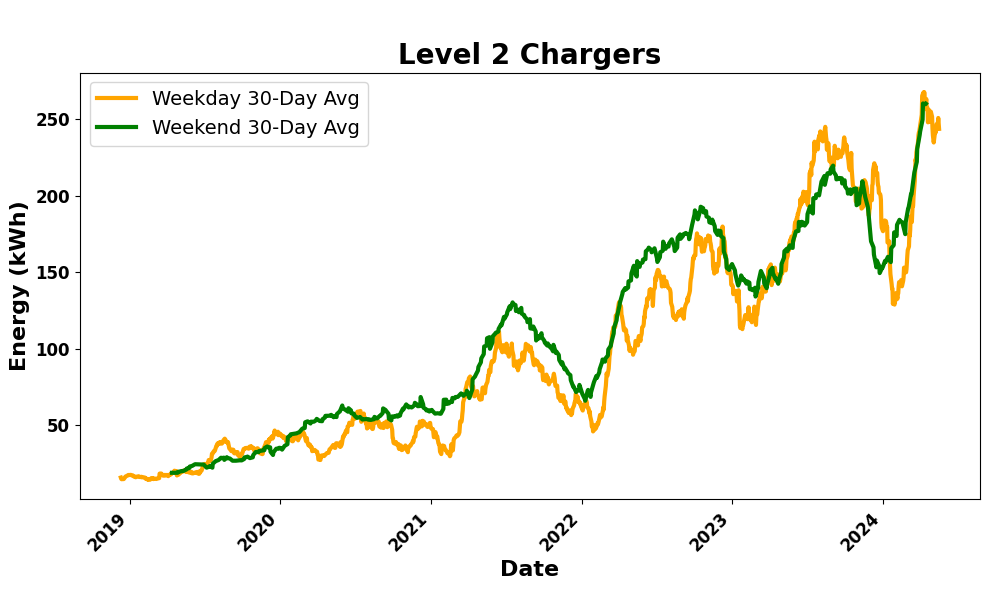

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\2656483232.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekdays['30_Day_Avg'] = weekdays['Energy (kWh)'].rolling(window=30, center=True).mean()
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\2656483232.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekends['30_Day_Avg'] = weekends['Energy (kWh)'].rolling(window=30, center=True).mean()


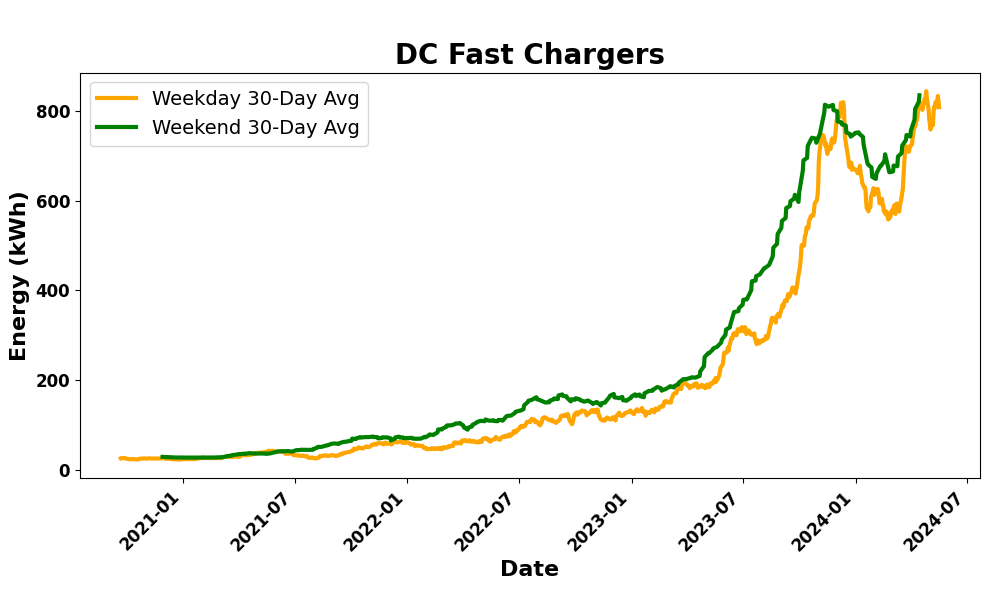

In [195]:

def plot_rolling_average(data, title):
    # Group by date and calculate total energy
    daily_energy = data.groupby('Date')['Energy (kWh)'].sum().reset_index()

    # Convert Date to datetime if it's not already
    daily_energy['Date'] = pd.to_datetime(daily_energy['Date'])

    # Sort by date
    daily_energy = daily_energy.sort_values('Date')

    # Create a new column for day of the week (0 = Monday, 6 = Sunday)
    daily_energy['Day_of_Week'] = daily_energy['Date'].dt.dayofweek

    # Separate weekdays and weekends
    weekdays = daily_energy[daily_energy['Day_of_Week'].isin([0, 1, 2, 3, 4])]
    weekends = daily_energy[daily_energy['Day_of_Week'].isin([5, 6])]

    # Calculate 30-day rolling averages for weekdays and weekends
    weekdays['30_Day_Avg'] = weekdays['Energy (kWh)'].rolling(window=30, center=True).mean()
    weekends['30_Day_Avg'] = weekends['Energy (kWh)'].rolling(window=30, center=True).mean()

   
    plt.figure(figsize=(10, 6))  # Increased figure size

    # Plot weekday rolling average in orange
    plt.plot(weekdays['Date'], weekdays['30_Day_Avg'], label='Weekday 30-Day Avg', color='orange', linewidth=3)

    # Plot weekend rolling average in green
    plt.plot(weekends['Date'], weekends['30_Day_Avg'], label='Weekend 30-Day Avg', color='green', linewidth=3)

    plt.title(f'\n{title}', 
              fontsize=20, fontweight='bold')
    plt.xlabel('Date', fontsize=16, fontweight='bold')
    plt.ylabel('Energy (kWh)', fontsize=16, fontweight='bold')  #30-Day Rolling Averages of Energy Utilization: Weekdays vs Weekends
    
    # Increase legend font size and make it bold
    plt.legend(fontsize=14)

    # Rotate x-axis labels for better readability and increase font size
    plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    # Show the plot
    plt.show()

# Filter data for Level 2 chargers
level2_data = utilization_station_data[utilization_station_data['Port Type'] == 'Level 2']

# Filter data for DC Fast chargers
dc_fast_data = utilization_station_data[utilization_station_data['Port Type'] == 'DC Fast']

# Plot for Level 2 chargers
plot_rolling_average(level2_data, 'Level 2 Chargers')

# Plot for DC Fast chargers
plot_rolling_average(dc_fast_data, 'DC Fast Chargers')

In [273]:

def calculate_total_energy(data, charger_type):
    # Group by date and calculate total energy
    daily_energy = data.groupby('Date')['Energy (kWh)'].sum().reset_index()
    # Convert Date to datetime if it's not already
    daily_energy['Date'] = pd.to_datetime(daily_energy['Date'])
    # Create a new column for day of the week (0 = Monday, 6 = Sunday)
    daily_energy['Day_of_Week'] = daily_energy['Date'].dt.dayofweek
    # Separate weekdays and weekends
    weekdays = daily_energy[daily_energy['Day_of_Week'].isin([0, 1, 2, 3, 4])]
    weekends = daily_energy[daily_energy['Day_of_Week'].isin([5, 6])]
    
    # Calculate total energy for weekdays and weekends
    total_weekday_energy = weekdays['Energy (kWh)'].sum()
    total_weekend_energy = weekends['Energy (kWh)'].sum()
    
    print(f"Total Energy for {charger_type} Chargers:")
    print(f"Weekdays: {total_weekday_energy:.2f} kWh")
    print(f"Weekends: {total_weekend_energy:.2f} kWh")
    print()

# Filter data for Level 2 chargers
level2_data = utilization_station_data[utilization_station_data['Port Type'] == 'Level 2']
# Filter data for DC Fast chargers
dc_fast_data = utilization_station_data[utilization_station_data['Port Type'] == 'DC Fast']

# Calculate and print total energy for Level 2 chargers
calculate_total_energy(level2_data, 'Level 2')
# Calculate and print total energy for DC Fast chargers
calculate_total_energy(dc_fast_data, 'DC Fast')

Total Energy for Level 2 Chargers:
Weekdays: 139196.45 kWh
Weekends: 59951.15 kWh

Total Energy for DC Fast Chargers:
Weekdays: 198147.35 kWh
Weekends: 97532.38 kWh



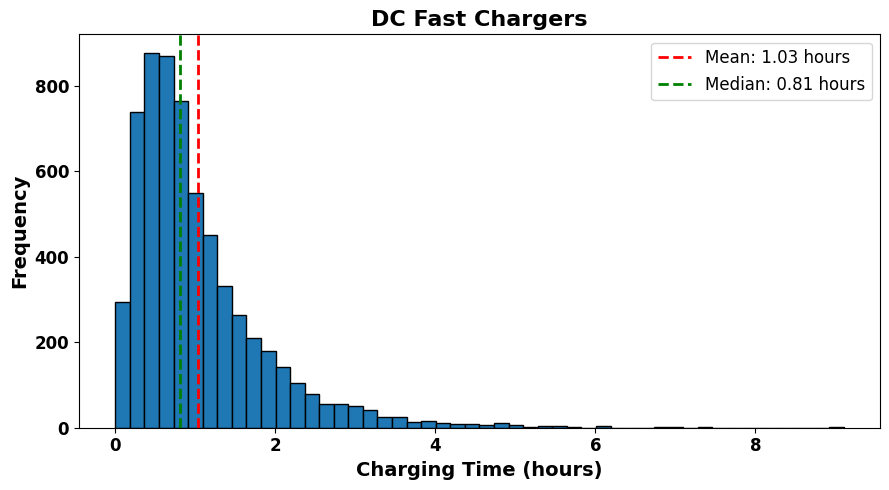

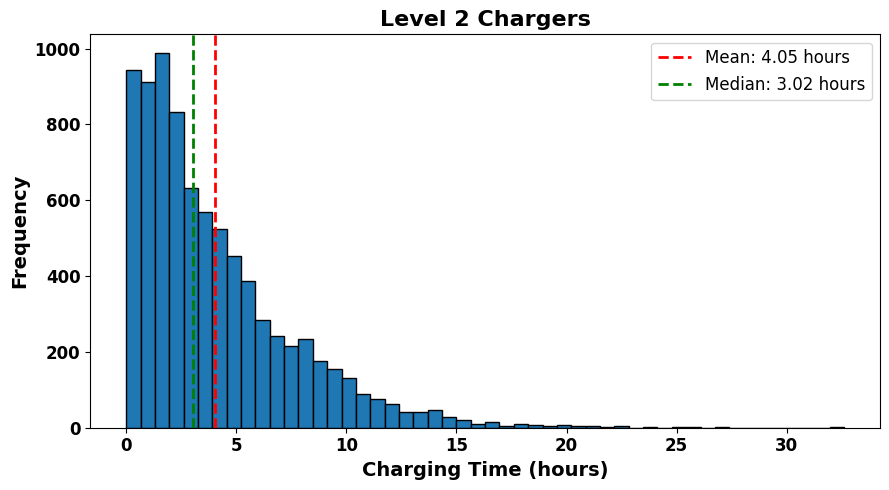

In [198]:

def plot_charging_time_histogram(data, port_type):
    plt.figure(figsize=(9, 5))
    
    # Convert charging time to hours if it's not already
    charging_time_hours = data['Charging Time']
    
    # Create histogram
    plt.hist(charging_time_hours, bins=50, edgecolor='black')
    
    plt.title(f'{port_type} Chargers', fontsize=16, fontweight='bold')
    plt.xlabel('Charging Time (hours)', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add mean and median lines
    mean_time = charging_time_hours.mean()
    median_time = charging_time_hours.median()
    
    plt.axvline(mean_time, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_time:.2f} hours')
    plt.axvline(median_time, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_time:.2f} hours')
    
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Filter data for DC Fast chargers
dc_fast_data = utilization_station_data[utilization_station_data['Port Type'] == 'DC Fast']

# Filter data for Level 2 chargers
level2_data = utilization_station_data[utilization_station_data['Port Type'] == 'Level 2']

# Plot histogram for DC Fast chargers
plot_charging_time_histogram(dc_fast_data, 'DC Fast')

# Plot histogram for Level 2 chargers
plot_charging_time_histogram(level2_data, 'Level 2')

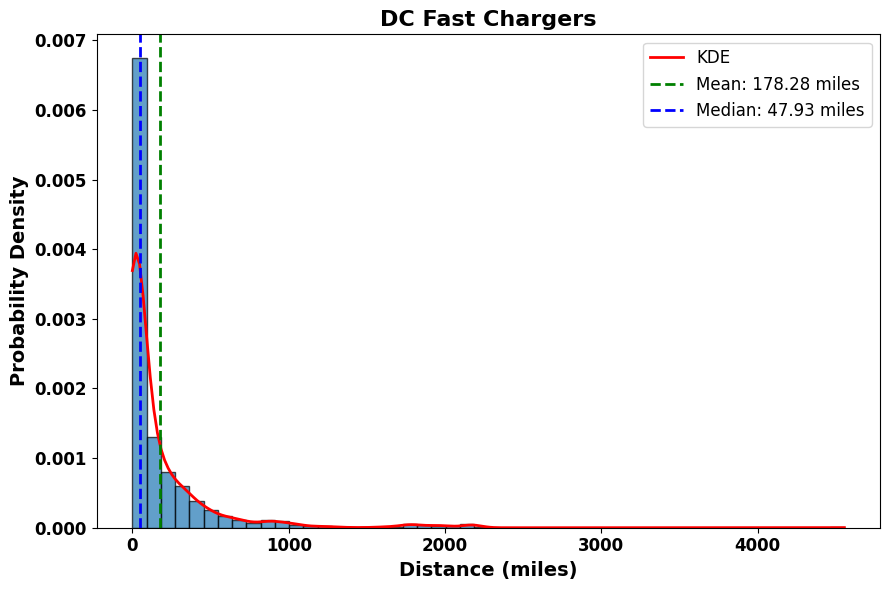

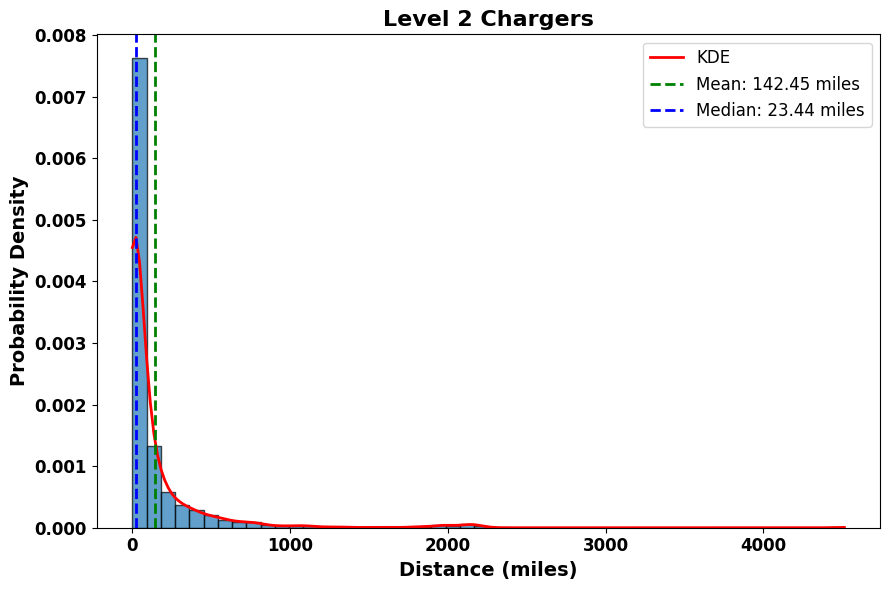

In [201]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

def plot_distance_density(data, port_type):
    plt.figure(figsize=(9, 6))
    
    # Get distance data
    distance = data['Distance (miles)']
    
    # Create histogram with density
    plt.hist(distance, bins=50, density=True, alpha=0.7, edgecolor='black')
    
    # Calculate KDE
    kde = stats.gaussian_kde(distance)
    x_range = np.linspace(distance.min(), distance.max(), 200)
    plt.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    plt.title(f'{port_type} Chargers', fontsize=16, fontweight='bold') #Distribution of Distance to Charging Station 
    plt.xlabel('Distance (miles)', fontsize=14, fontweight='bold')
    plt.ylabel('Probability Density', fontsize=14, fontweight='bold')
    
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add mean and median lines
    mean_distance = distance.mean()
    median_distance = distance.median()
    
    plt.axvline(mean_distance, color='green', linestyle='dashed', linewidth=2, label=f'Mean: {mean_distance:.2f} miles')
    plt.axvline(median_distance, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_distance:.2f} miles')
    
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()


# Filter data for DC Fast chargers
dc_fast_data = utilization_station_data[utilization_station_data['Port Type'] == 'DC Fast']

# Filter data for Level 2 chargers
level2_data = utilization_station_data[utilization_station_data['Port Type'] == 'Level 2']

# Plot distance density for DC Fast chargers
plot_distance_density(dc_fast_data, 'DC Fast')

# Plot distance density for Level 2 chargers
plot_distance_density(level2_data, 'Level 2')

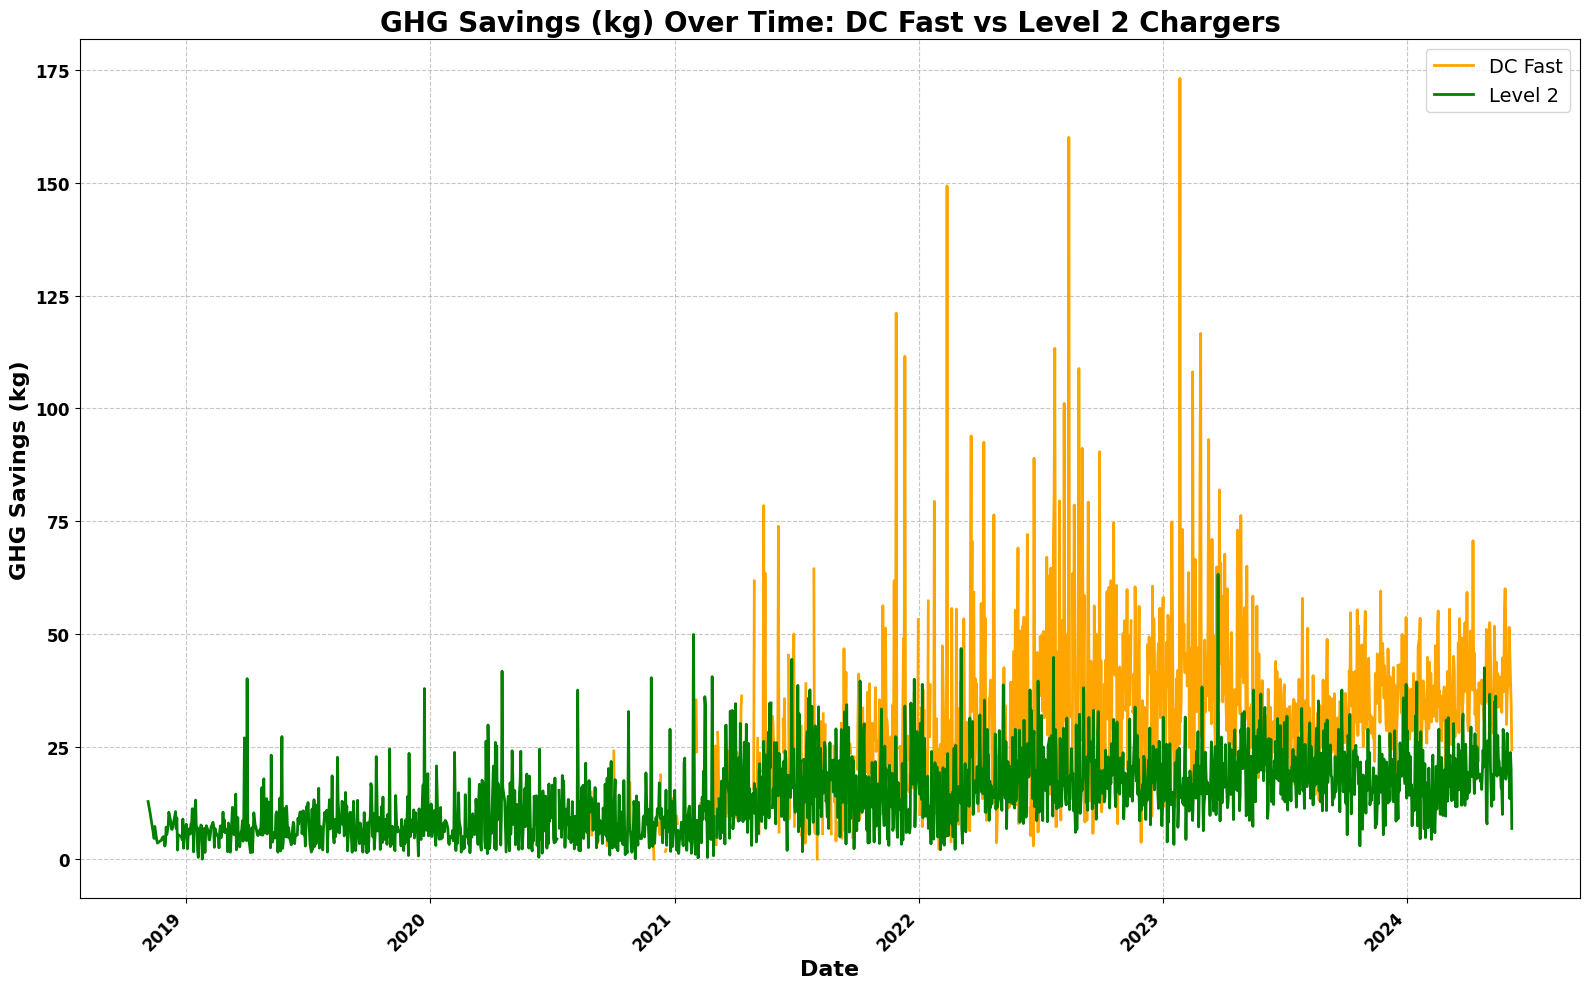

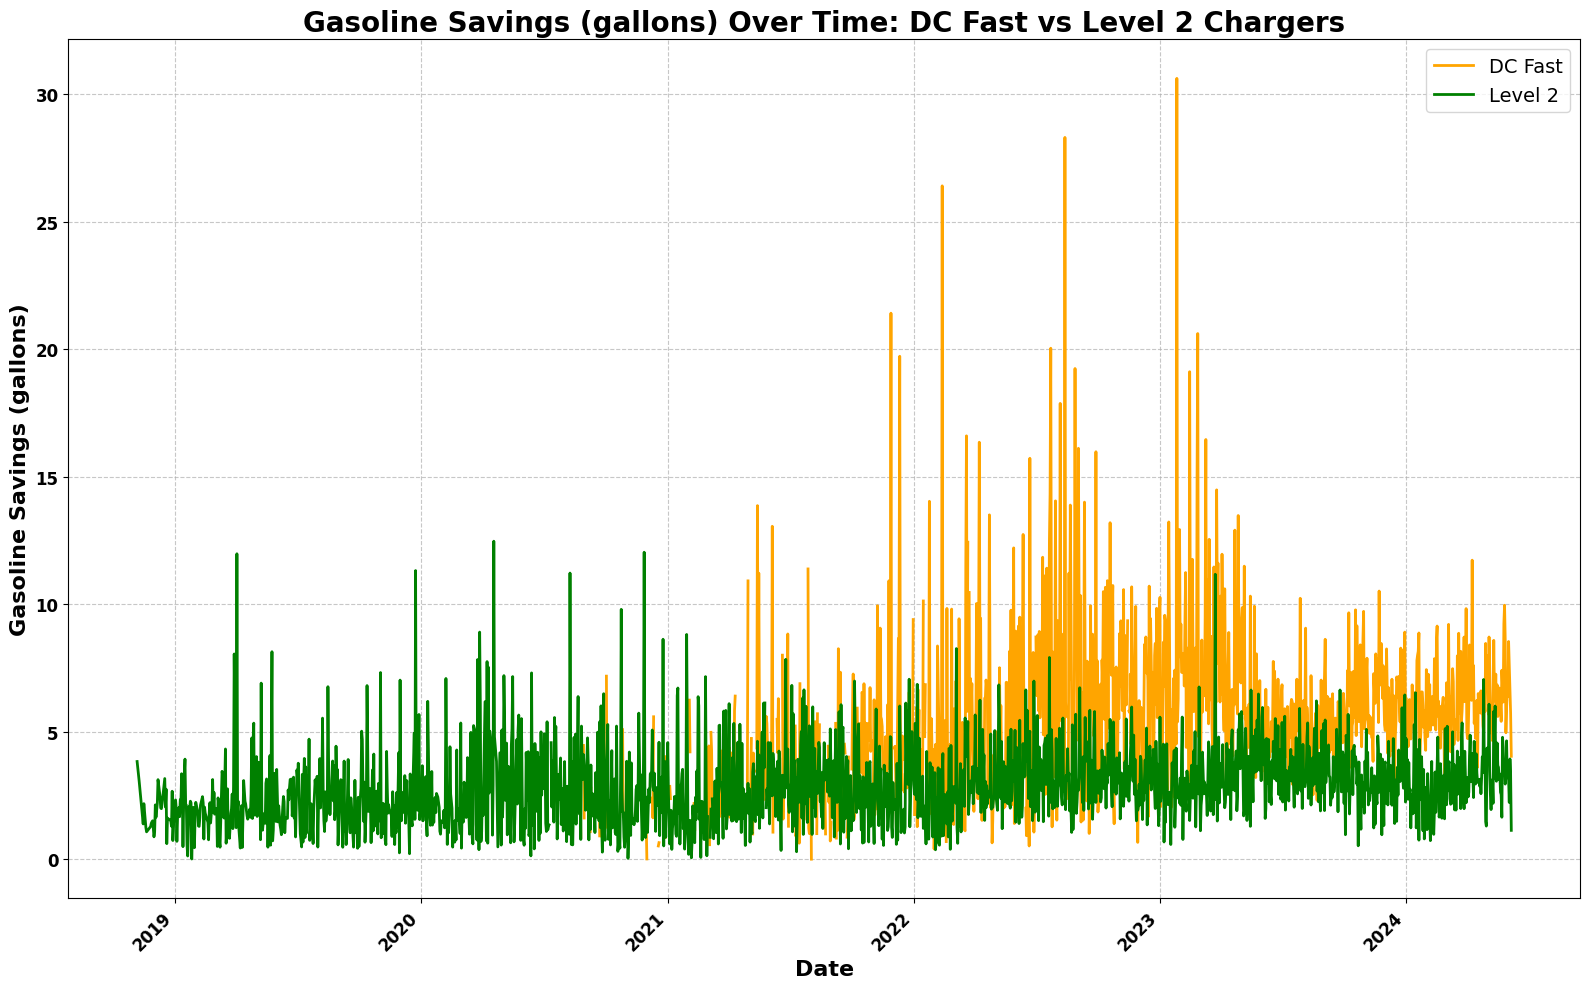

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_savings_comparison(data, saving_type):
    # Convert Date to datetime if it's not already
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Group by date and Port Type, calculate mean savings
    daily_savings = data.groupby(['Date', 'Port Type'])[saving_type].mean().reset_index()
    
    # Pivot the data to have separate columns for DC Fast and Level 2
    daily_savings_pivot = daily_savings.pivot(index='Date', columns='Port Type', values=saving_type)
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Plot DC Fast savings
    plt.plot(daily_savings_pivot.index, daily_savings_pivot['DC Fast'], 
             label='DC Fast', color='orange', linewidth=2)
    
    # Plot Level 2 savings
    plt.plot(daily_savings_pivot.index, daily_savings_pivot['Level 2'], 
             label='Level 2', color='green', linewidth=2)
    
    plt.title(f'{saving_type} Over Time: DC Fast vs Level 2 Chargers', fontsize=20, fontweight='bold')
    plt.xlabel('Date', fontsize=16, fontweight='bold')
    plt.ylabel(f'{saving_type}', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=14)
    
    # Rotate x-axis labels for better readability and increase font size
    plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot GHG savings comparison
plot_savings_comparison(utilization_station_data, 'GHG Savings (kg)')

# Plot gasoline savings comparison
plot_savings_comparison(utilization_station_data, 'Gasoline Savings (gallons)')

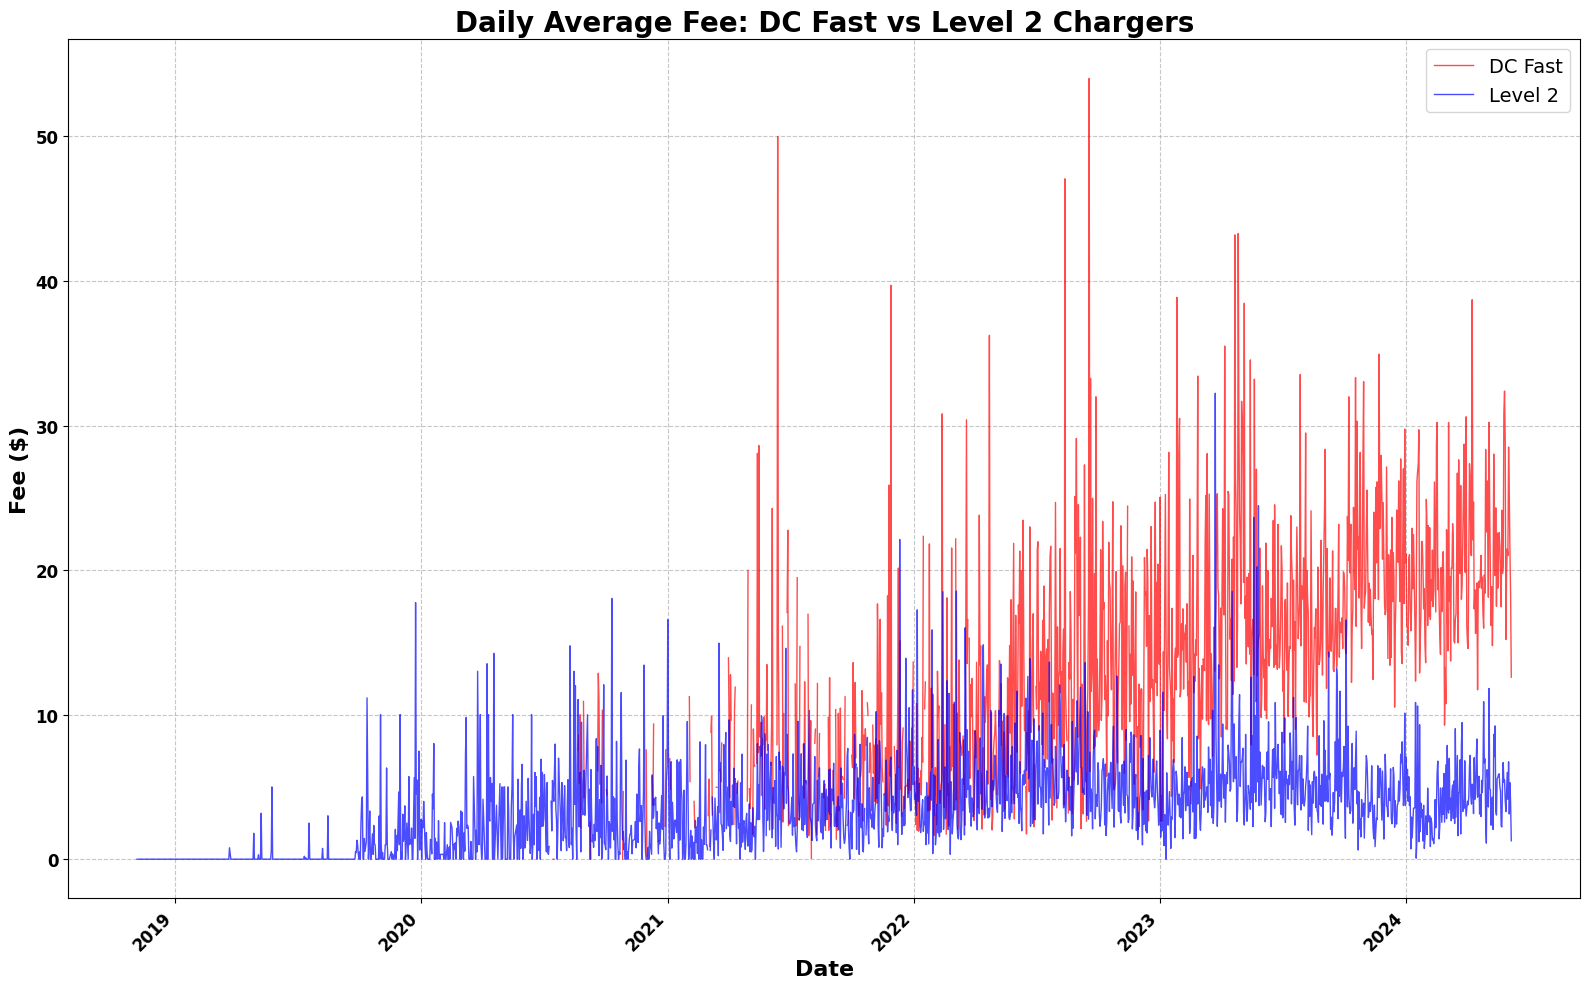

In [214]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_fee_comparison(data):
    # Convert Date to datetime if it's not already
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Group by date and Port Type, calculate mean of the Fee
    daily_fee = data.groupby(['Date', 'Port Type'])['Fee'].mean().reset_index()
    
    # Pivot the data to have separate columns for DC Fast and Level 2
    daily_fee_pivot = daily_fee.pivot(index='Date', columns='Port Type', values='Fee')
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Plot DC Fast fee
    plt.plot(daily_fee_pivot.index, daily_fee_pivot['DC Fast'], 
             label='DC Fast', color='red', linewidth=1, alpha=0.7)
    
    # Plot Level 2 fee
    plt.plot(daily_fee_pivot.index, daily_fee_pivot['Level 2'], 
             label='Level 2', color='blue', linewidth=1, alpha=0.7)
    
    plt.title('Daily Average Fee: DC Fast vs Level 2 Chargers', fontsize=20, fontweight='bold')
    plt.xlabel('Date', fontsize=16, fontweight='bold')
    plt.ylabel('Fee ($)', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=14)
    
    # Rotate x-axis labels for better readability and increase font size
    plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot Fee comparison
plot_fee_comparison(utilization_station_data)

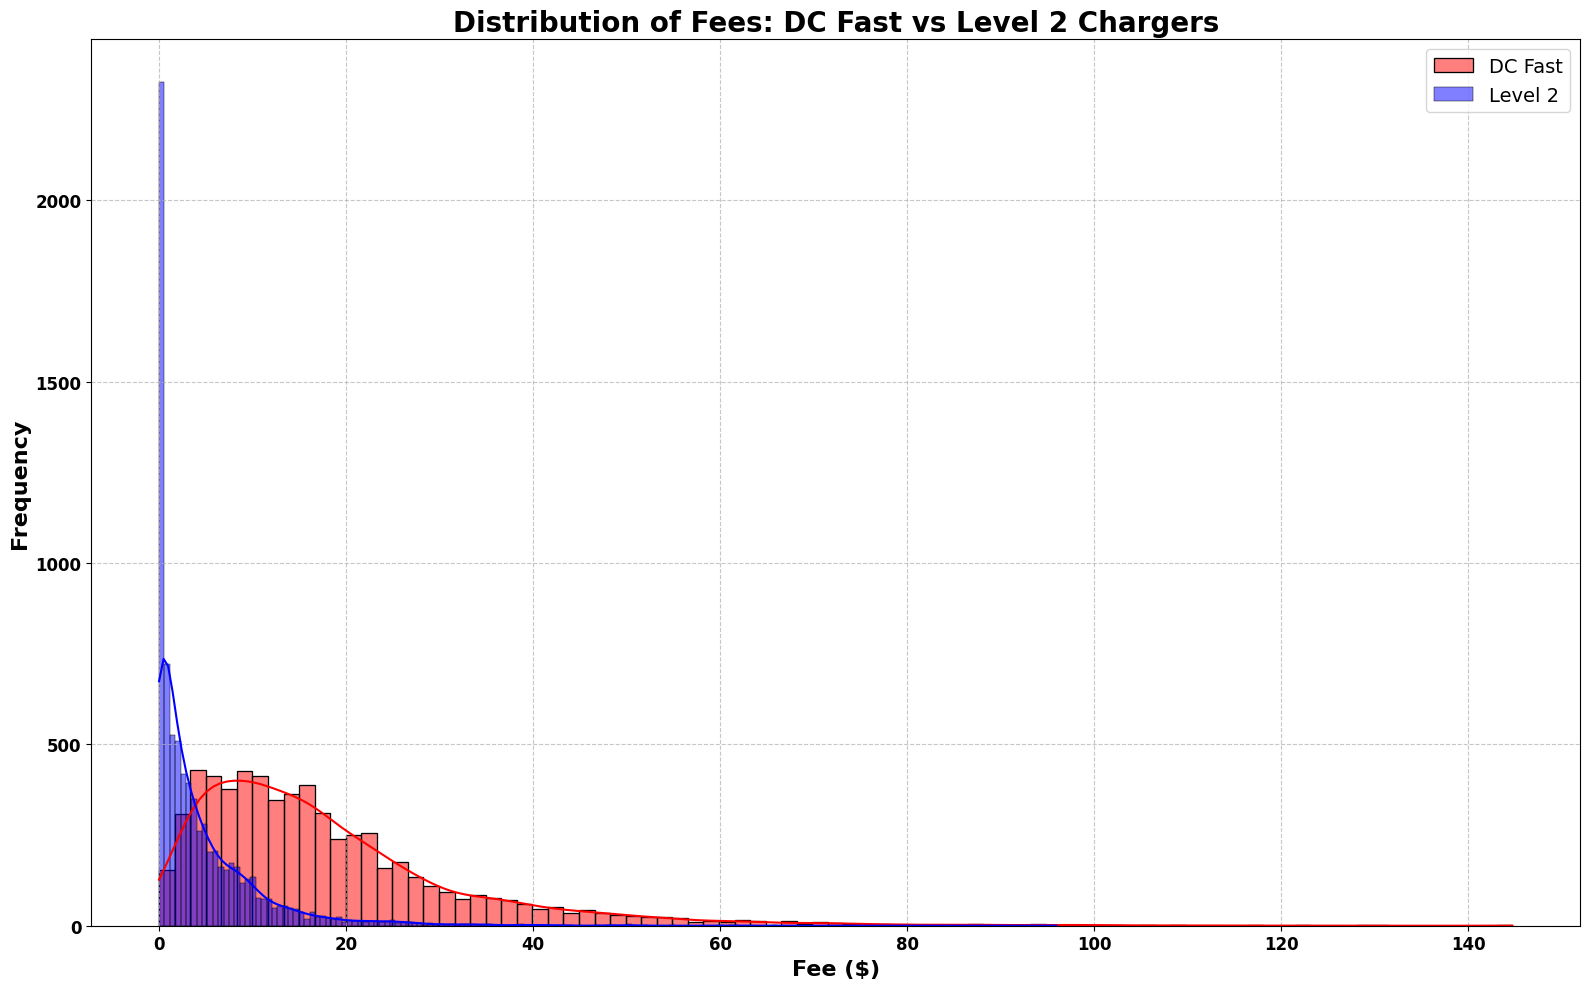

In [215]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_fee_histogram(data):
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Create histograms for both charger types
    sns.histplot(data=data[data['Port Type'] == 'DC Fast'], x='Fee', 
                 color='red', alpha=0.5, label='DC Fast', kde=True)
    sns.histplot(data=data[data['Port Type'] == 'Level 2'], x='Fee', 
                 color='blue', alpha=0.5, label='Level 2', kde=True)
    
    plt.title('Distribution of Fees: DC Fast vs Level 2 Chargers', fontsize=20, fontweight='bold')
    plt.xlabel('Fee ($)', fontsize=16, fontweight='bold')
    plt.ylabel('Frequency', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=14)
    
    # Increase font size for tick labels
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot Fee histogram
plot_fee_histogram(utilization_station_data)

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\4193728996.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[data['Port Type'] == 'DC Fast'], x='Fee',
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\4193728996.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data[data['Port Type'] == 'Level 2'], x='Fee',


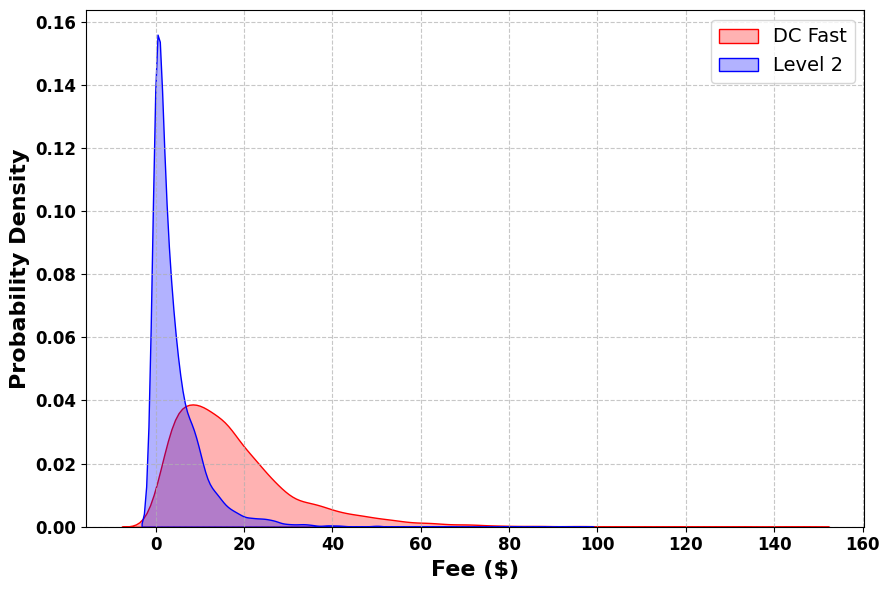

In [218]:

def plot_fee_density(data):
    # Create the plot
    plt.figure(figsize=(9, 6))
    
    # Create density plots for both charger types
    sns.kdeplot(data=data[data['Port Type'] == 'DC Fast'], x='Fee', 
                color='red', label='DC Fast', shade=True, alpha=0.3)
    sns.kdeplot(data=data[data['Port Type'] == 'Level 2'], x='Fee', 
                color='blue', label='Level 2', shade=True, alpha=0.3)
    
   # plt.title('Probability Density of Fees: DC Fast vs Level 2 Chargers', fontsize=20, fontweight='bold')
    plt.xlabel('Fee ($)', fontsize=16, fontweight='bold')
    plt.ylabel('Probability Density', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=14)
    
    # Increase font size for tick labels
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot Fee probability density
plot_fee_density(utilization_station_data)

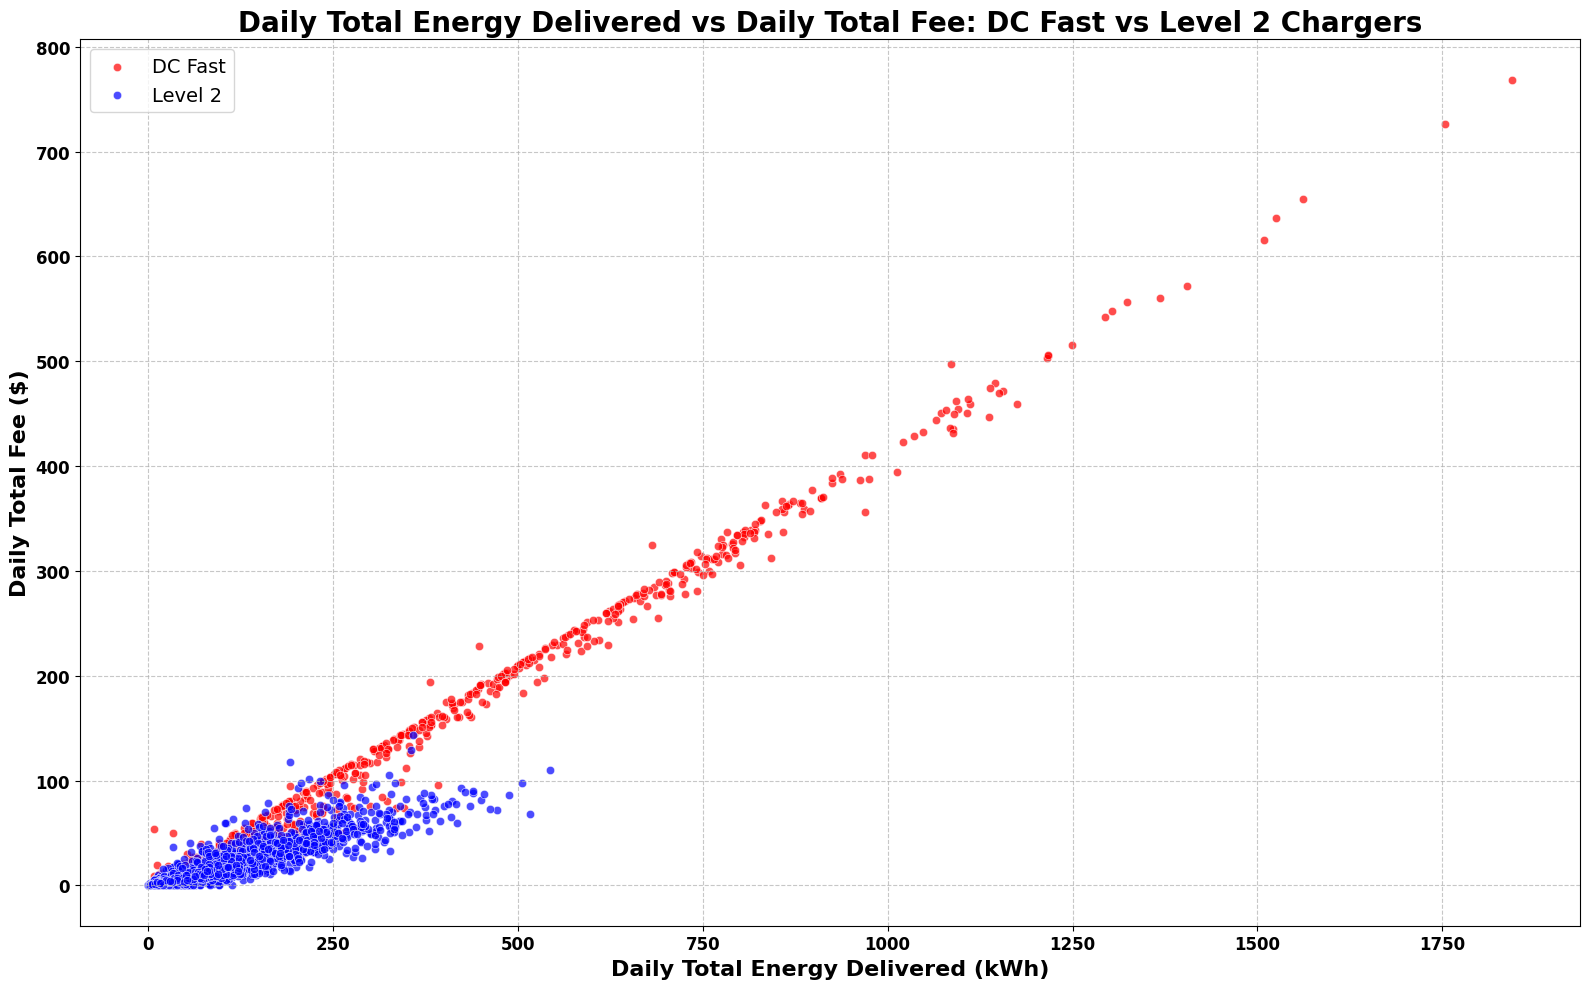

In [220]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_daily_energy_vs_fee(data):
    # Convert Date to datetime if it's not already
    data['Date'] = pd.to_datetime(data['Date'])
    
    # Group by Date and Port Type, sum Energy and Fee
    daily_data = data.groupby(['Date', 'Port Type']).agg({
        'Energy (kWh)': 'sum',
        'Fee': 'sum'
    }).reset_index()
    
    # Create the plot
    plt.figure(figsize=(16, 10))
    
    # Scatter plot for DC Fast chargers
    sns.scatterplot(data=daily_data[daily_data['Port Type'] == 'DC Fast'], 
                    x='Energy (kWh)', y='Fee', 
                    color='red', alpha=0.7, label='DC Fast')
    
    # Scatter plot for Level 2 chargers
    sns.scatterplot(data=daily_data[daily_data['Port Type'] == 'Level 2'], 
                    x='Energy (kWh)', y='Fee', 
                    color='blue', alpha=0.7, label='Level 2')
    
    plt.title('Daily Total Energy Delivered vs Daily Total Fee: DC Fast vs Level 2 Chargers', 
              fontsize=20, fontweight='bold')
    plt.xlabel('Daily Total Energy Delivered (kWh)', fontsize=16, fontweight='bold')
    plt.ylabel('Daily Total Fee ($)', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=14)
    
    # Increase font size for tick labels
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot Daily Energy vs Daily Fee
plot_daily_energy_vs_fee(utilization_station_data)

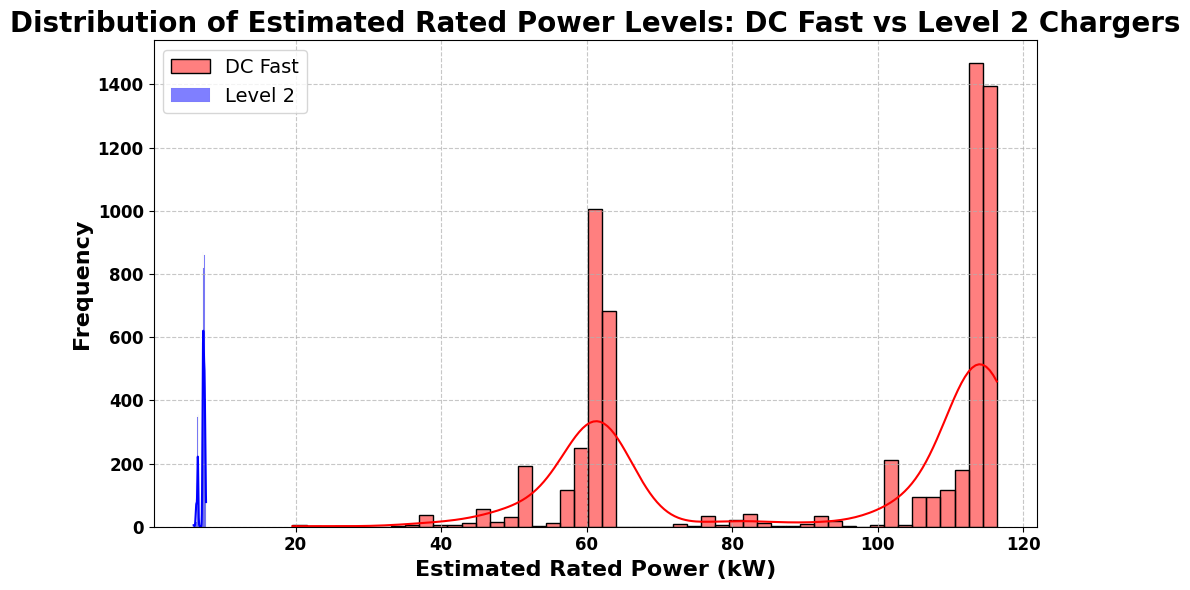

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_port_kw_histogram(data):
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Create histograms for both charger types
    sns.histplot(data=data[data['Port Type'] == 'DC Fast'], x='port_kw', 
                 color='red', alpha=0.5, label='DC Fast', kde=True, bins=50)
    sns.histplot(data=data[data['Port Type'] == 'Level 2'], x='port_kw', 
                 color='blue', alpha=0.5, label='Level 2', kde=True, bins=50)
    
    plt.title('Distribution of Estimated Rated Power Levels: DC Fast vs Level 2 Chargers', 
              fontsize=20, fontweight='bold')
    plt.xlabel('Estimated Rated Power (kW)', fontsize=16, fontweight='bold')
    plt.ylabel('Frequency', fontsize=16, fontweight='bold')
    
    plt.legend(fontsize=14)
    
    # Increase font size for tick labels
    plt.xticks(fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Plot port_kw histogram
plot_port_kw_histogram(utilization_station_data)

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1097749903.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc_fast_data['Power_Category'] = dc_fast_data['Power_Delivered'].apply(categorize_dc_power)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1097749903.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level2_data['Power_Category'] = level2_data['Power_Delivered'].apply(categorize_level2_power)


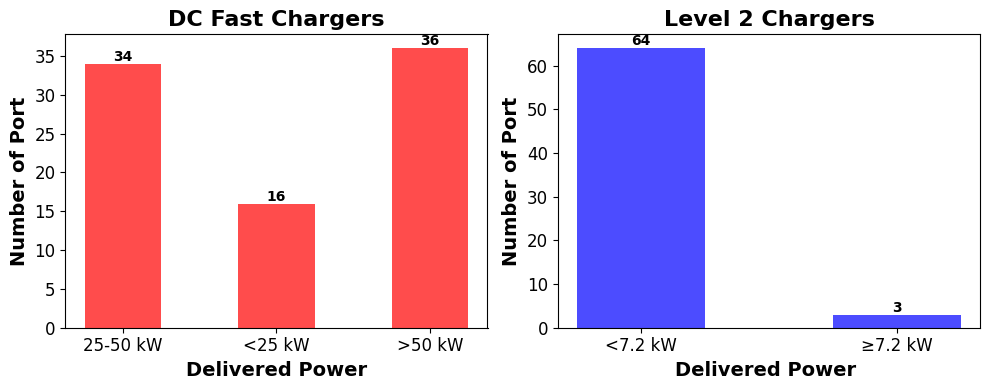

In [265]:

def categorize_dc_power(kw):
    if kw < 25:
        return '<25 kW'
    elif 25 <= kw < 50:
        return '25-50 kW'
    else:
        return '>50 kW'

def categorize_level2_power(kw):
    if kw < 7.2:
        return '<7.2 kW'
    else:
        return '≥7.2 kW'

def plot_power_categories(df):
    # Calculate average Session  Delivered Power
    port_kw_estimate = df.groupby(['EVSE ID', 'Port Number', 'Port Type'])['Power_Delivered'].mean().reset_index()
    
    dc_fast_data = port_kw_estimate[port_kw_estimate['Port Type'] == 'DC Fast']
    level2_data = port_kw_estimate[port_kw_estimate['Port Type'] == 'Level 2']
    
    # Categorize power levels
    dc_fast_data['Power_Category'] = dc_fast_data['Power_Delivered'].apply(categorize_dc_power)
    level2_data['Power_Category'] = level2_data['Power_Delivered'].apply(categorize_level2_power)
    
    # Count the number of EVSE IDs in each category
    dc_fast_counts = dc_fast_data['Power_Category'].value_counts().sort_index()
    level2_counts = level2_data['Power_Category'].value_counts().sort_index()
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax2.bar(level2_counts.index, level2_counts.values, width=0.5, color='blue', alpha=0.7)
    ax2.set_title('Level 2 Chargers', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Delivered Power ', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Number of Port', fontsize=14, fontweight='bold')
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    for i, v in enumerate(level2_counts.values):
        ax2.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

    ax1.bar(dc_fast_counts.index, dc_fast_counts.values, width=0.5, color='red', alpha=0.7)
    ax1.set_title('DC Fast Chargers', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Delivered Power', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Port', fontsize=14, fontweight='bold')
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    for i, v in enumerate(dc_fast_counts.values):
        ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')
    

    
    plt.tight_layout()
    
    plt.show()

plot_power_categories(df)

In [174]:
utilization_station_data


EVSE ID  Port Number        Date  Energy (kWh)  Number of Events  \
0      2118081            2  2020-07-15        26.996                 1   
1      2118081            2  2020-07-16        15.871                 1   
2      2118081            2  2020-07-22        46.978                 5   
3      2118081            2  2020-07-29        25.934                 1   
4      2118081            2  2020-08-07        29.157                 3   
...        ...          ...         ...           ...               ...   
6203  15815141            1  2024-05-14        17.499                 1   
6204  15815141            1  2024-05-15        49.260                 1   
6205  15815141            1  2024-05-18        94.371                 1   
6206  15815141            1  2024-05-19        17.508                 1   
6207  15815141            1  2024-05-26        37.727                 1   

      Charging Time    Fee    port_kw  Distance (miles)  season  ...  \
0          1.450000   0.00  61.810000        123.101232     2.0  ...   
1          0.333333   0.00  59.340000        123.101232     2.0  ...   
2          1.450000   0.00  60.822000        123.101232     2.0  ...   
3          0.516667   6.47  61.810000         88.404050     2.0  ...   
4          0.874444  10.78  59.340000          0.000000     2.0  ...   
...             ...    ...        ...               ...     ...  ...   
6203       0.310000   7.35  57.768339         25.071952     1.0  ...   
6204       0.868889  20.69  57.768339          0.000000     1.0  ...   
6205       1.633611  39.64  57.768339          0.000000     1.0  ...   
6206       0.313056   7.35  57.768339          0.000000     1.0  ...   
6207       0.766111  15.85  57.768339        185.281936     1.0  ...   

      ven_med_ed  ven_HWY  ven_office  ven_parking ven_retail DC L2 cost_free  \
0              0        0           0            0          0  1  0         1   
1              0        0           0            0          0  1  0         1   
2              0        0           0            0          0  1  0         1   
3              0        0           0            0          0  1  0         0   
4              0        0           0            0          0  1  0         0   
...          ...      ...         ...          ...        ... .. ..       ...   
6203           0        1           0            0          0  1  0         0   
6204           0        1           0            0          0  1  0         0   
6205           0        1           0            0          0  1  0         0   
6206           0        1           0            0          0  1  0         0   
6207           0        1           0            0          0  1  0         0   

     cost_paid Energy_Unit_Price  
0            0          0.000000  
1            0          0.000000  
2            0          0.000000  
3            1          0.498959  
4            1          0.739445  
...        ...               ...  
6203         1          0.420024  
6204         1          0.420016  
6205         1          0.420044  
6206         1          0.419808  
6207         1          0.420124  

[6208 rows x 50 columns]

# **venue utilization**

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3252166218.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=venue_counts.values, y=venue_counts.index, palette='viridis')


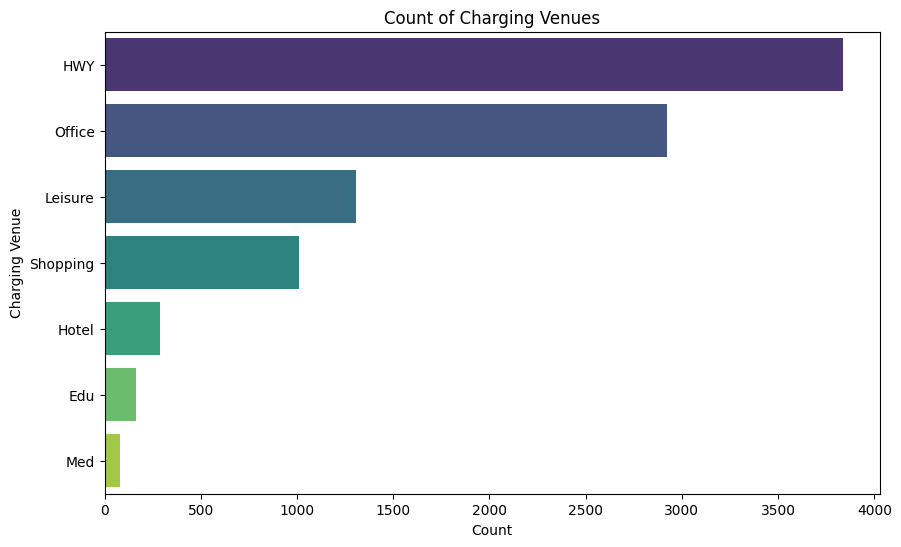

In [177]:
venue_counts = df_tennessee_2023['Charging Venue'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts.values, y=venue_counts.index, palette='viridis')

plt.xlabel('Count')
plt.ylabel('Charging Venue')
plt.title('Count of Charging Venues')
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\717802388.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=venue_counts.values, y=venue_counts.index, palette='viridis')


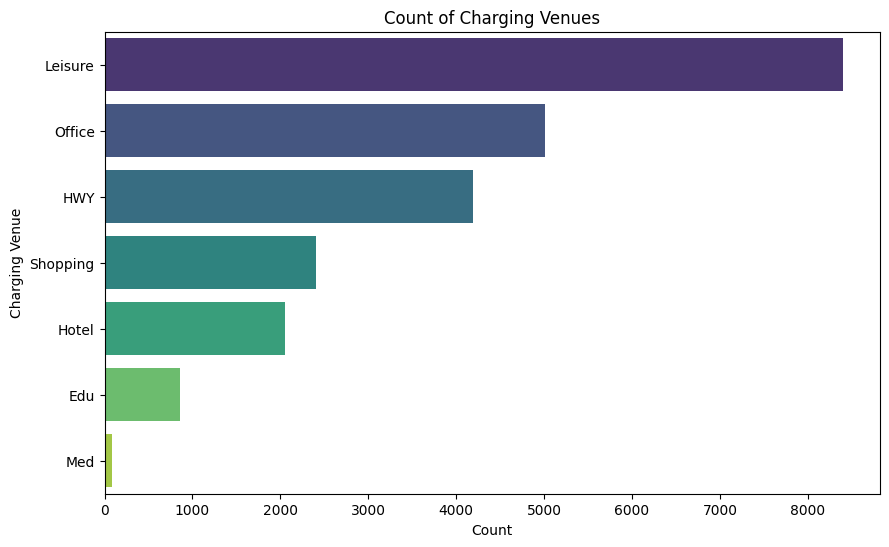

In [99]:
venue_counts = df['Charging Venue'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts.values, y=venue_counts.index, palette='viridis')

plt.xlabel('Count')
plt.ylabel('Charging Venue')
plt.title('Count of Charging Venues')
plt.show()

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1396527868.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=venue_counts_tennessee.values, y=venue_counts_tennessee.index, palette=color_palette)


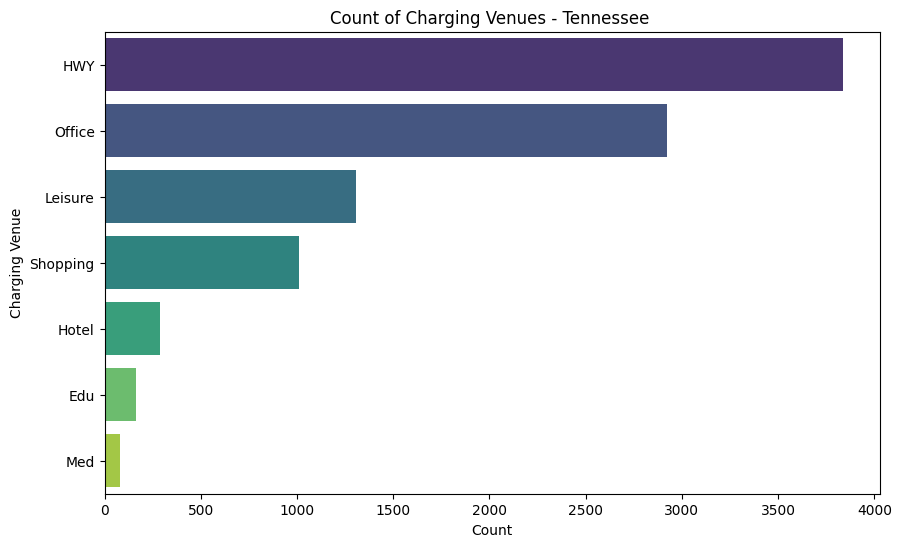

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\1396527868.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=venue_counts_general.values, y=venue_counts_general.index, palette=color_palette)


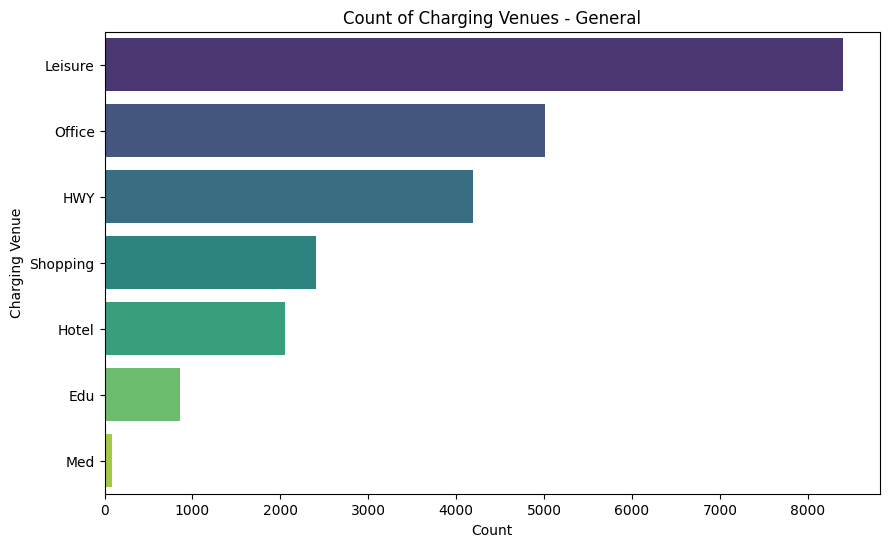

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_tennessee_2023 and df are your dataframes

# Calculate value counts for Charging Venue
venue_counts_tennessee = df_tennessee_2023['Charging Venue'].value_counts()
venue_counts_general = df['Charging Venue'].value_counts()

# Define a common color palette
color_palette = 'viridis'

# Plot for df_tennessee_2023
plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts_tennessee.values, y=venue_counts_tennessee.index, palette=color_palette)

plt.xlabel('Count')
plt.ylabel('Charging Venue')
plt.title('Count of Charging Venues - Tennessee ')
plt.show()

# Plot for df
plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts_general.values, y=venue_counts_general.index, palette=color_palette)

plt.xlabel('Count')
plt.ylabel('Charging Venue')
plt.title('Count of Charging Venues - General')
plt.show()


C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\593465162.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=venue_counts_tennessee.values, y=venue_counts_tennessee.index, palette=color_palette, order=categories)


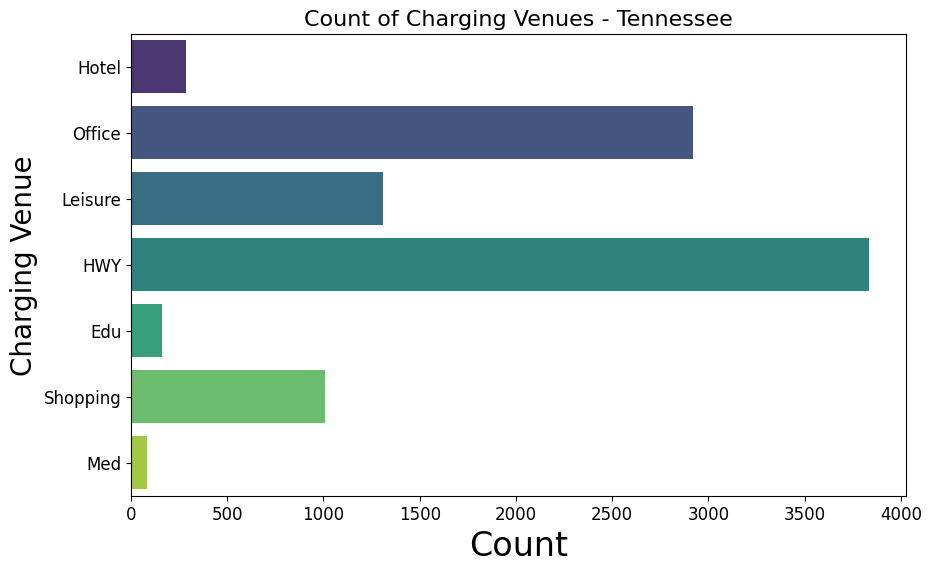

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\593465162.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=venue_counts_general.values, y=venue_counts_general.index, palette=color_palette, order=categories)


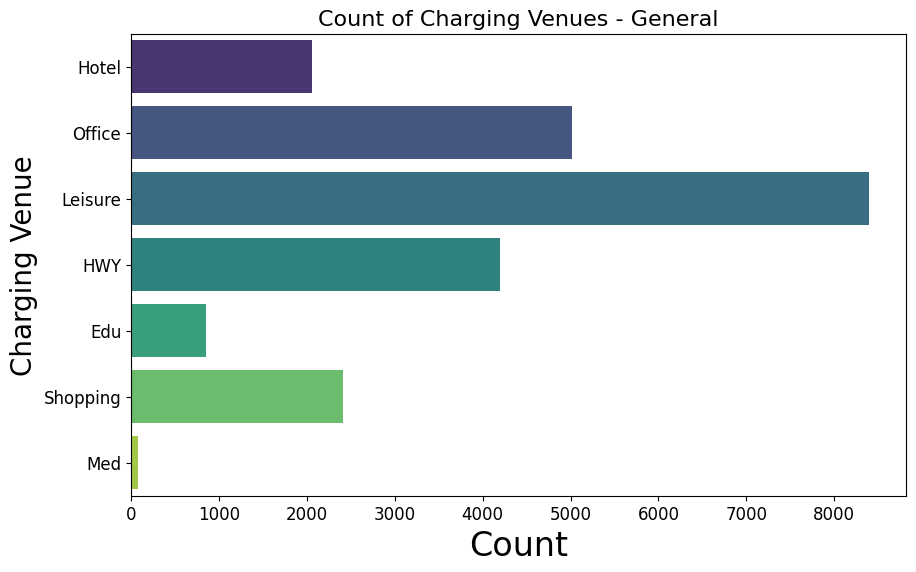

In [120]:

venue_counts_tennessee = df_tennessee_2023['Charging Venue'].value_counts()
venue_counts_general = df['Charging Venue'].value_counts()

# Define a common color palette
color_palette = 'viridis'

# Extract the unique categories and order them
categories = df['Charging Venue'].unique()

# Plot for df_tennessee_2023
plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts_tennessee.values, y=venue_counts_tennessee.index, palette=color_palette, order=categories)

plt.xlabel('Count', fontsize=24)  # Adjust font size here
plt.ylabel('Charging Venue', fontsize=20)  # Adjust font size here
plt.title('Count of Charging Venues - Tennessee', fontsize=16)  # Adjust font size here
plt.xticks(fontsize=12)  # Adjust x-axis tick label font size
plt.yticks(fontsize=12)  # Adjust y-axis tick label font size
plt.show()

# Plot for df
plt.figure(figsize=(10, 6))
sns.barplot(x=venue_counts_general.values, y=venue_counts_general.index, palette=color_palette, order=categories)

plt.xlabel('Count', fontsize=24)  # Adjust font size here
plt.ylabel('Charging Venue', fontsize=20)  # Adjust font size here
plt.title('Count of Charging Venues - General', fontsize=16)  # Adjust font size here
plt.xticks(fontsize=12)  # Adjust x-axis tick label font size
plt.yticks(fontsize=12)  # Adjust y-axis tick label font size
plt.show()


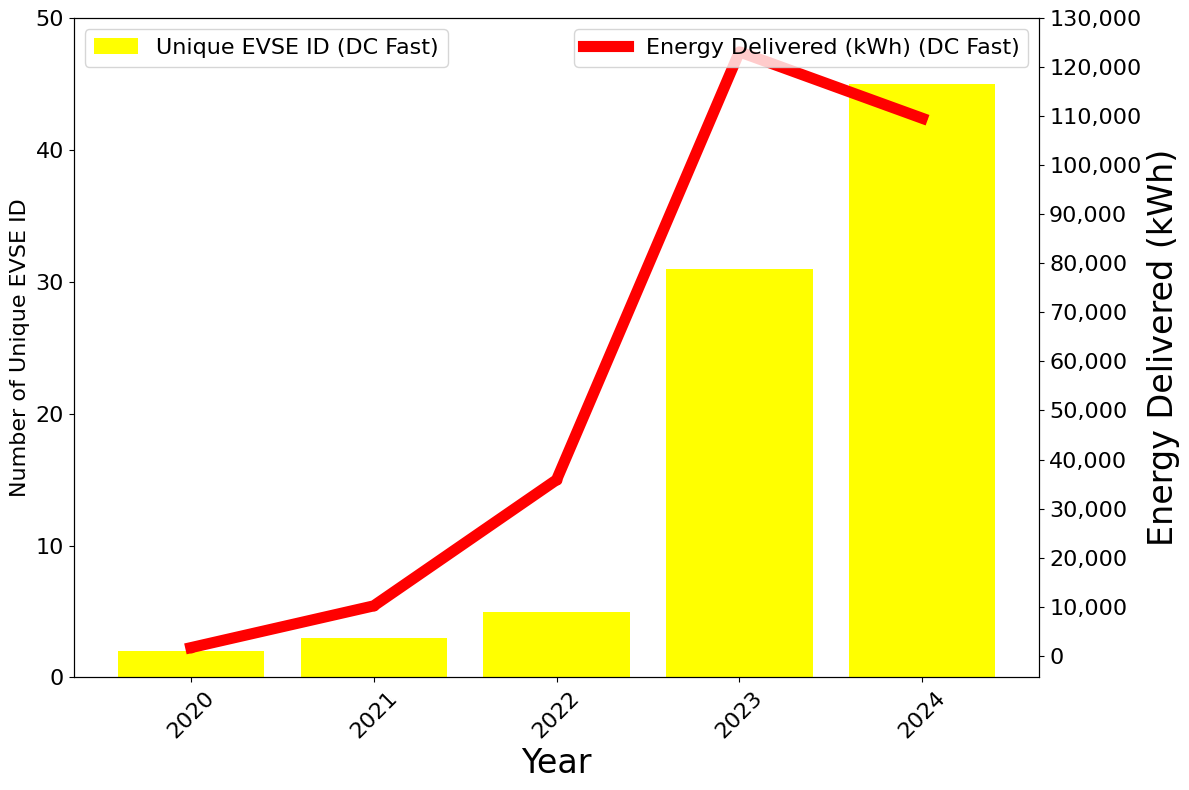

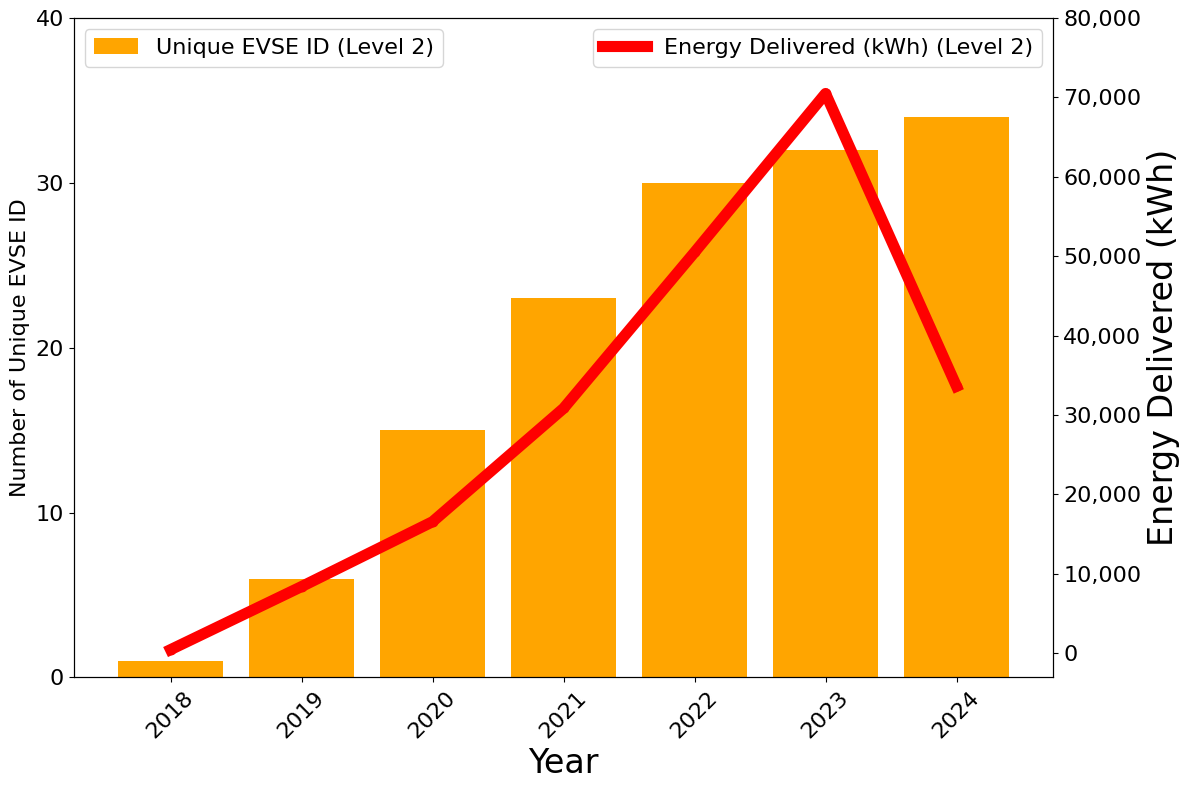

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame setup (Replace this with your actual DataFrame loading)
# df = pd.read_csv('your_data.csv')

# Ensure datetime conversion and feature extraction
df['Start_Tim_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Year'] = df['Start_Tim_EST'].dt.year  # Extract the year
df['Hour'] = df['Start_Tim_EST'].dt.hour + 1  # Extract the hour and shift from 0-23 to 1-24

# Verify the existence of the 'Port Type' column
if 'Port Type' not in df.columns:
    raise KeyError("The column 'Port Type' does not exist in the DataFrame.")

# Filter for 'DC Fast'
dc_fast = df[df['Port Type'] == 'DC Fast']
dc_fast_yearly_stats = dc_fast.groupby('Year').agg({'EVSE ID': pd.Series.nunique, 'Energy (kWh)': 'sum'}).reset_index()

# Filter for 'Level 2'
level_2 = df[df['Port Type'] == 'Level 2']
level_2_yearly_stats = level_2.groupby('Year').agg({'EVSE ID': pd.Series.nunique, 'Energy (kWh)': 'sum'}).reset_index()

# Function to calculate suitable y-ticks for energy
def calculate_yticks(max_value, step):
    max_int = int(max_value) + (step - int(max_value) % step)
    return range(0, max_int + step, step)

# Plot for 'DC Fast'
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(dc_fast_yearly_stats['Year'], dc_fast_yearly_stats['EVSE ID'], color='yellow', label='Unique EVSE ID (DC Fast)')
ax1.set_xlabel('Year', fontsize=24)
ax1.set_ylabel('Number of Unique EVSE ID', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_yticks(range(0, max(dc_fast_yearly_stats['EVSE ID']) + 10, 10))

# Create a secondary y-axis for energy delivered
ax2 = ax1.twinx()
ax2.plot(dc_fast_yearly_stats['Year'], dc_fast_yearly_stats['Energy (kWh)'], color='red', marker='o', linewidth=8, label='Energy Delivered (kWh) (DC Fast)')
ax2.set_ylabel('Energy Delivered (kWh)', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)

# Set limited y-ticks for better readability on the energy axis
yticks = calculate_yticks(max(dc_fast_yearly_stats['Energy (kWh)']), 10000)
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{y:,}' for y in yticks])

#plt.title('DC Fast: Number of Unique EVSE IDs and Sum of Energy Delivered Each Year', fontsize=24)
ax1.legend(loc='upper left', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()

# Plot for 'Level 2'
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(level_2_yearly_stats['Year'], level_2_yearly_stats['EVSE ID'], color='orange', label='Unique EVSE ID (Level 2)')
ax1.set_xlabel('Year', fontsize=24)
ax1.set_ylabel('Number of Unique EVSE ID', fontsize=16)
ax1.tick_params(axis='x', rotation=45, labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_yticks(range(0, max(level_2_yearly_stats['EVSE ID']) + 10, 10))

# Create a secondary y-axis for energy delivered
ax2 = ax1.twinx()
ax2.plot(level_2_yearly_stats['Year'], level_2_yearly_stats['Energy (kWh)'], color='red', marker='o', linewidth=8, label='Energy Delivered (kWh) (Level 2)')
ax2.set_ylabel('Energy Delivered (kWh)', fontsize=24)
ax2.tick_params(axis='y', labelsize=16)

# Set limited y-ticks for better readability on the energy axis
yticks = calculate_yticks(max(level_2_yearly_stats['Energy (kWh)']), 10000)
ax2.set_yticks(yticks)
ax2.set_yticklabels([f'{y:,}' for y in yticks])

#plt.title('Level 2: Number of Unique EVSE IDs and Sum of Energy Delivered Each Year', fontsize=24)
ax1.legend(loc='upper left', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)

plt.tight_layout()
plt.show()


C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


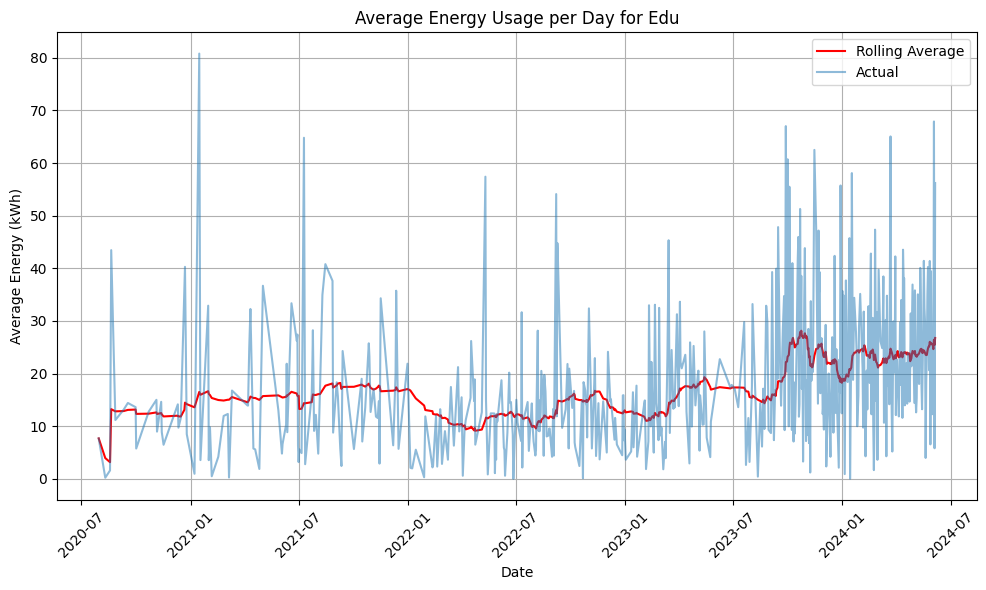

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


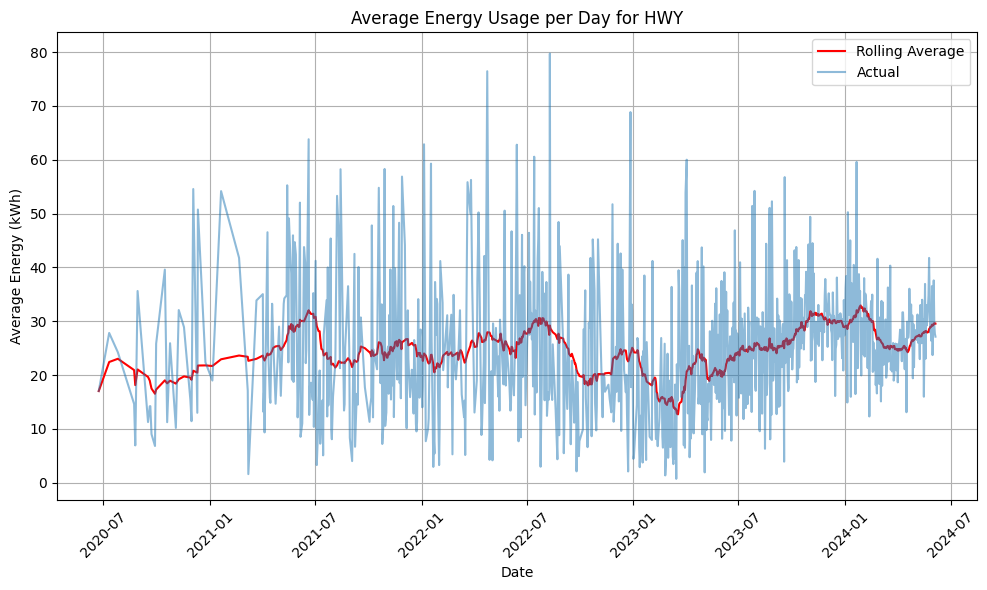

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


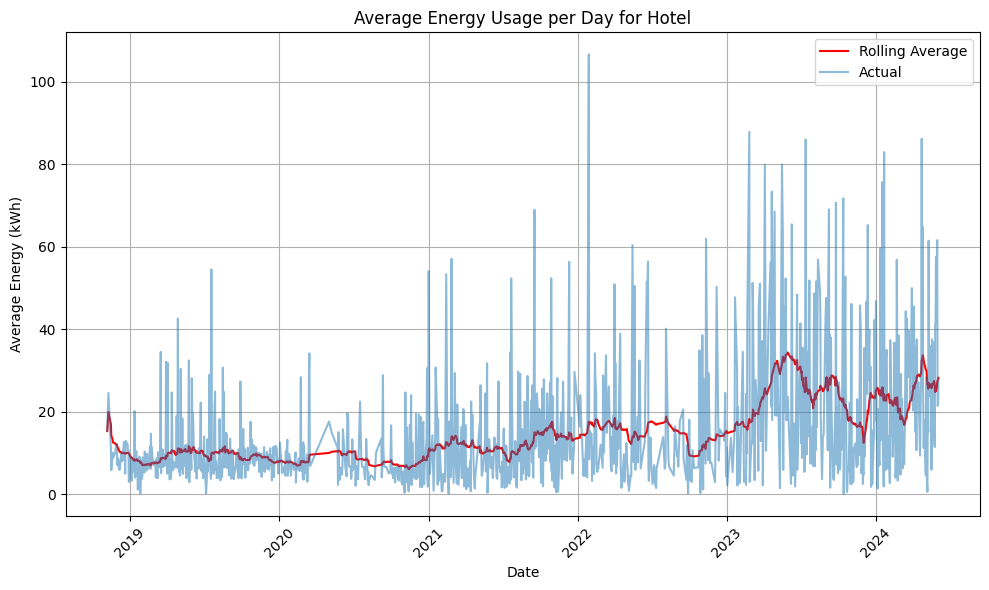

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


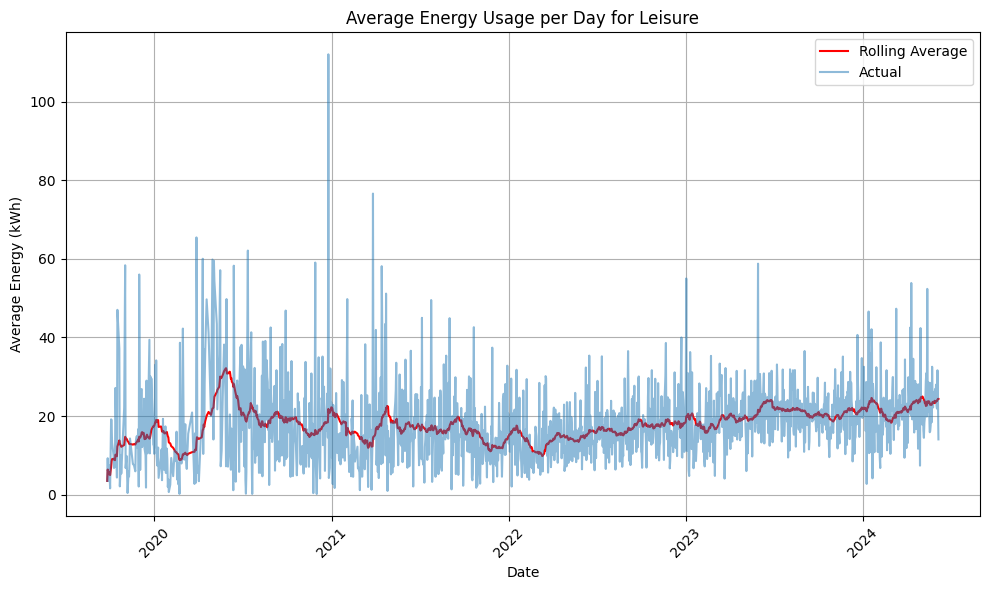

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


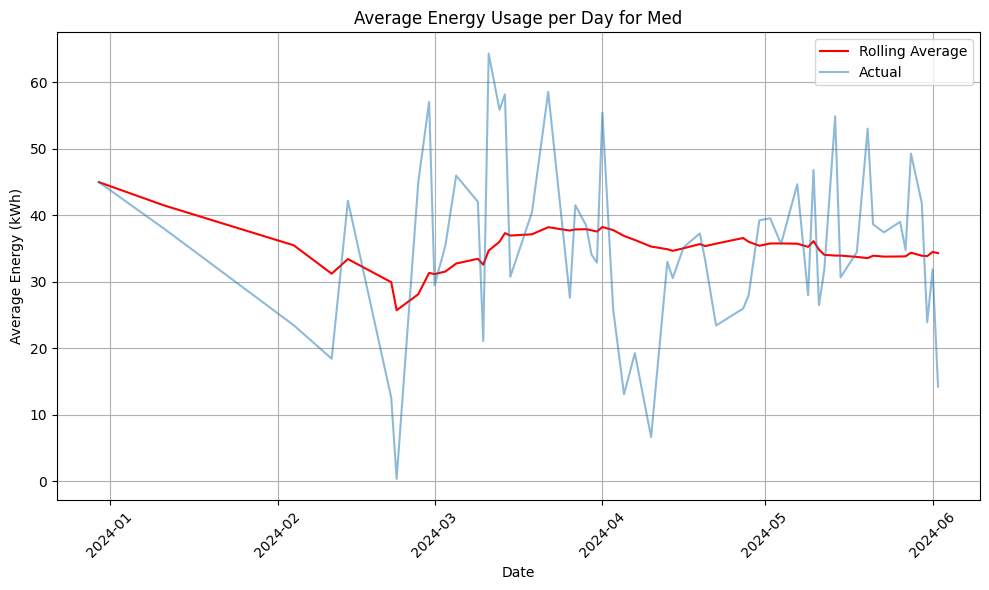

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


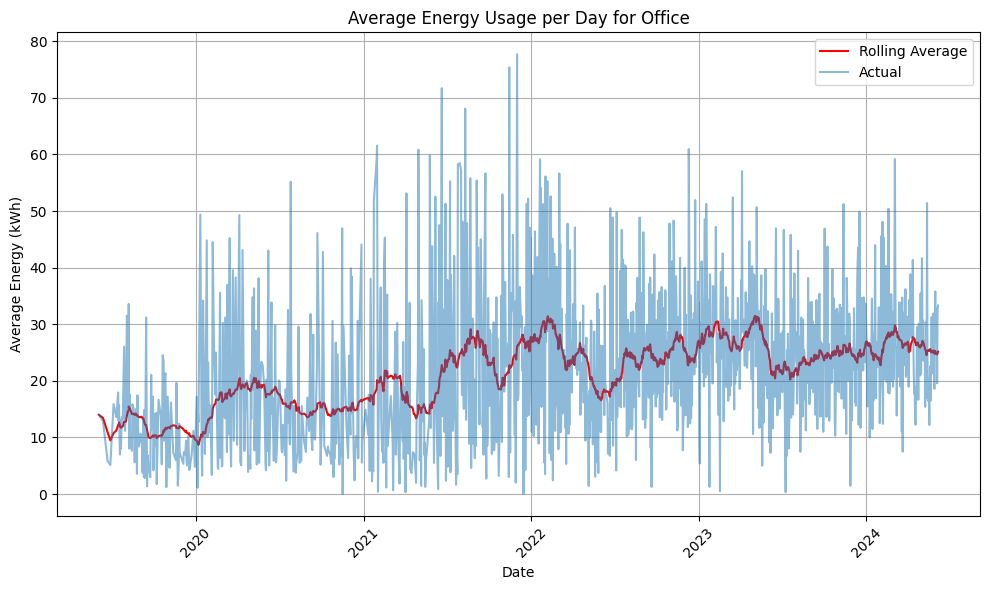

C:\Users\mehdi\AppData\Local\Temp\ipykernel_19952\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


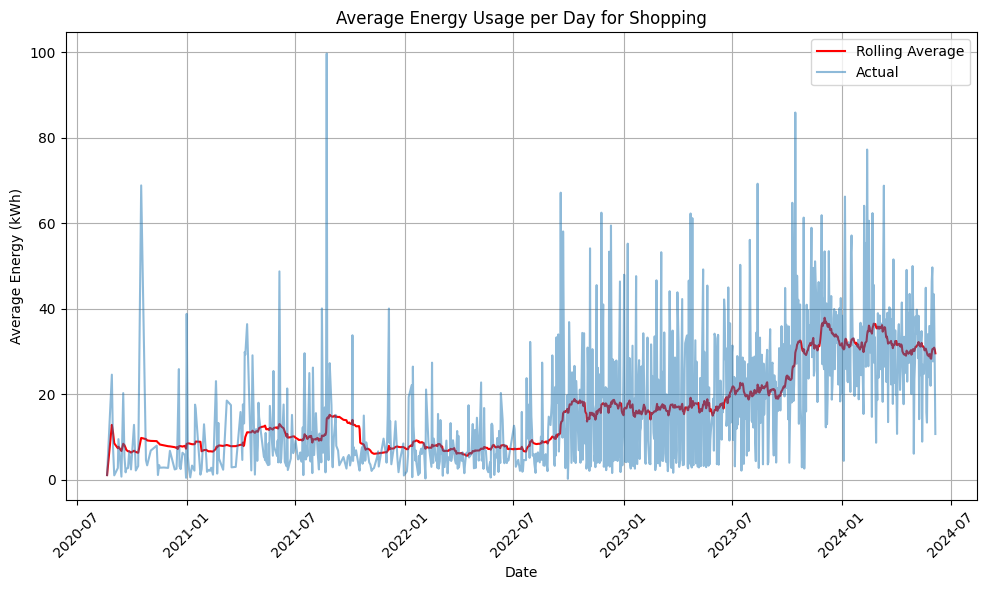

In [91]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

df['Date'] = df['Start_Time_EST'].dt.date

# Group by venue and date, and calculate average energy per day for each venue
venue_utilization_data = df.groupby(['Charging Venue', 'Date'])['Energy (kWh)'].mean().reset_index()

# Plot for each venue with a rolling average
venues = venue_utilization_data['Charging Venue'].unique()

for venue in venues:
    plt.figure(figsize=(10, 6))
    venue_data = venue_utilization_data[venue_utilization_data['Charging Venue'] == venue]

    # Calculate a 30-day rolling average for smoother trend
    venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()

    plt.plot(venue_data['Date'], venue_data['Rolling Average'], label='Rolling Average', color='red')
    plt.plot(venue_data['Date'], venue_data['Energy (kWh)'], label='Actual', alpha=0.5)

    plt.title(f'Average Energy Usage per Day for {venue}')
    plt.xlabel('Date')
    plt.ylabel('Average Energy (kWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [22]:


# Create a map centered around the mean latitude and longitude
center_lat = df_GIS['Latitude'].mean()
center_lon = df_GIS['Longitude'].mean()
map_evse = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add markers for each EVSE location with marker size based on the 'Weight' column
for index, row in df_GIS.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Weight'],
        popup=row['Station Name'],
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map_evse)

# Display the map
#map_evse


KeyError: 'Latitude'

# Perform OLS regression DC only 

In [267]:

independent_vars = ['Energy_Unit_Price','port_kw','Distance (miles)','season','peak_hour','Temp','Fahrenheit_Degree_Days',
                    'Day_of_Week', 'Is_Weekday', 'Is_Weekend', 'ven_HWY','ven_hotel','ven_med_ed',
                    'ven_leisure',  'percentage of poulation', 
                    'ven_office', 'ven_parking', 
                    'cost_free', 'cost_paid', 'Utilization Rate',   
                    'Vehicle_Miles_traveled_Passenger',
                    'Vehicle_Passenger_Number','MED_HH_INCOME',
                     'County_population_2021']

X = utilization_station_data[independent_vars]
Y = utilization_station_data['Util_station (kWh/port/day)']

# Check for infinity and NaN
is_infinite = np.isinf(X).any()
print("Infinite values in independent variables:")
print(is_infinite)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))


X.reset_index(drop=True, inplace=True)
Y = Y.iloc[X.index]
Y.reset_index(drop=True, inplace=True)

Infinite values in independent variables:
Energy_Unit_Price                   False
port_kw                             False
Distance (miles)                    False
season                              False
peak_hour                           False
Temp                                False
Fahrenheit_Degree_Days              False
Day_of_Week                         False
Is_Weekday                          False
Is_Weekend                          False
ven_HWY                             False
ven_hotel                           False
ven_med_ed                          False
ven_leisure                         False
percentage of poulation             False
ven_office                          False
ven_parking                         False
cost_free                           False
cost_paid                           False
Utilization Rate                     True
Vehicle_Miles_traveled_Passenger    False
Vehicle_Passenger_Number            False
MED_HH_INCOME                     

In [268]:
# Double-check lengths of X and Y
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))

# Verify index ranges
print("Index range of X:", X.index.min(), "-", X.index.max())
print("Index range of Y:", Y.index.min(), "-", Y.index.max())

# Check if X's indices are within the range of Y's indices
if X.index.max() > Y.index.max() or X.index.min() < Y.index.min():
    print("Indices of X are out of range for Y")

# Check if Y's indices are within the range of X's indices
if Y.index.max() > X.index.max() or Y.index.min() < X.index.min():
    print("Indices of Y are out of range for X")


Number of samples in X: 14375
Number of samples in Y: 14375
Index range of X: 0 - 14374
Index range of Y: 0 - 14374


In [269]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Perform permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get the feature importances
importances = result.importances_mean

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

Mean Squared Error: 93.45641157446887
R-squared: 0.6270097531210705
                             Feature  Importance
4                          peak_hour    0.530042
1                            port_kw    0.507797
0                  Energy_Unit_Price    0.197123
2                   Distance (miles)    0.075218
19                  Utilization Rate    0.040676
6             Fahrenheit_Degree_Days    0.028089
14           percentage of poulation    0.024542
7                        Day_of_Week    0.017760
3                             season    0.016174
23            County_population_2021    0.006182
22                     MED_HH_INCOME    0.004190
21          Vehicle_Passenger_Number    0.003416
13                       ven_leisure    0.002825
17                         cost_free    0.001661
20  Vehicle_Miles_traveled_Passenger    0.001564
15                        ven_office    0.001509
5                               Temp    0.001205
9                         Is_Weekend    0.001149
8

In [352]:
# K-Fold cross-validation
model_LR = LinearRegression()
scores = cross_val_score(model_LR, X, Y, cv=5)
print("Cross-validation scores (Linear Regression): ", scores)
print("Average cross-validation score (Linear Regression): ", np.mean(scores))

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Testing set:", X_test.shape, Y_test.shape)

# Fit the OLS regression model on the training data
model_ols = sm.OLS(Y_train, X_train).fit()
print(model_ols.summary())

# Calculate the validation score (R-squared)
Y_val_pred = model_ols.predict(X_val)
val_score = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (OLS): ", val_score)

# Calculate the test score (R-squared)
Y_test_pred = model_ols.predict(X_test)
test_score = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (OLS): ", test_score)

Cross-validation scores (Linear Regression):  [-3.81829535e-01 -2.02075321e+02  3.90390648e-01  2.64890494e-01
 -1.28190120e-02]
Average cross-validation score (Linear Regression):  -40.36293765646213
Training set: (4345, 24) (4345,)
Validation set: (931, 24) (931,)
Testing set: (932, 24) (932,)
                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.493
Model:                                     OLS   Adj. R-squared:                  0.490
Method:                          Least Squares   F-statistic:                     199.8
Date:                         Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                                 21:55:26   Log-Likelihood:                -17379.
No. Observations:                         4345   AIC:                         3.480e+04
Df Residuals:                             4323   BIC:                         3.494e+04

In [295]:
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.530
Model:                                     OLS   Adj. R-squared:                  0.526
Method:                          Least Squares   F-statistic:                     145.2
Date:                         Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                                 15:53:30   Log-Likelihood:                -14538.
No. Observations:                         3633   AIC:                         2.913e+04
Df Residuals:                             3604   BIC:                         2.931e+04
Df Model:                                   28                                         
Covariance Type:                     nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [296]:
X1 = sm.add_constant(X)
vif = pd.DataFrame()
vif["variables"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
print(vif)

c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                           variables           VIF
0                              const  0.000000e+00
1                  Energy_Unit_Price  1.266208e+00
2                            port_kw  3.061865e+00
3                   Distance (miles)  1.020540e+00
4                             season  1.026231e+00
5                          peak_hour  1.175856e+00
6                               Temp  4.299079e+03
7             Fahrenheit_Degree_Days  5.109575e+03
8                        Day_of_Week  2.662935e+00
9                         Is_Weekday           inf
10                        Is_Weekend           inf
11                    Business_Label           inf
12                         HWY_Label           inf
13                       Hotel_Label           inf
14                        Park_Label           inf
15                       ven_leisure  2.297276e+01
16                            Weight           inf
17                     Grocery_Label           inf
18           percentage of poul

# DT

In [297]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize the decision tree regressor
model_DT = DecisionTreeRegressor(random_state=42)

# Train the model
model_DT.fit(X_train, Y_train)

# Make predictions
Y_pred = model_DT.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 11.042579319203599
Mean Squared Error: 254.77566846082206
R-squared: 0.26496706457737884


# RF Hyperparameters

High multicollinearity can be a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret.
You might want to consider dropping or transforming some of these variables to address the multicollinearity issue. For example, you could use Principal Component Analysis (PCA) to reduce the dimensionality of your dataset, or you could remove some of the highly correlated variables. You could also consider using regularization techniques like Ridge or Lasso regression which can help in handling multicollinearity.


Correlations with the dependent variable:
Energy_Unit_Price                  -0.067794
port_kw                            -0.042945
Distance (miles)                    0.024018
season                             -0.009400
peak_hour                           0.684927
Temp                               -0.138726
Fahrenheit_Degree_Days             -0.130281
Day_of_Week                         0.060598
Is_Weekday                         -0.061715
Is_Weekend                          0.061715
Business_Label                      0.037026
HWY_Label                          -0.251982
Hotel_Label                         0.229937
Park_Label                         -0.028744
ven_leisure                        -0.083754
Weight                              0.031985
Grocery_Label                       0.052813
percentage of poulation             0.112108
ven_muni                                 NaN
ven_office                          0.250696
ven_parking                              NaN
cost_free   

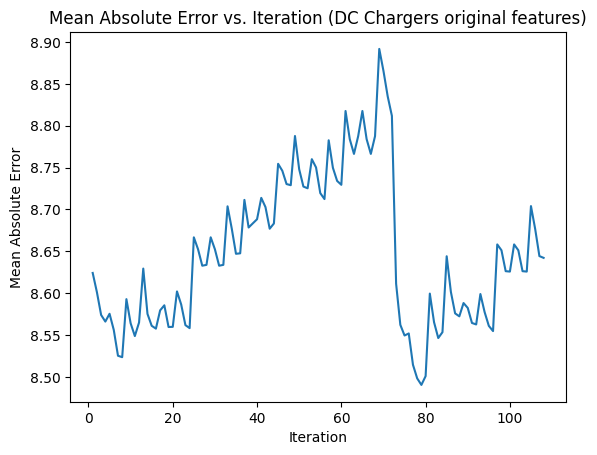


Mean MAE: 8.6485 (+/- 0.0895)
Mean R^2: 0.5969 (+/- 0.0070)
Test MAE: 8.4904
Test R^2: 0.5913


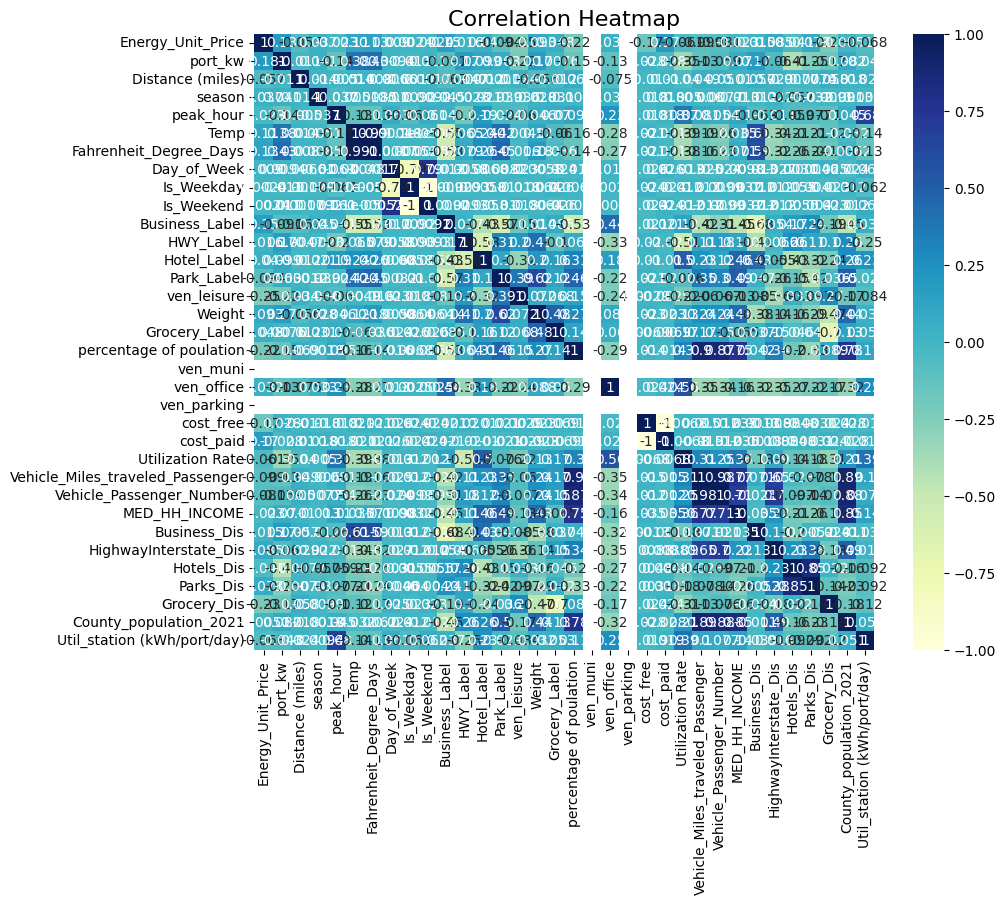

In [298]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Calculate the Pearson correlation coefficients
corr_matrix = X.join(Y).corr()
corr_with_target = corr_matrix[Y.name]

# Print the correlation coefficients with the dependent variable
print("\nCorrelations with the dependent variable:")
print(corr_with_target)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_val_pred = rf_model.predict(X_val)
val_score_rf = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (Random Forest):", val_score_rf)

Y_test_pred = rf_model.predict(X_test)
test_score_rf = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (Random Forest):", test_score_rf)




param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)



mae_values = []
train_scores = []
test_scores = []
r2_scores = []  # Initialize r2_scores list

# Perform cross-validation to get MAE, training, and testing scores after each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    if params['max_features'] != 'auto':  # Check if 'max_features' is set to 'auto'
        rf = RandomForestRegressor(**params, random_state=42)
        rf.fit(X_train, Y_train)

        # Calculate MAE
        Y_pred = rf.predict(X_test)
        mae = mean_absolute_error(Y_test, Y_pred)
        mae_values.append(mae)

        # Calculate R-squared scores for training and testing sets
        train_score = rf.score(X_train, Y_train)
        test_score = rf.score(X_test, Y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

        # Calculate R-squared score for validation set
        r2_score_val = r2_score(Y_val, rf.predict(X_val))
        r2_scores.append(r2_score_val)

        print(f"Iteration {i+1}: MAE = {mae}, Train Score = {train_score}, Test Score = {test_score}, Val Score = {r2_score_val}")
    else:
        print(f"Iteration {i+1}: 'max_features' is set to 'auto', skipping...")


# Plot MAE values
plt.plot(range(1, len(mae_values) + 1), mae_values, marker='', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration (DC Chargers original features)')
plt.show()

from sklearn.metrics import r2_score
# Calculate the mean and standard deviation of MAE and R^2
mae_mean = np.mean(mae_values)
mae_std = np.std(mae_values)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
print(f"\nMean MAE: {mae_mean:.4f} (+/- {mae_std:.4f})")
print(f"Mean R^2: {r2_mean:.4f} (+/- {r2_std:.4f})")

# Make predictions on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}") 
print(f"Test R^2: {test_r2:.4f}")

# Create a heatmap visualization for correlation 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Correlations with the dependent variable:
Energy_Unit_Price   -0.173883
port_kw             -0.016780
Distance (miles)     0.043269
season               0.046078
peak_hour            0.608880
Temp                -0.076413
Name: Util_station (kWh/port/day), dtype: float64
Pearson correlation coefficient: -0.17388338390986302


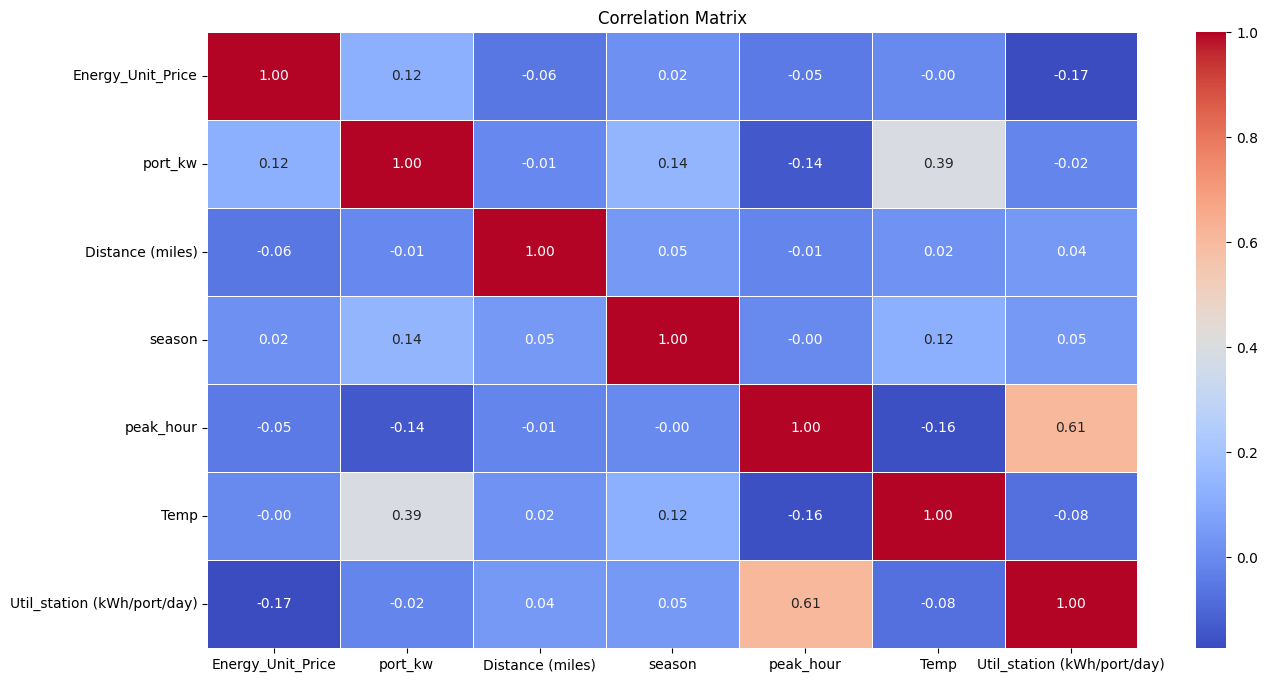

In [218]:
# Combine independent variables and dependent variable into one DataFrame
df_combined = pd.concat([X, Y], axis=1)

# Calculate correlations
correlations = df_combined.corr()

# Extract correlation values with the dependent variable
corr_with_dependent = correlations.iloc[:-1, -1]

# Print correlations with the dependent variable
print("Correlations with the dependent variable:")
print(corr_with_dependent)

# Calculate Pearson correlation coefficient
pearson_coefficient = df_combined.corr().iloc[:-1, -1].values[0]

print("Pearson correlation coefficient:", pearson_coefficient)

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
correlations = df_combined.corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Test MAE: 10.2441
Test R^2: 0.3730


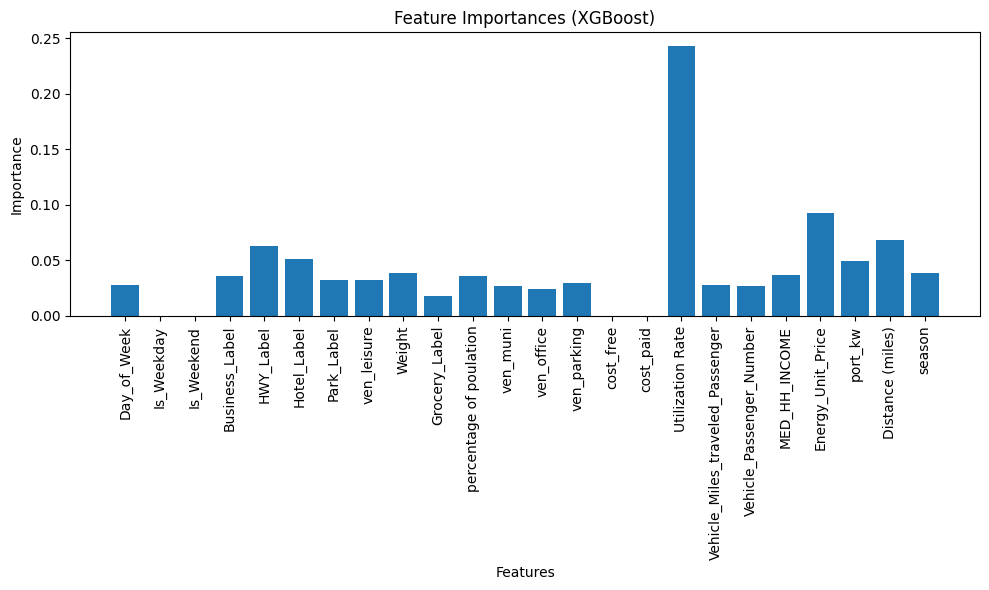

In [164]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_XG = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_XG.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_XG.best_params_
best_estimator = grid_search_XG.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

Test MAE: 13.6362
Test R^2: -0.0189


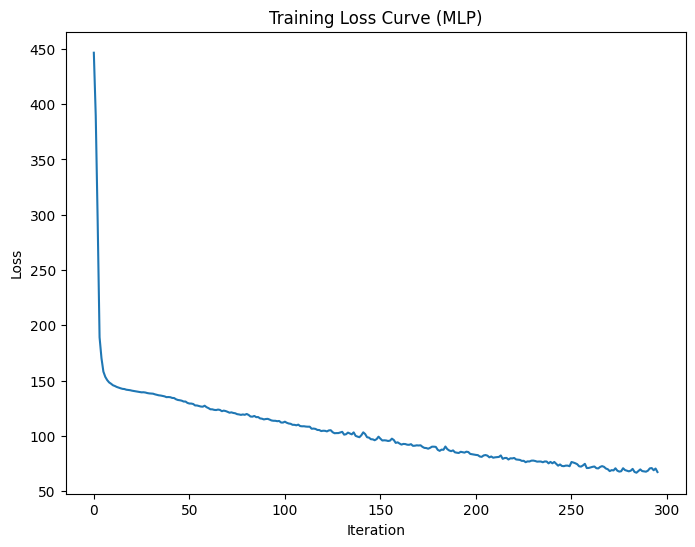

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an MLP regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(200,100, 50), activation='relu', solver='adam',
                         alpha=0.0001, max_iter=1000, random_state=42)

# Train the model
mlp_model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
Y_pred = mlp_model.predict(X_test_scaled)

# Evaluate the model
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve (MLP)')
plt.show()

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
Test MAE: 10.4626
Test R^2: 0.3679


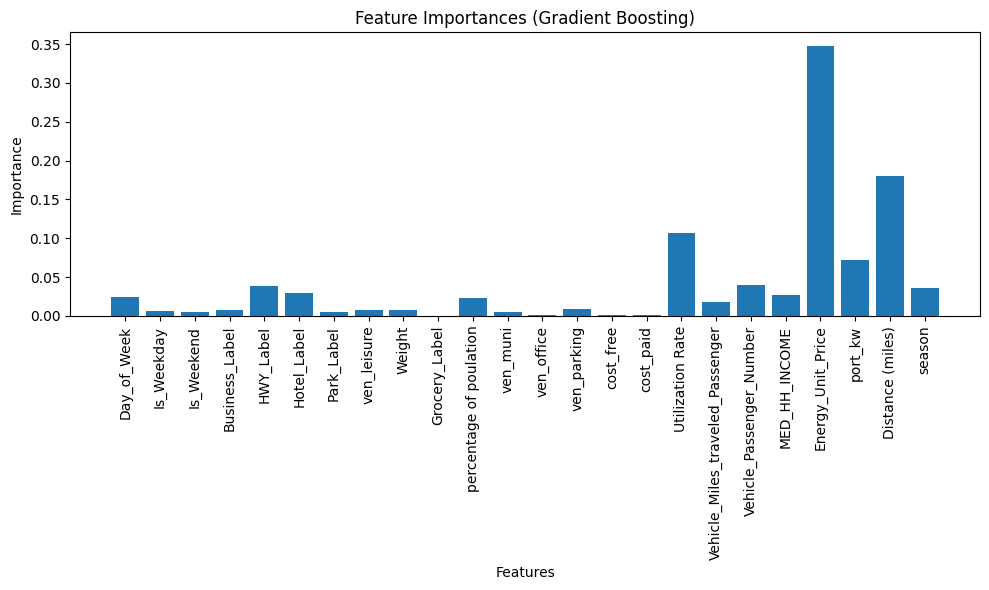

In [166]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

gb_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search_GBR = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_GBR.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_GBR.best_params_
best_estimator = grid_search_GBR.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.show()